Author: Tuwe Löfström (tuwe.lofstrom@ju.se)  
Copyright 2023 Tuwe Löfström  
License: BSD 3 clause

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from calibrated_explanations import CalibratedExplainer, VennAbers, __version__
from lime.lime_tabular import LimeTabularExplainer

print(f"calibrated_explanations {__version__}")

calibrated_explanations v0.3.1


In [3]:

dataSet = 'glass'
delimiter = ','
num_to_test = 24
print(dataSet)

fileName = '../data/Multiclass/' + dataSet + ".csv"
df = pd.read_csv(fileName, delimiter=delimiter)
target = 'Type'

df = df.dropna()
categorical_features = []
categorical_labels = {}
for c, col in enumerate(df.columns):
    if df[col].dtype == object:
        df[col] = df[col].str.replace("'", "")
        df[col] = df[col].str.replace('"', '')
        if col != target:
            categorical_features.append(c)
            categorical_labels[c] = dict(zip(range(len(np.unique(df[col]))),np.unique(df[col])))
        else:
            target_labels = dict(zip(range(len(np.unique(df[col]))),np.unique(df[col])))
        mapping = dict(zip(np.unique(df[col]), range(len(np.unique(df[col])))))
        if len(mapping) > 5:
            counts = df[col].value_counts().sort_values(ascending=False)
            id = 0
            for key, count in counts.items():
                if count > 5:
                    id += 1
                    continue
                mapping[key] = id
        df[col] = df[col].map(mapping)
print(target_labels)

glass
{0: 'build wind float', 1: 'build wind non-float', 2: 'containers', 3: 'headlamps', 4: 'tableware', 5: 'vehic wind float'}


In [4]:
df.head()

RI     Na    Mg    Al     Si     K     Ca   Ba    Fe  Type
0  1.51793  12.79  3.50  1.12  73.03  0.64   8.77  0.0  0.00     0
1  1.51643  12.16  3.52  1.35  72.89  0.57   8.53  0.0  0.00     5
2  1.51793  13.21  3.48  1.41  72.64  0.59   8.43  0.0  0.00     0
3  1.51299  14.40  1.74  1.54  74.55  0.00   7.59  0.0  0.00     4
4  1.53393  12.30  0.00  1.00  70.16  0.12  16.19  0.0  0.24     1

In [5]:
X, y = df.drop(target,axis=1), df[target] 
no_of_classes = len(np.unique(y))
no_of_features = X.shape[1]
no_of_instances = X.shape[0]
# sort targets to make sure equal presence of both classes in test set (see definition of test_index after outer loop below)
idx = np.argsort(y.values).astype(int)
X, y = X.values[idx,:], y.values[idx]
test_idx = []
idx = list(range(no_of_instances))
for i in range(no_of_classes):
    test_idx.append(np.where(y == i)[0][0:int(num_to_test/no_of_classes)])
test_index = np.array(test_idx).flatten()
# Select num_to_test/2 from top and num_to_test/2 from bottom of list of instances
train_index = np.setdiff1d(np.array(range(no_of_instances)), test_index)   
trainCalX, testX = X[train_index,:], X[test_index,:]
trainCalY, testY = y[train_index], y[test_index]
trainX, calX, trainY, calY = train_test_split(trainCalX, trainCalY, test_size=0.33,random_state=42, stratify=trainCalY)
print(testY)
print(categorical_features)

[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5]
[]


In [6]:
model = RandomForestClassifier(n_estimators=100)
model_name = 'RF' 
model.fit(trainX,trainY)  

RandomForestClassifier()

In [7]:
bins_cal = model.predict(calX)
va = VennAbers(model.predict_proba(calX), calY, model, bins=bins_cal)
bins_test = model.predict(testX)
va_preds = va.predict(testX, bins=bins_test)
va_proba, low, high, classes = va.predict_proba(testX, output_interval=True, bins=bins_test)
print(*zip(low, va_proba[:,1], high, va_preds, testY, classes),sep='\n')  

(0.7857142686843872, 0.797153013265024, 0.8421052694320679, 1.0, 0, 0)
(0.7857142686843872, 0.797153013265024, 0.8421052694320679, 1.0, 0, 0)
(0.7857142686843872, 0.797153013265024, 0.8421052694320679, 1.0, 0, 0)
(0.7857142686843872, 0.797153013265024, 0.8421052694320679, 1.0, 0, 0)
(0.6470588445663452, 0.7391304462753759, 1.0, 1.0, 1, 1)
(0.5714285969734192, 0.6202531745849831, 0.699999988079071, 1.0, 1, 1)
(0.5714285969734192, 0.6202531745849831, 0.699999988079071, 1.0, 1, 1)
(0.8888888955116272, 0.900000005364418, 1.0, 1.0, 1, 1)
(0.8571428656578064, 0.875000006519258, 1.0, 1.0, 2, 3)
(0.6363636255264282, 0.6734693812013219, 0.75, 1.0, 2, 1)
(0.6000000238418579, 0.6451613107903568, 0.7272727489471436, 1.0, 2, 1)
(0.6000000238418579, 0.6451613107903568, 0.7272727489471436, 1.0, 2, 1)
(0.5, 0.6666666666666666, 1.0, 1.0, 3, 3)
(0.75, 0.8, 1.0, 1.0, 3, 3)
(0.75, 0.8, 1.0, 1.0, 3, 3)
(0.75, 0.8, 1.0, 1.0, 3, 3)
(0.5, 0.6666666666666666, 1.0, 1.0, 4, 4)
(0.8333333134651184, 0.857142842545

In [8]:
bins_cal = model.predict(calX)
ce = CalibratedExplainer(model, calX, calY, \
                    feature_names=df.columns, \
                    categorical_features=categorical_features, \
                    class_labels=target_labels, \
                    bins=bins_cal)
display(ce)

CalibratedExplainer:
	                mode=classification
	                mondrian=True
	                discretizer=<class 'NoneType'>
	                model=RandomForestClassifier()
	                

In [9]:
bins_test = model.predict(testX)
factual_explanation = ce.explain_factual(testX, bins=bins_test)

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\_explanations.py:950: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,num_to_show*.5+2))


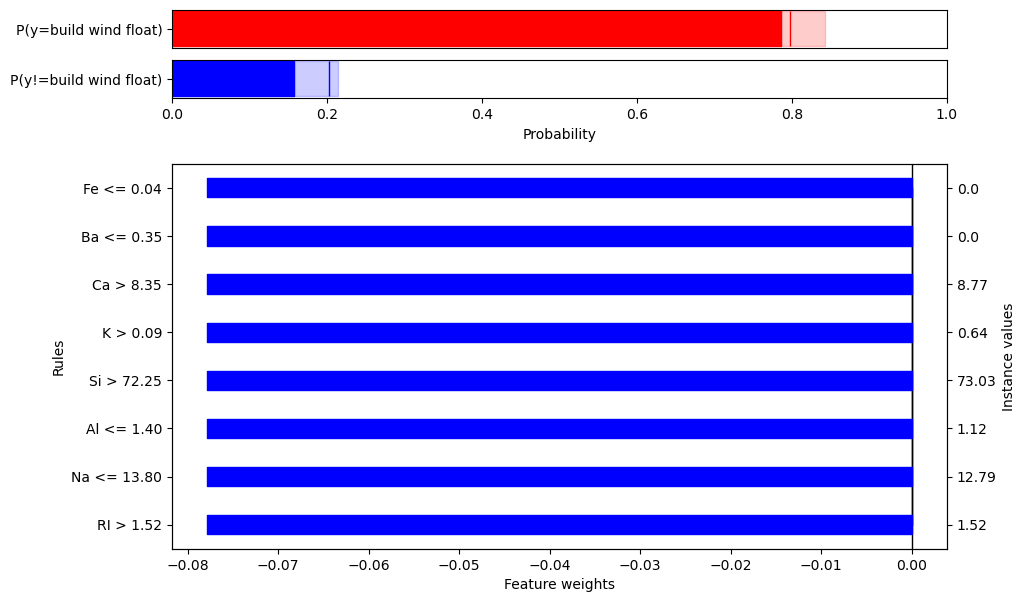

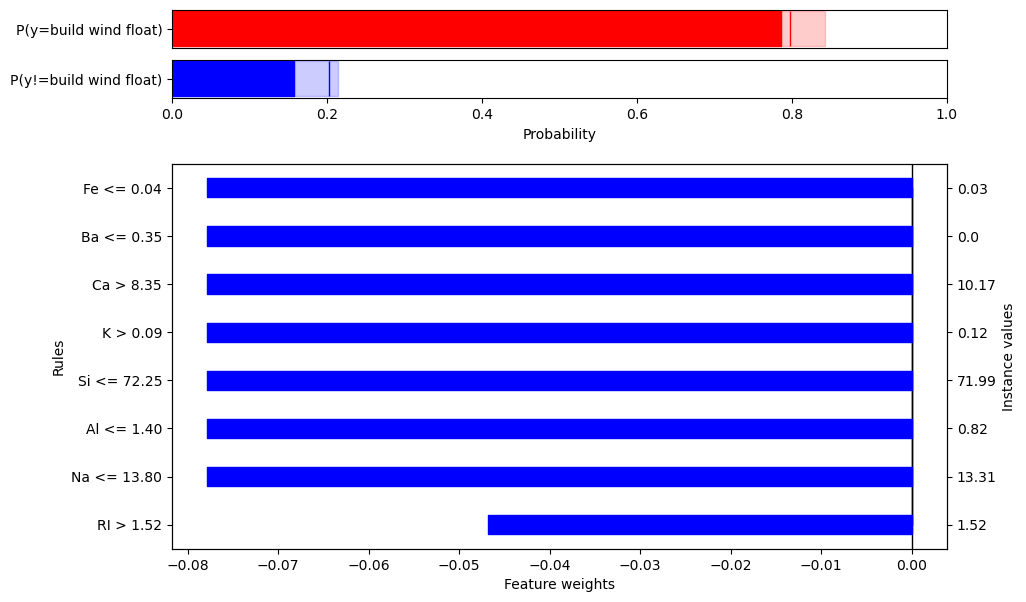

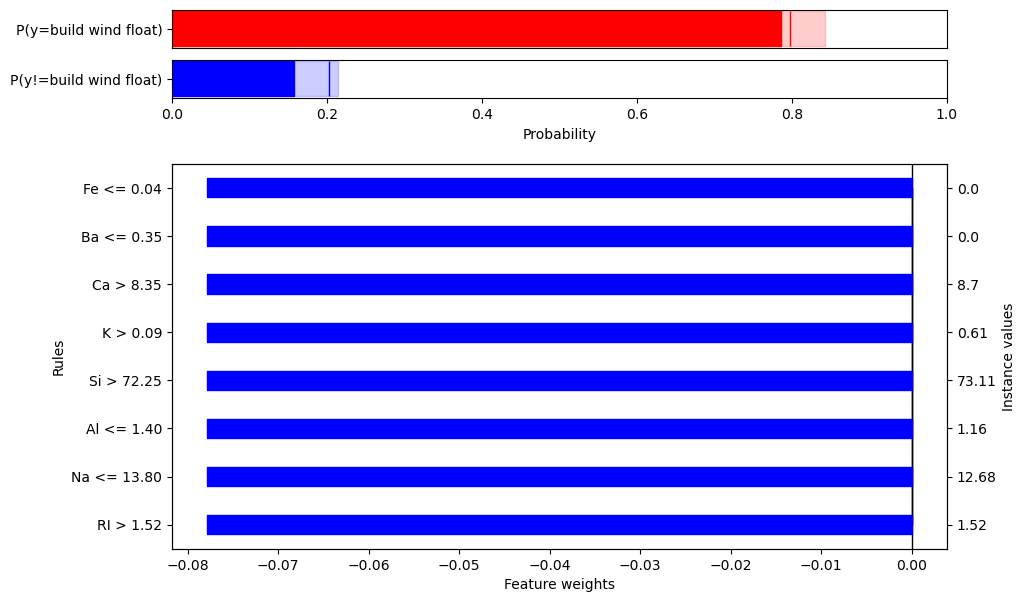

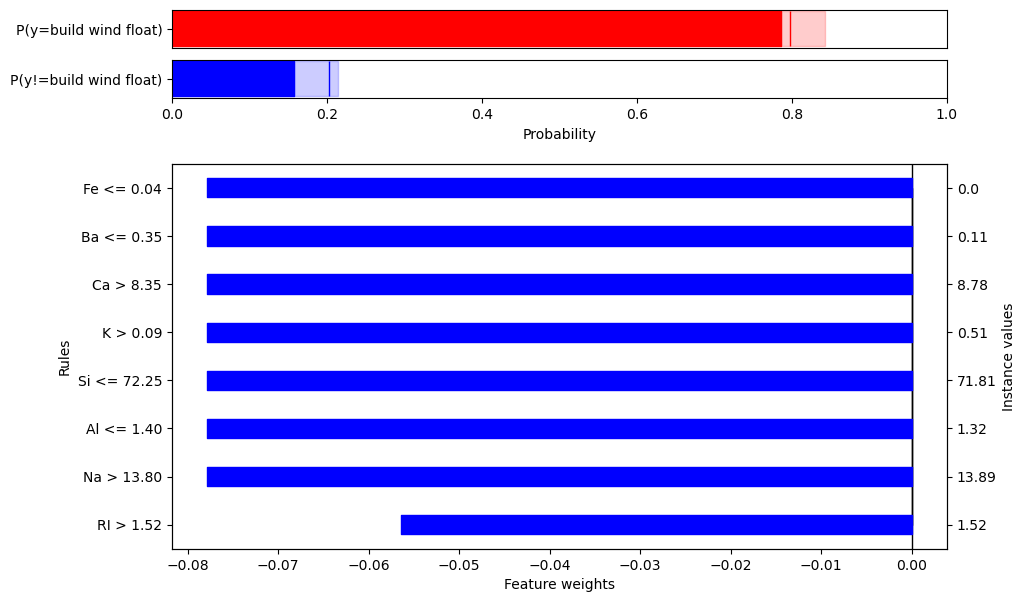

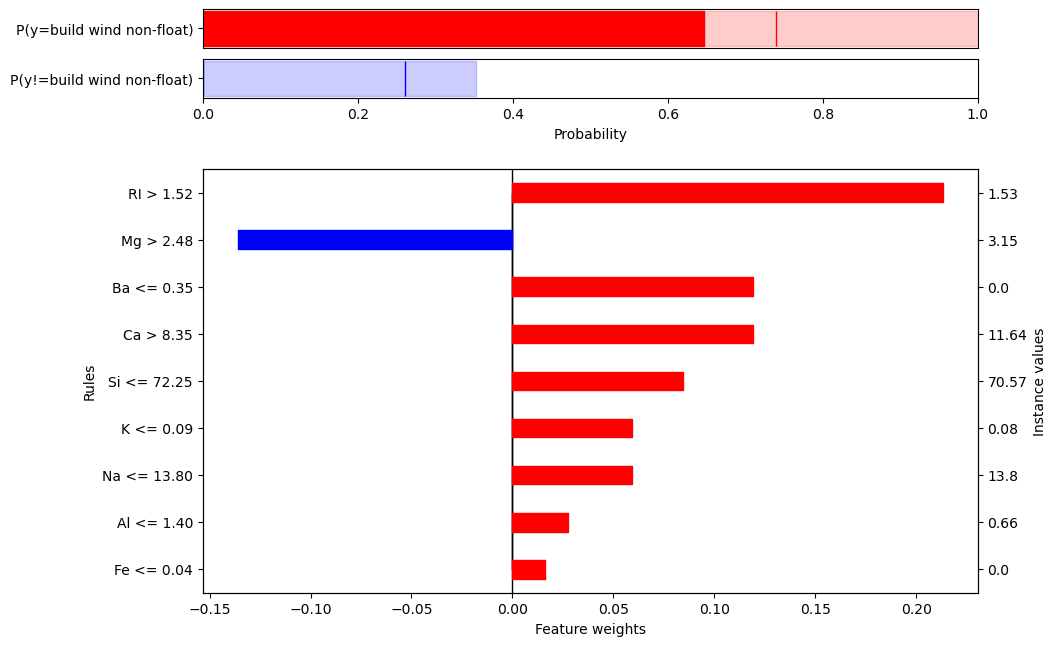

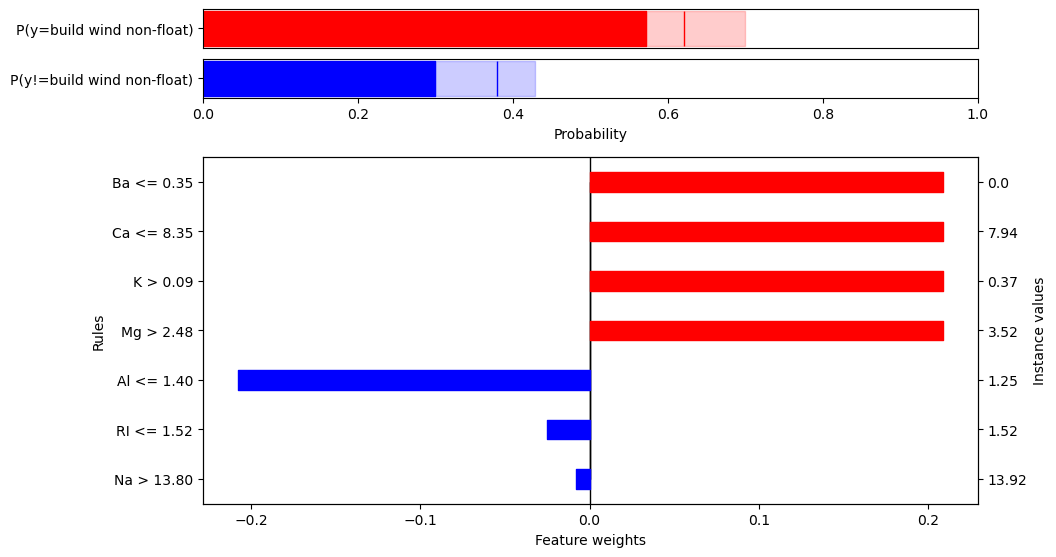

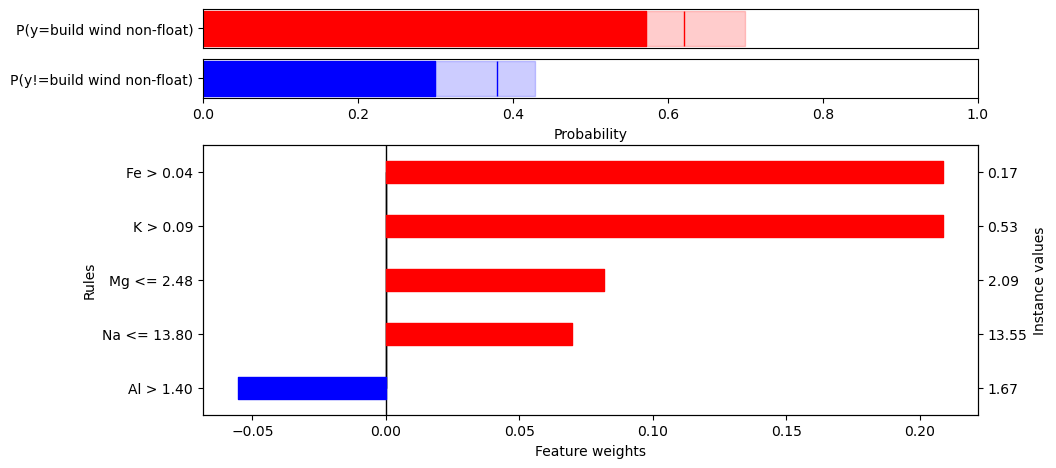

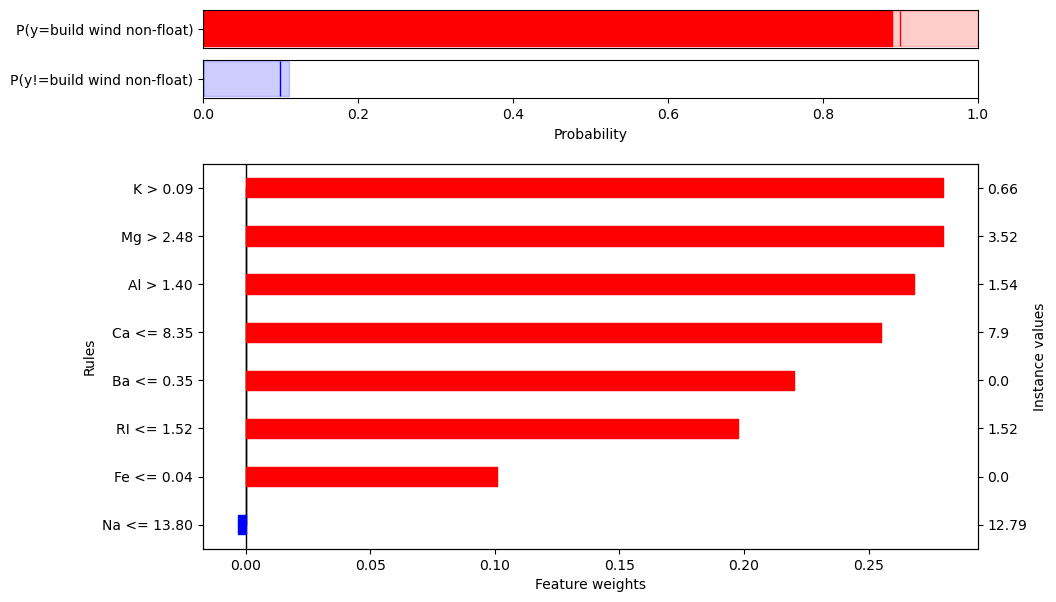

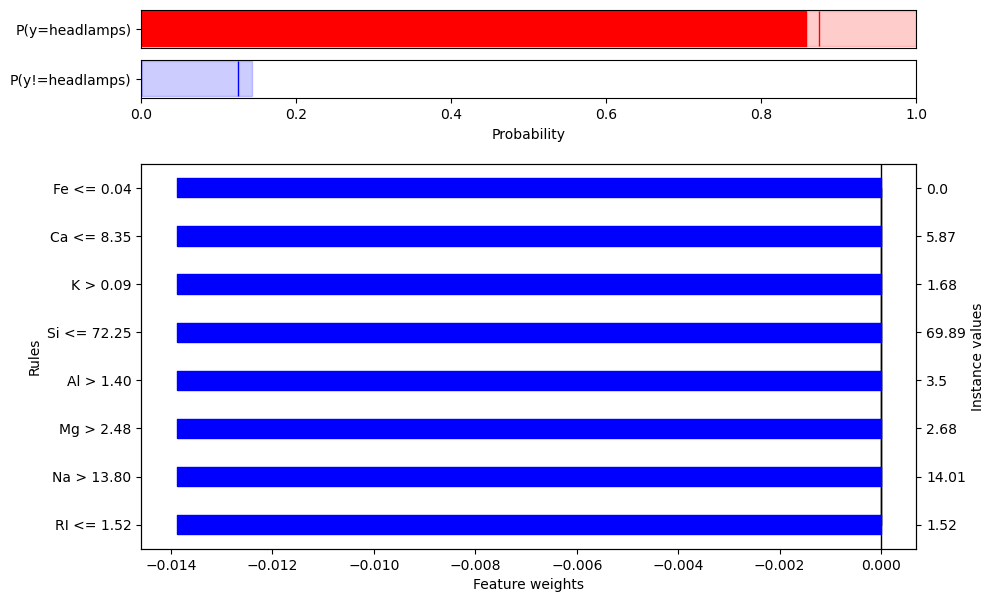

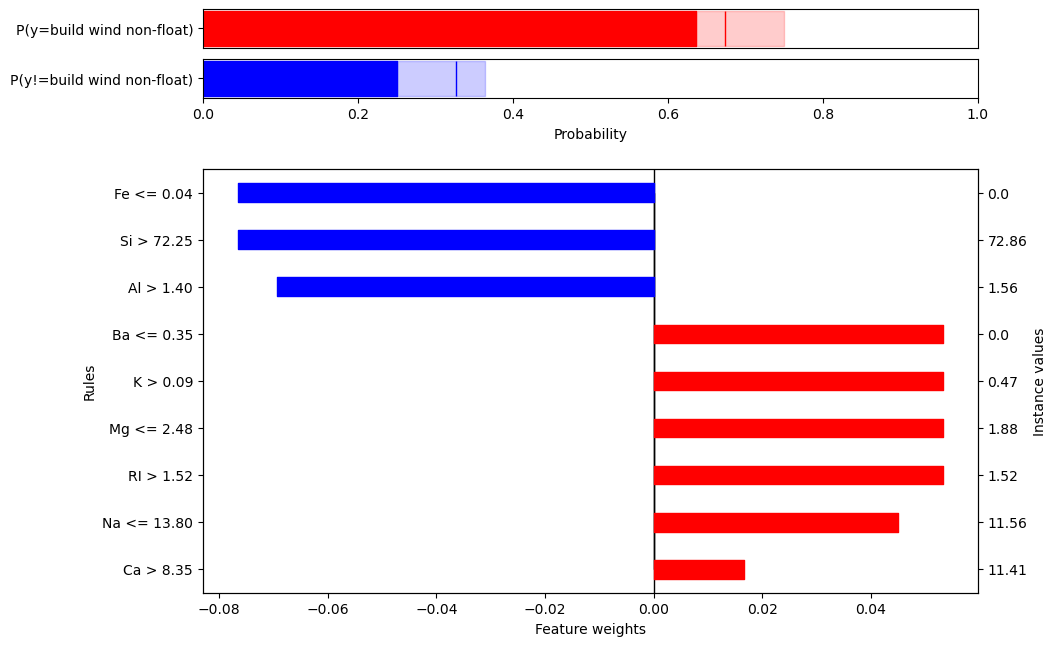

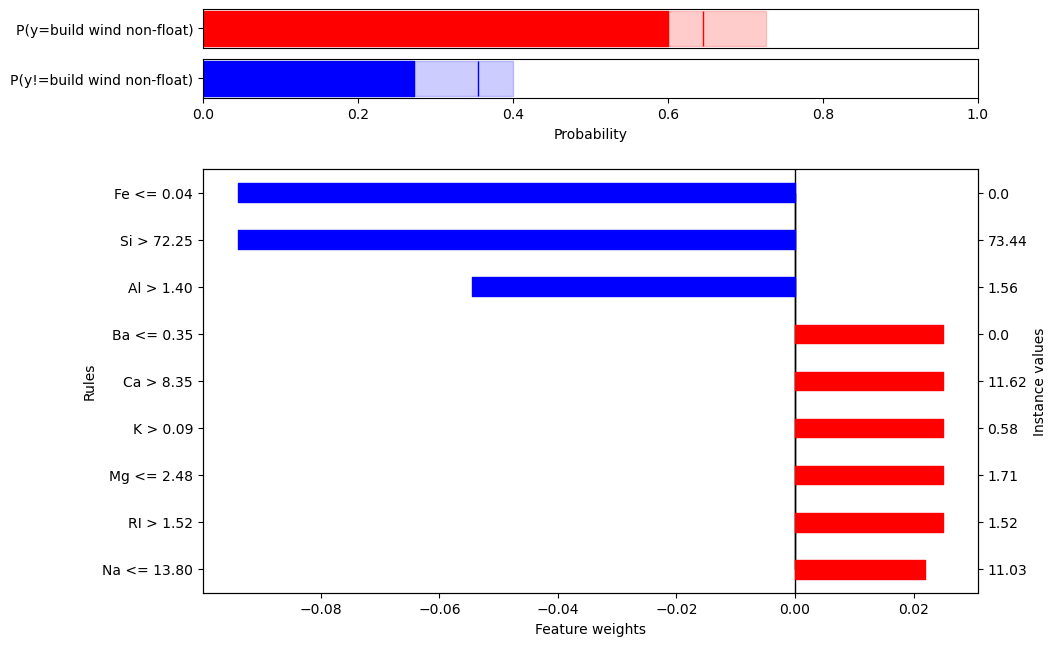

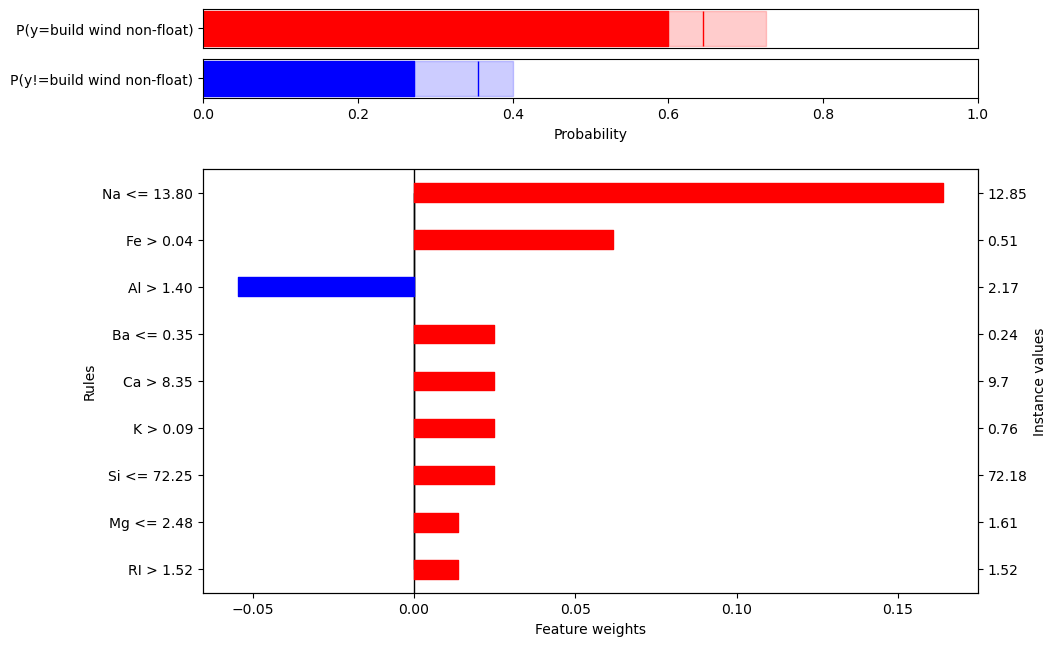

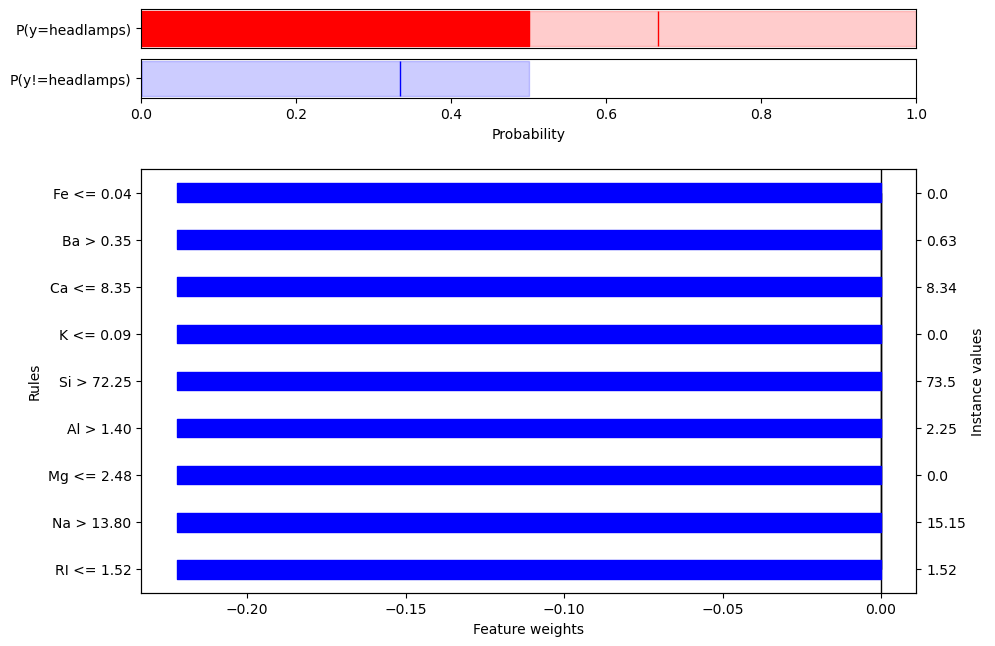

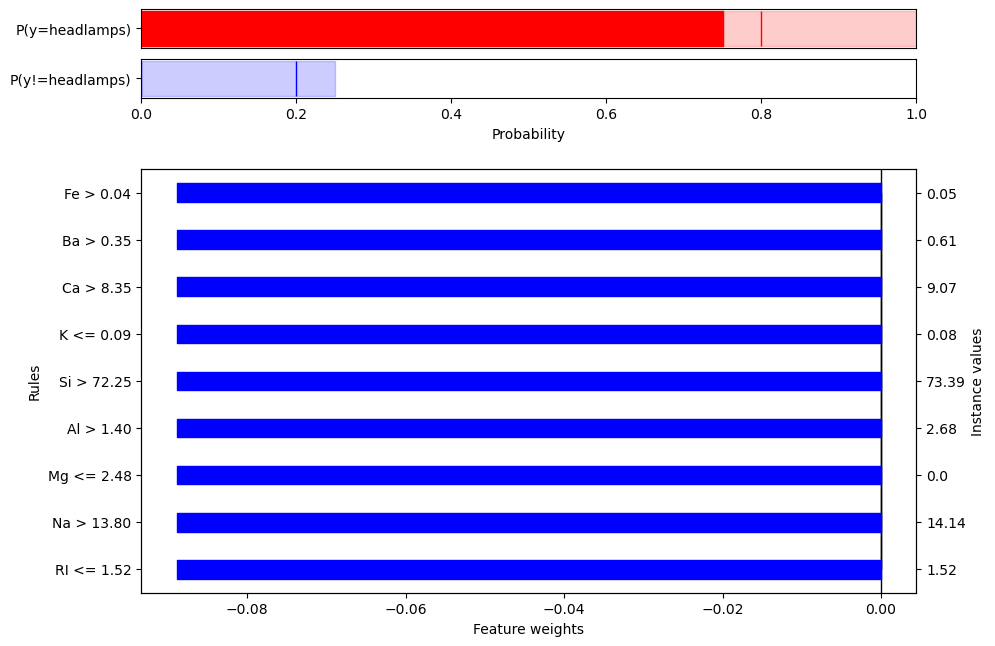

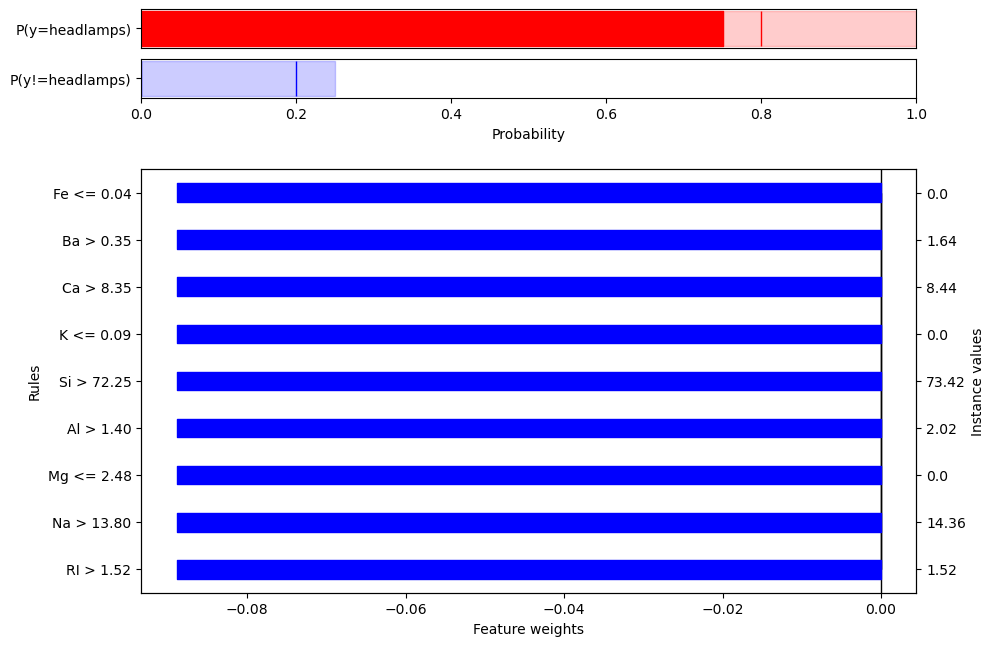

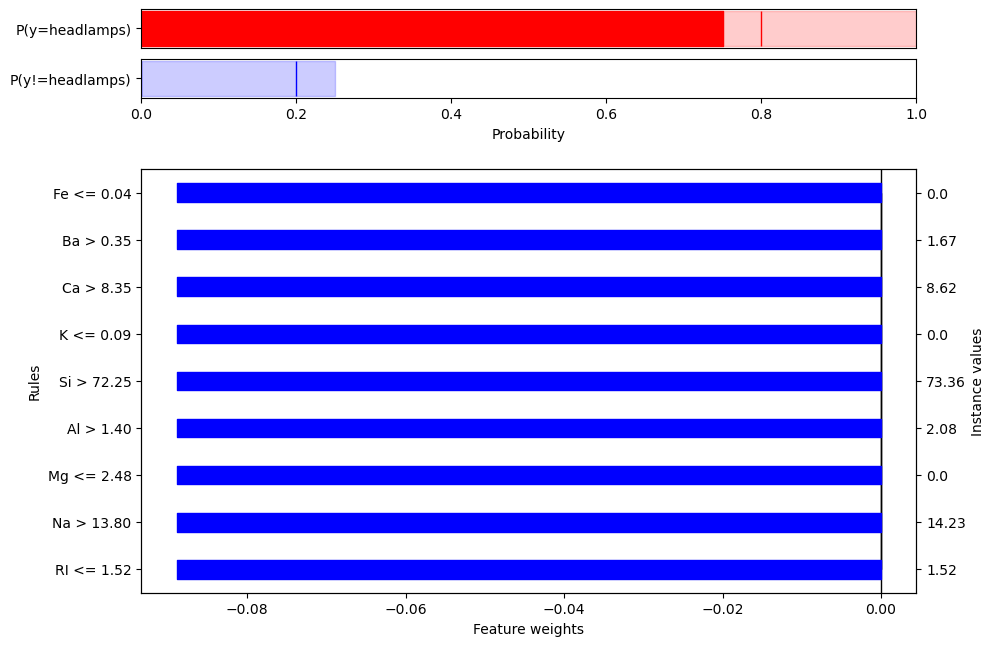

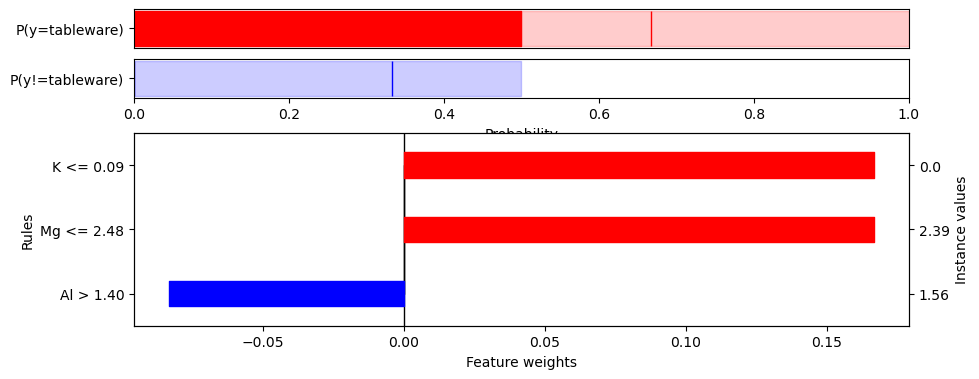

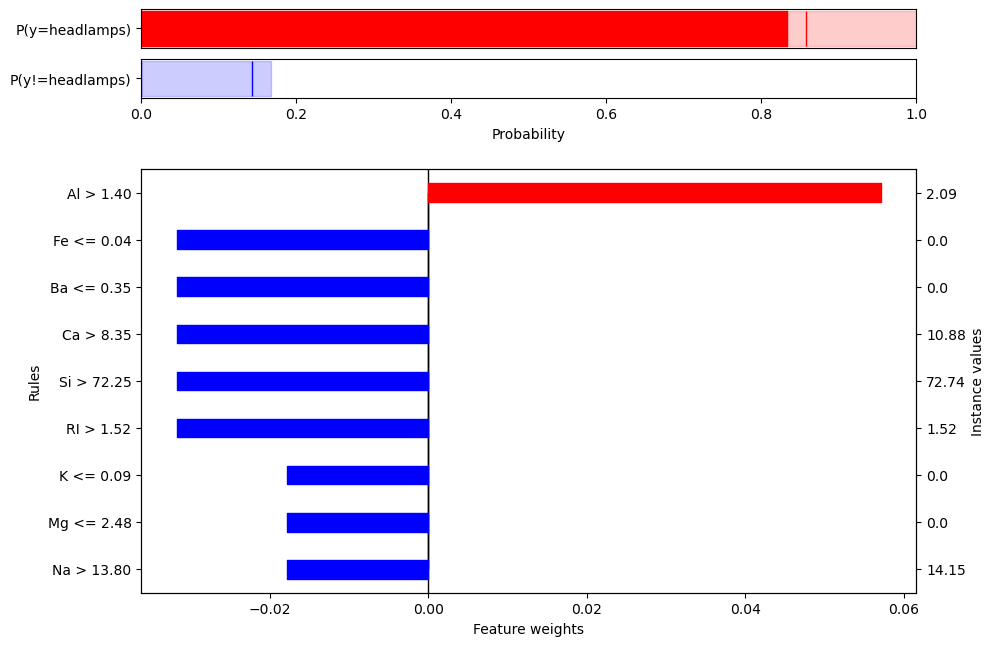

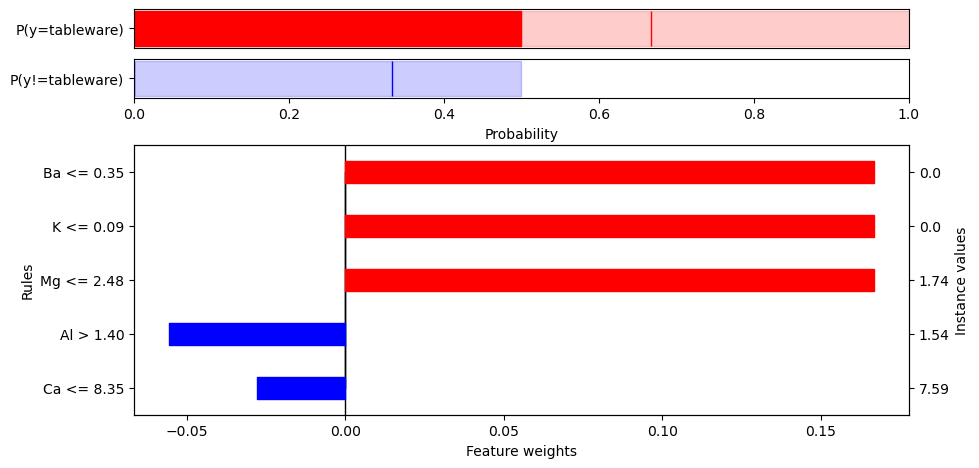

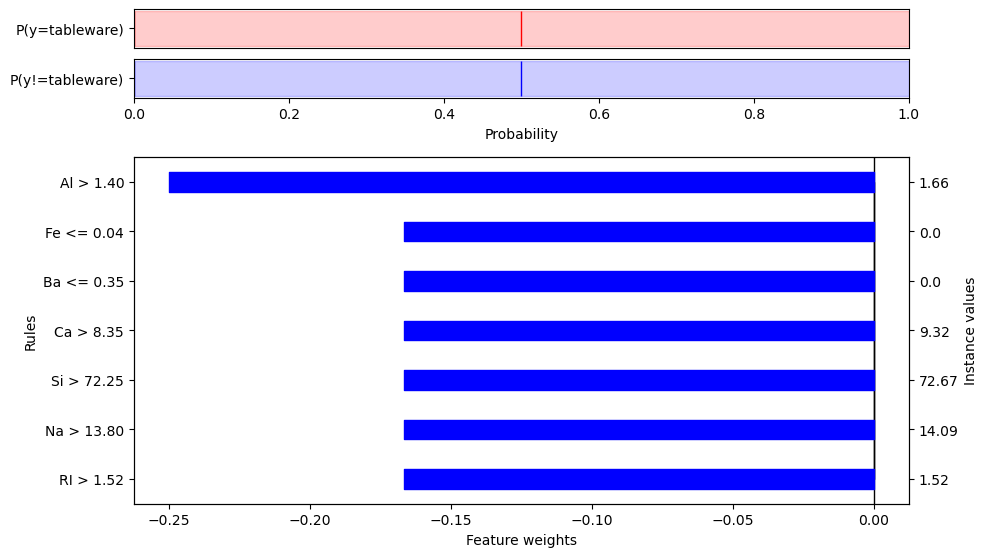

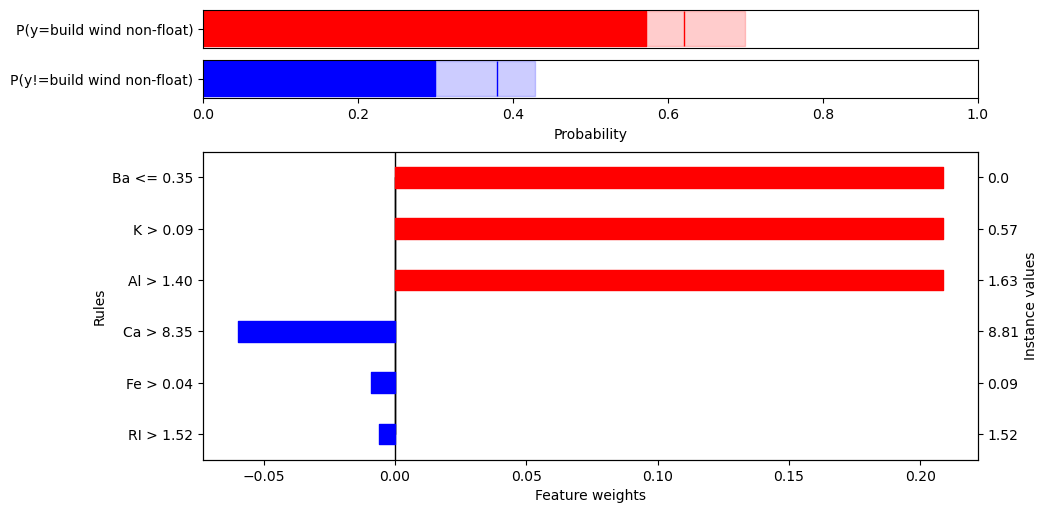

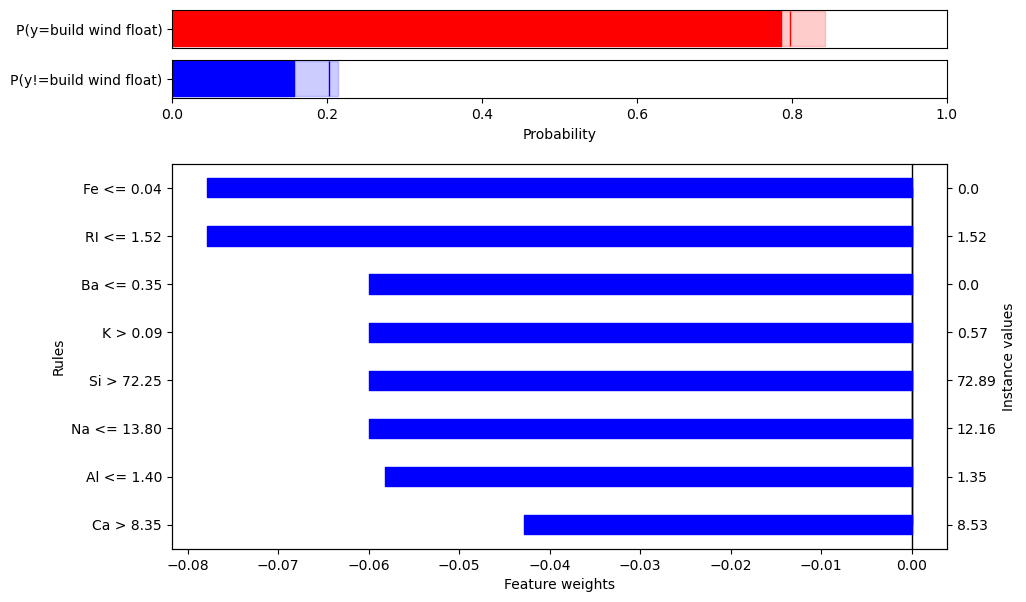

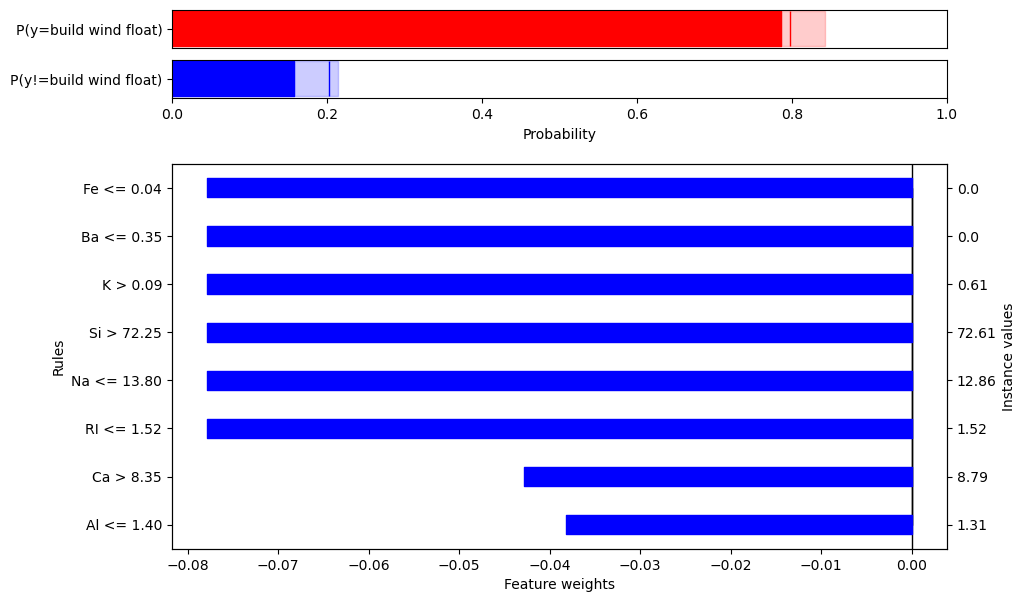

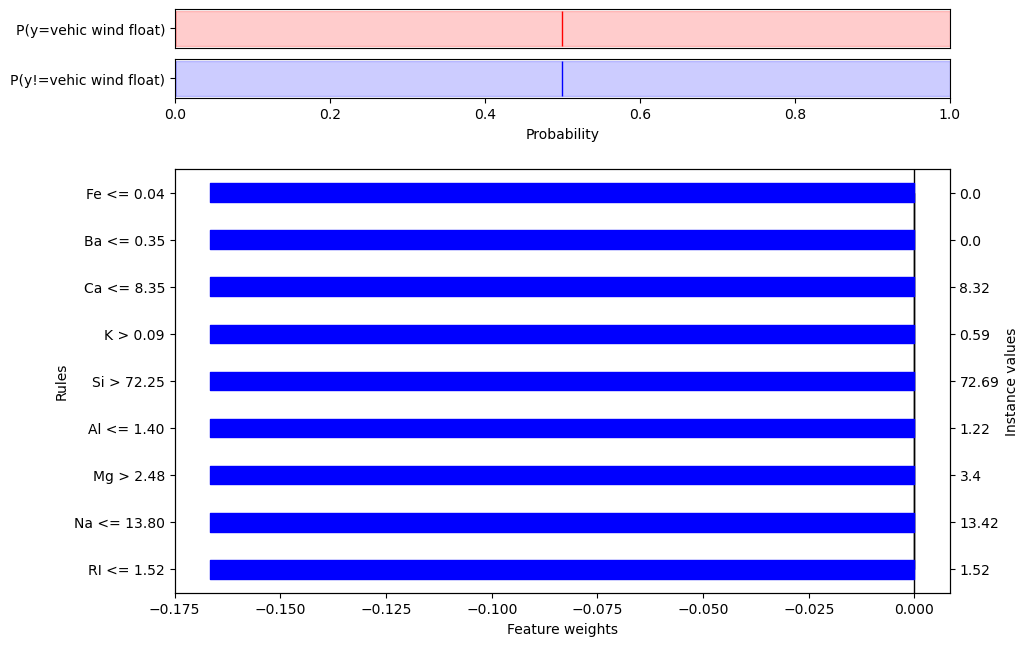

In [10]:
factual_explanation.plot_all()

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\_explanations.py:950: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,num_to_show*.5+2))


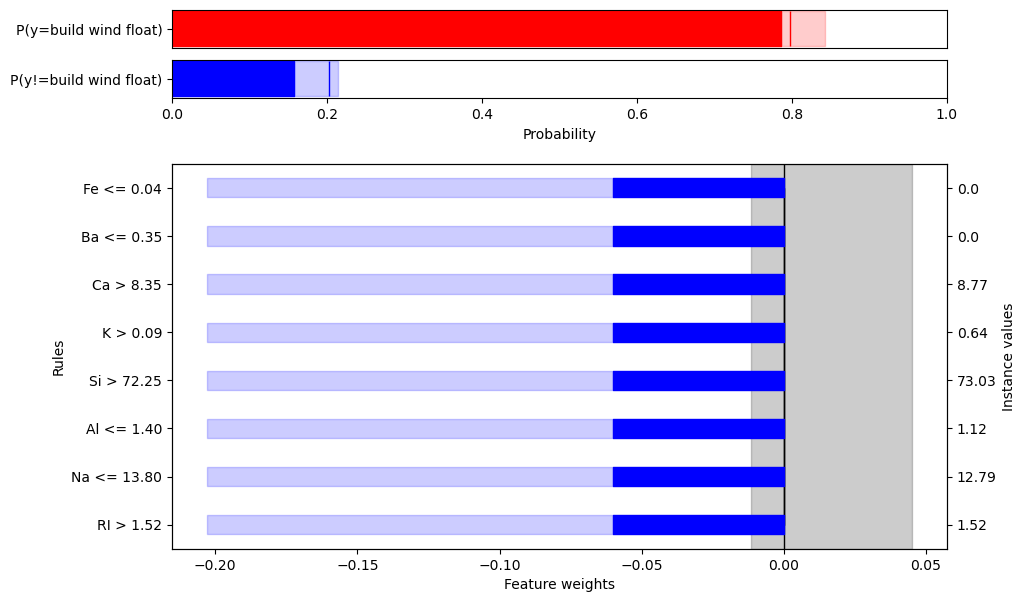

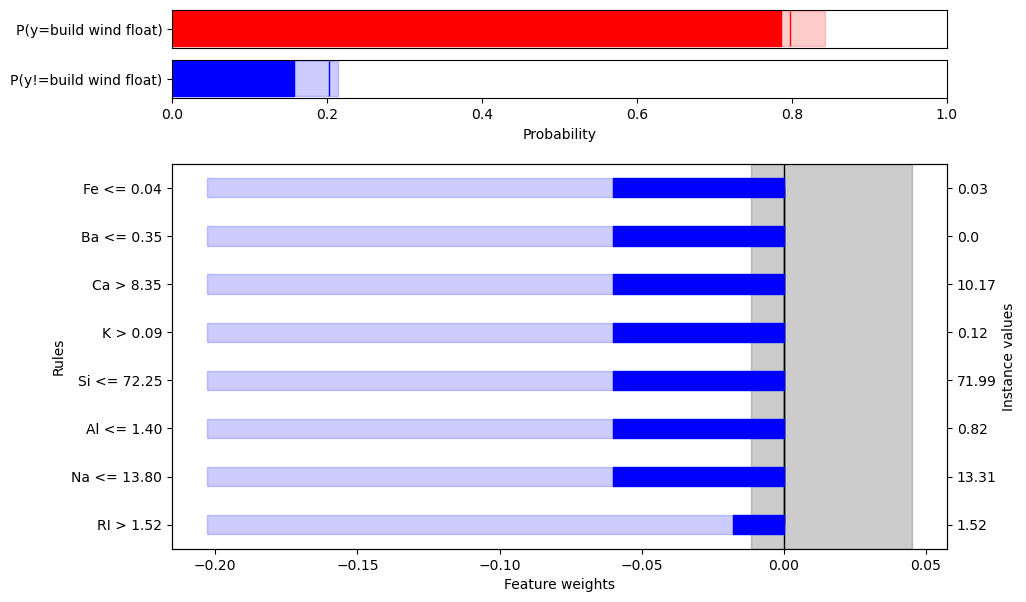

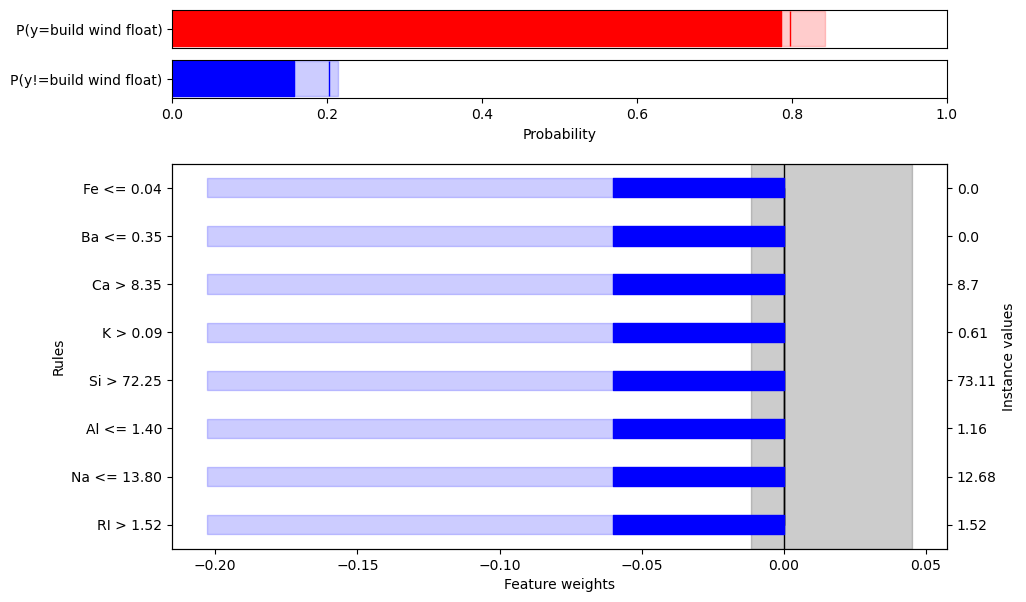

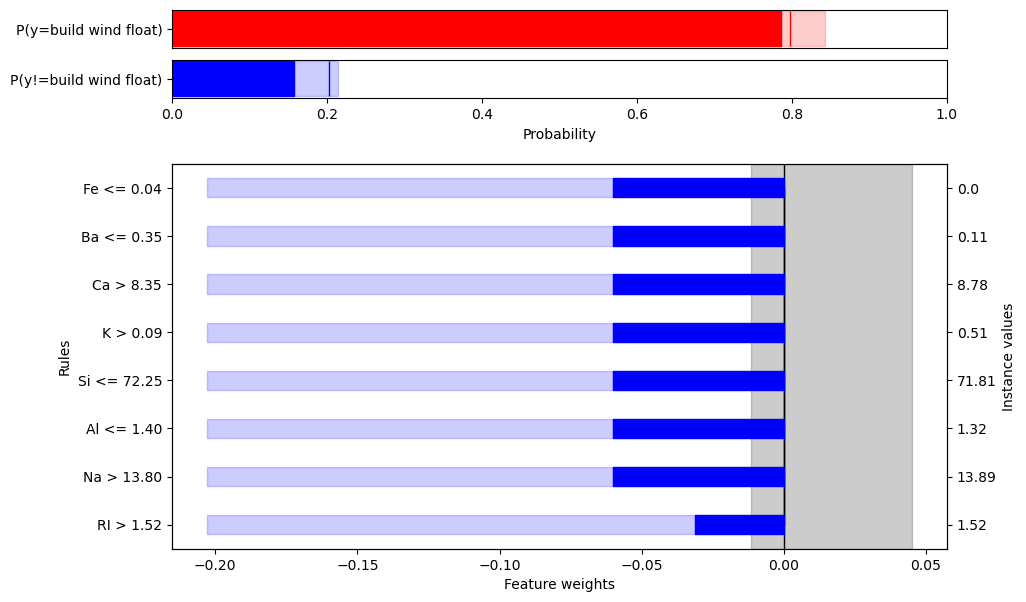

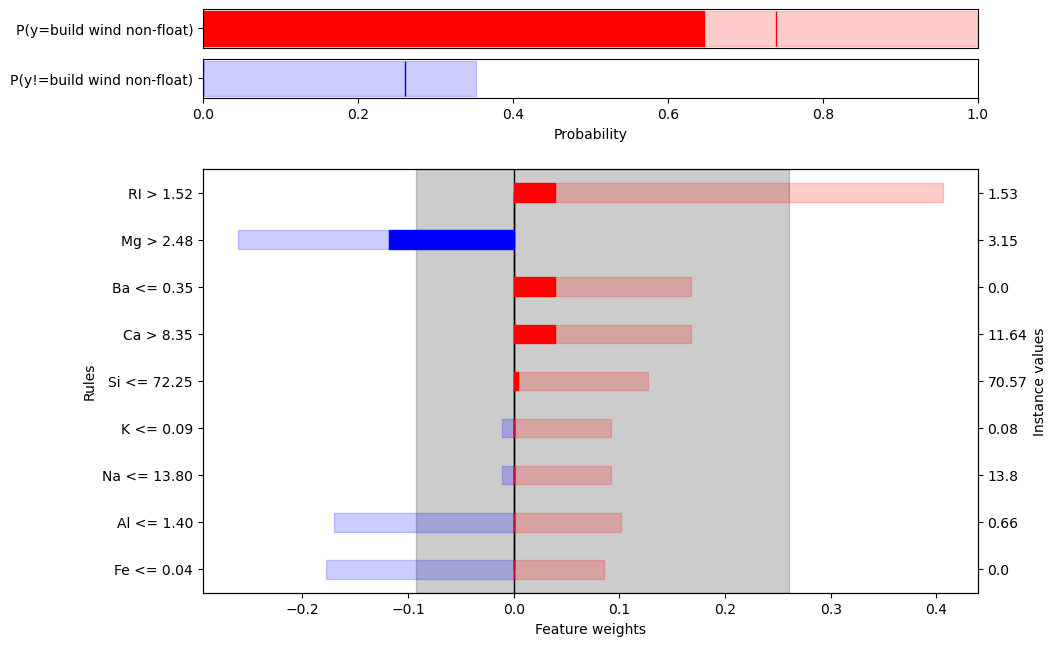

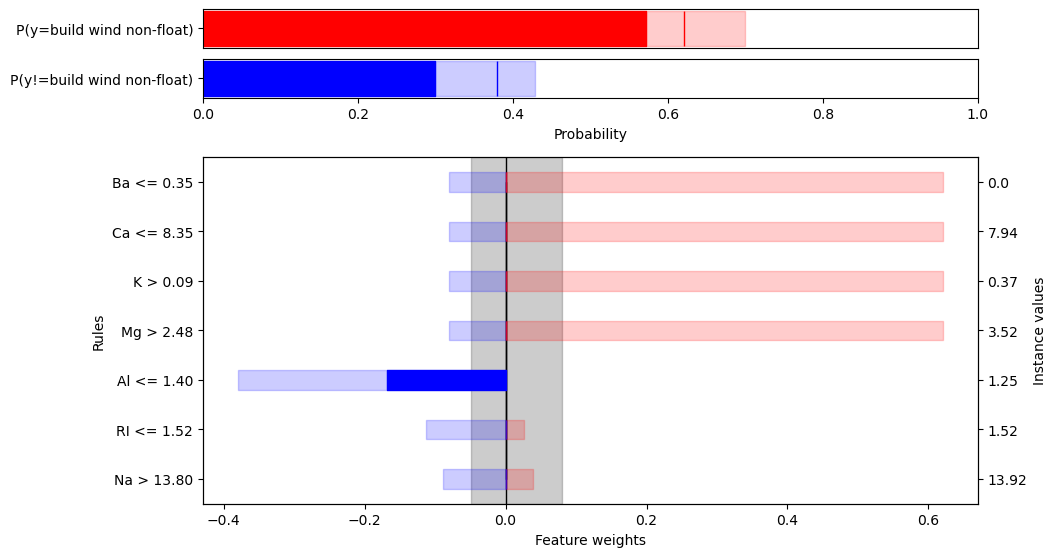

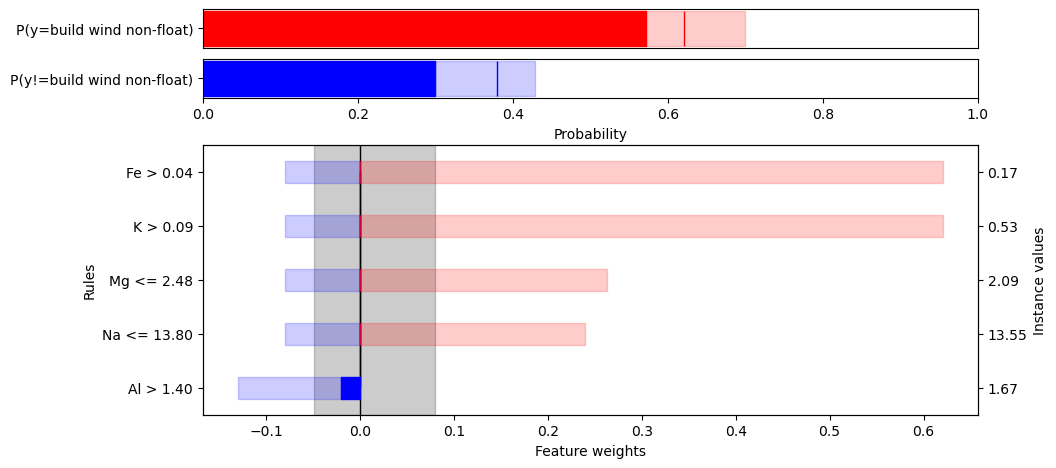

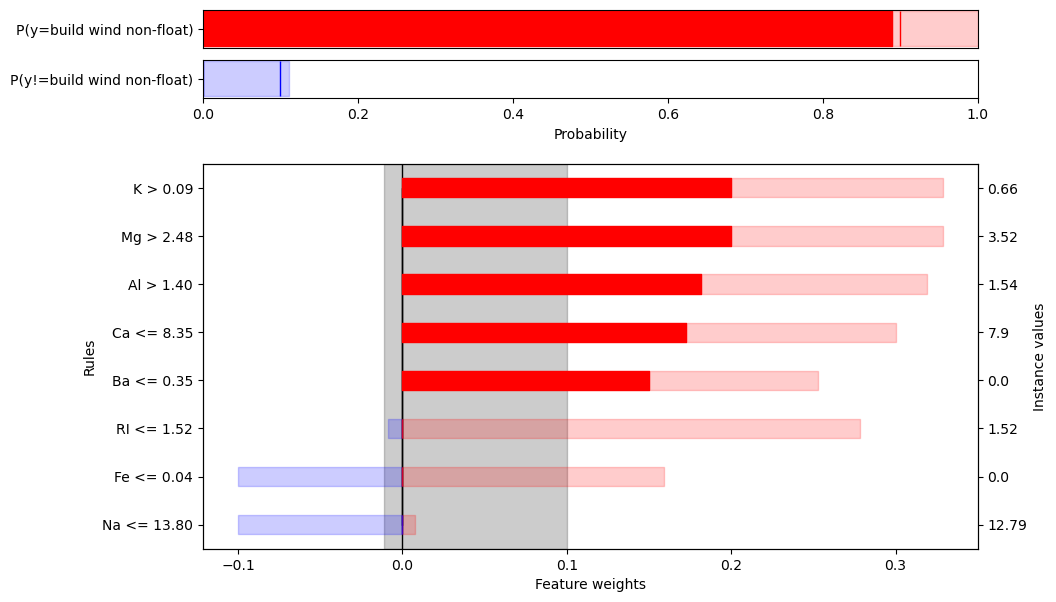

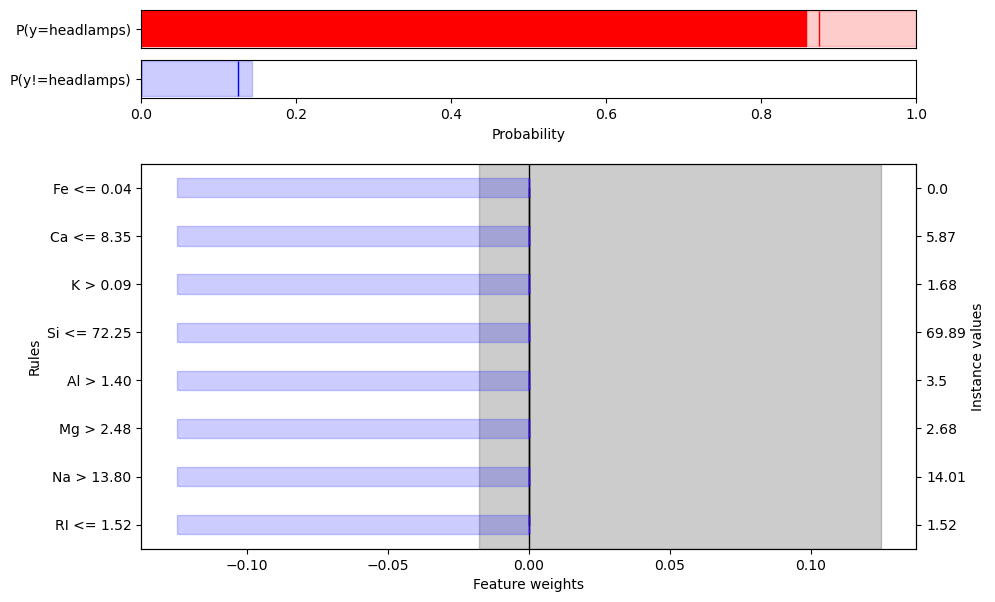

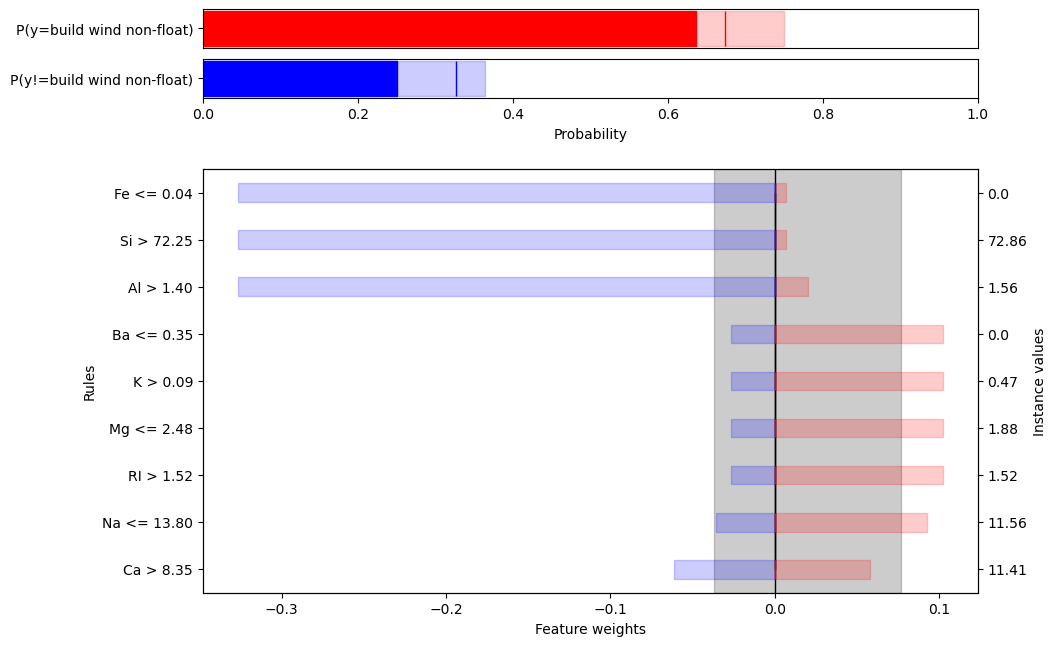

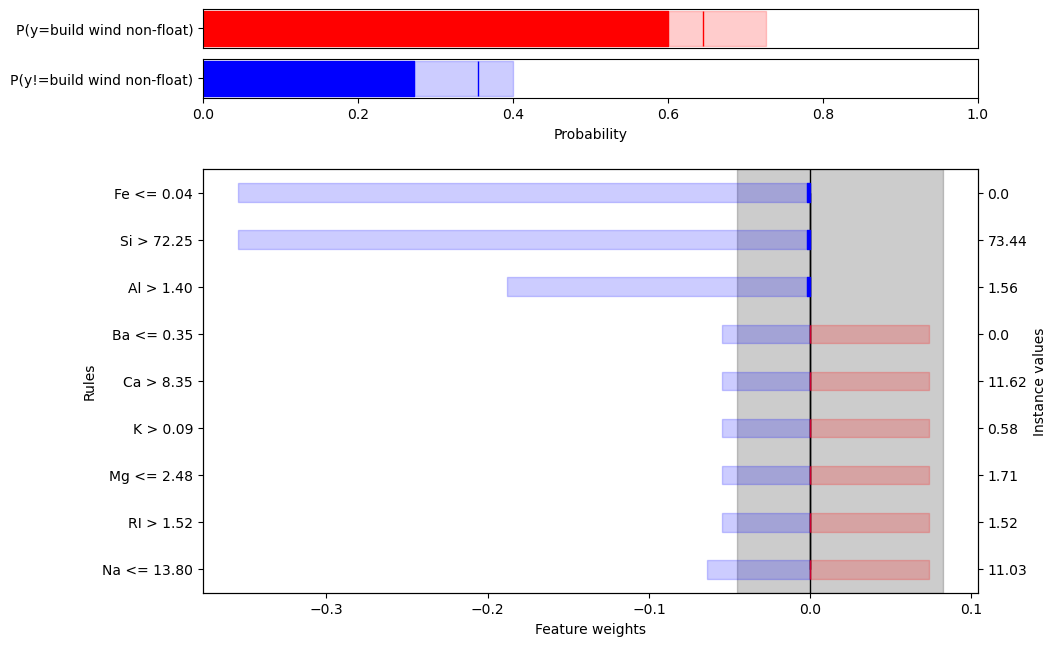

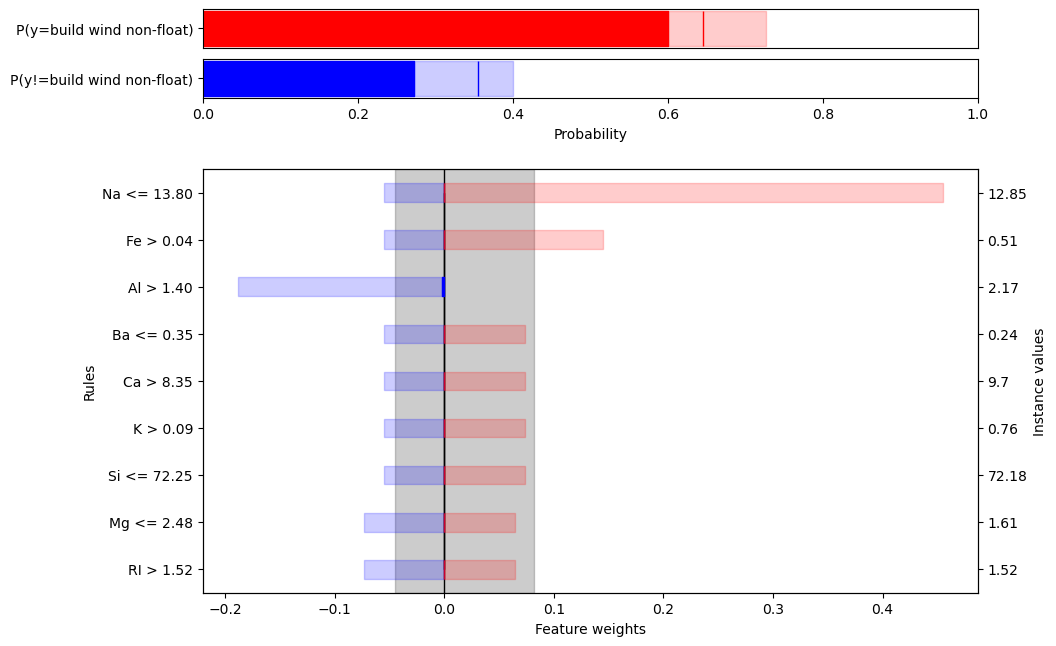

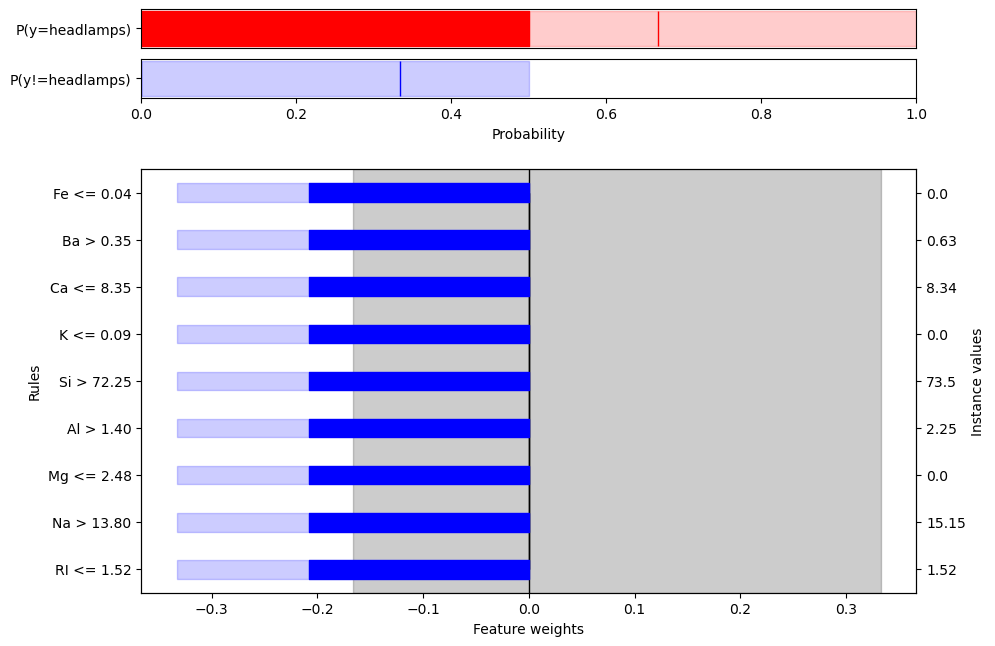

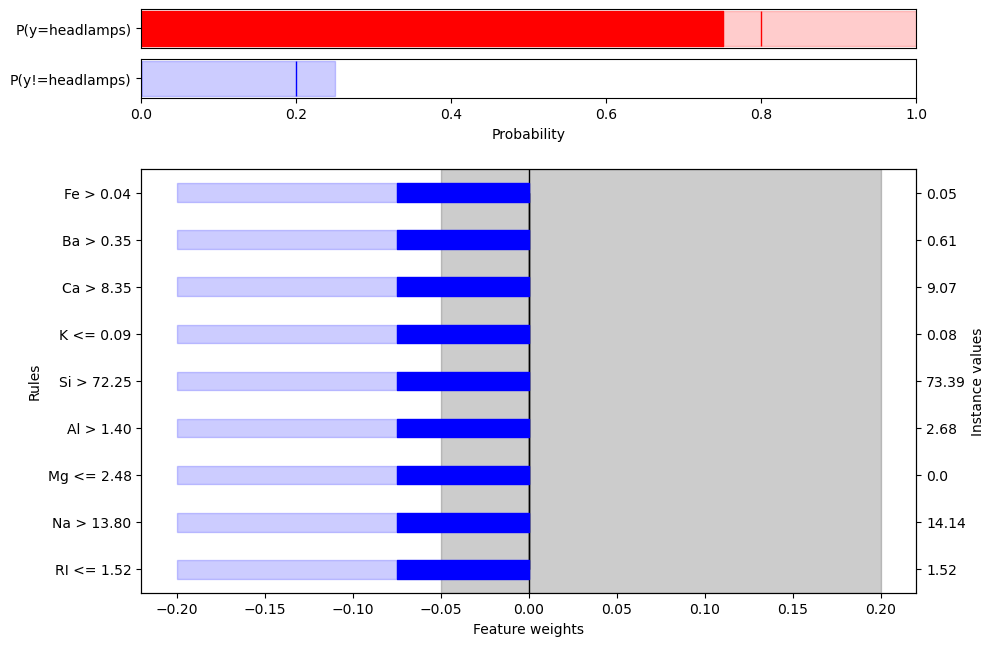

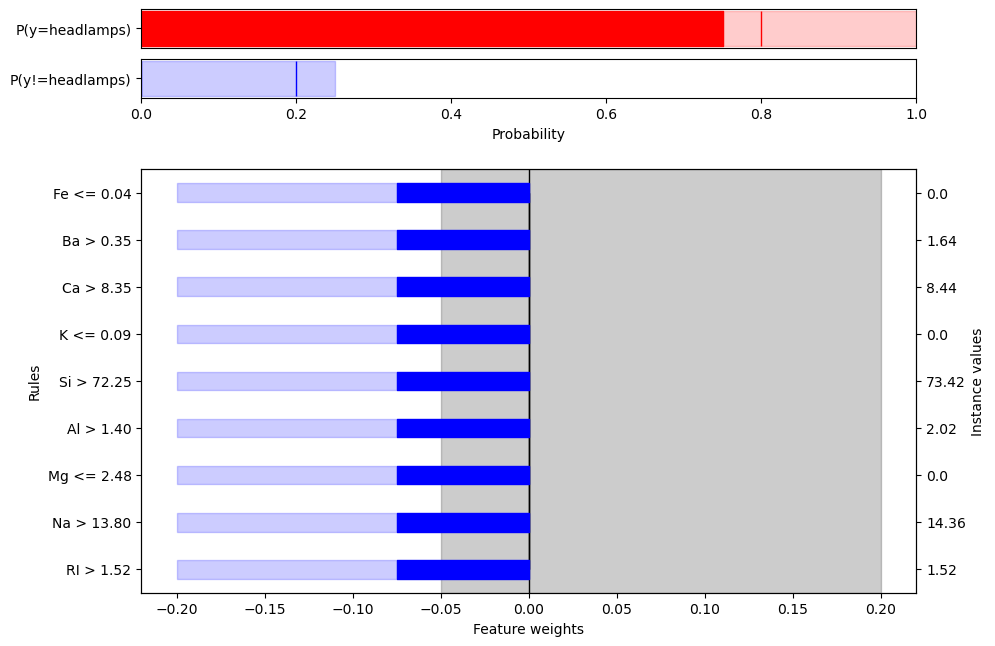

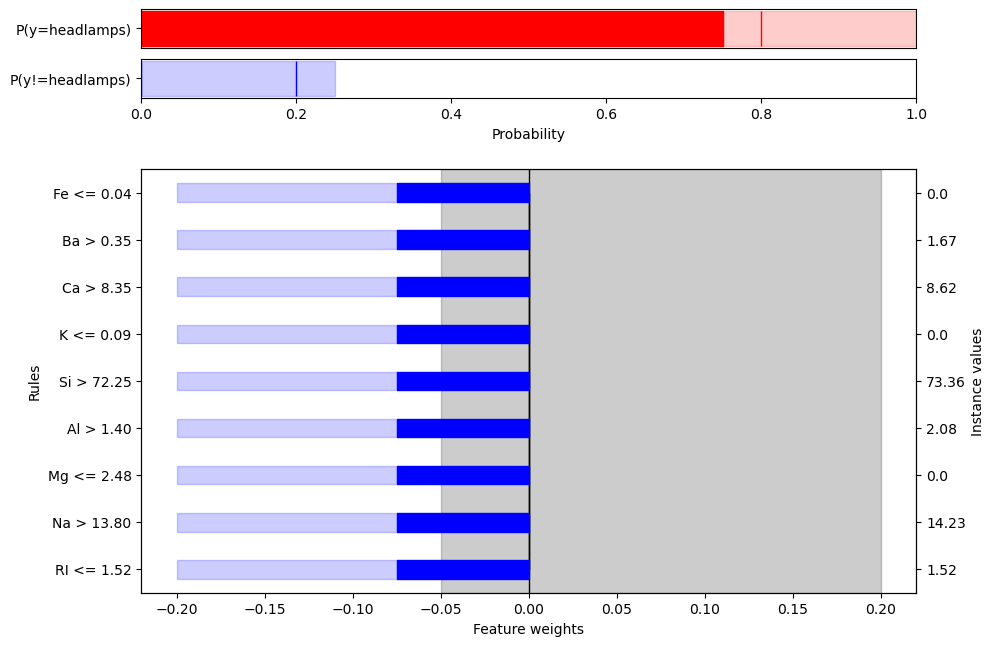

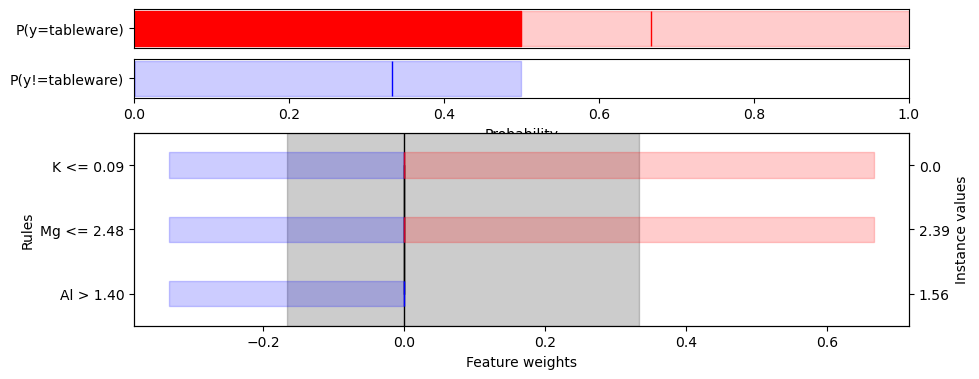

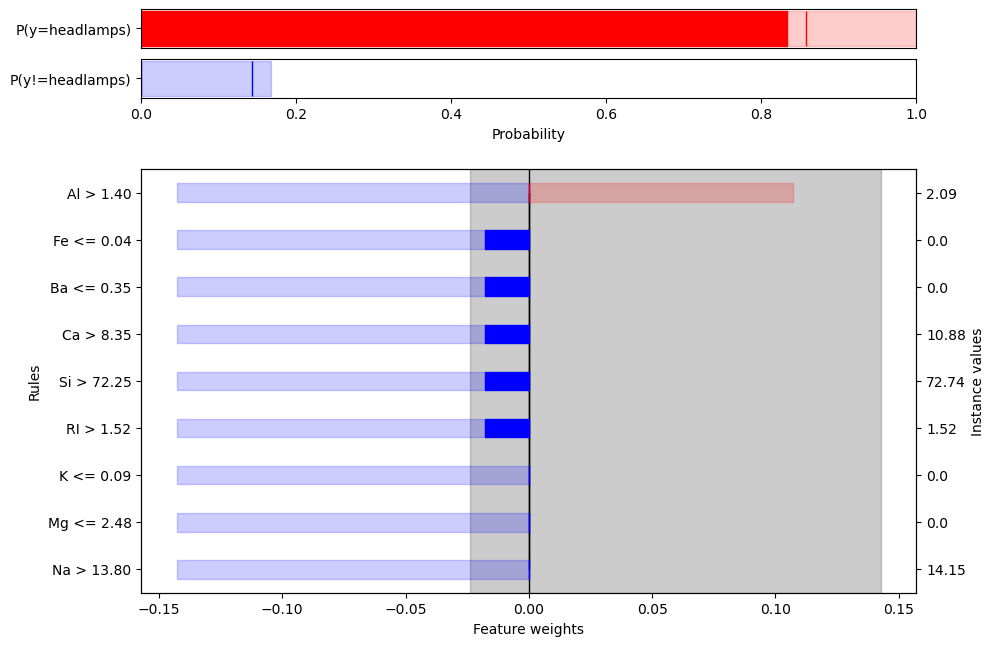

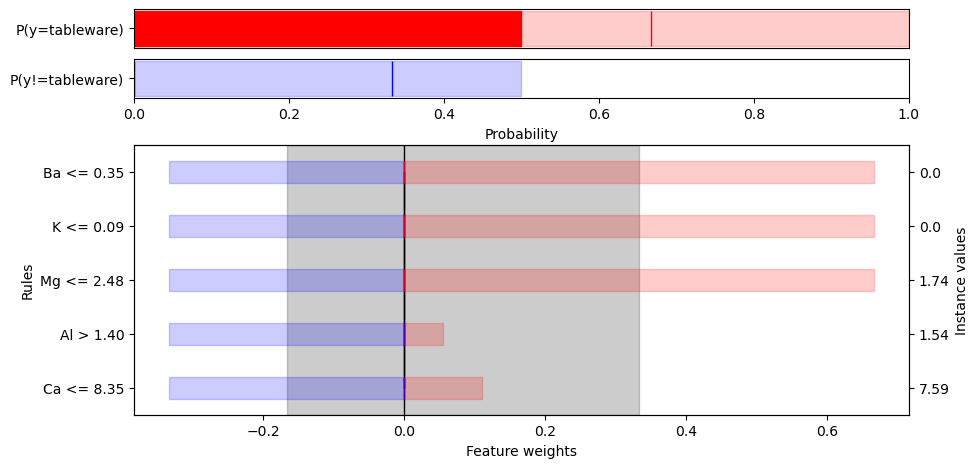

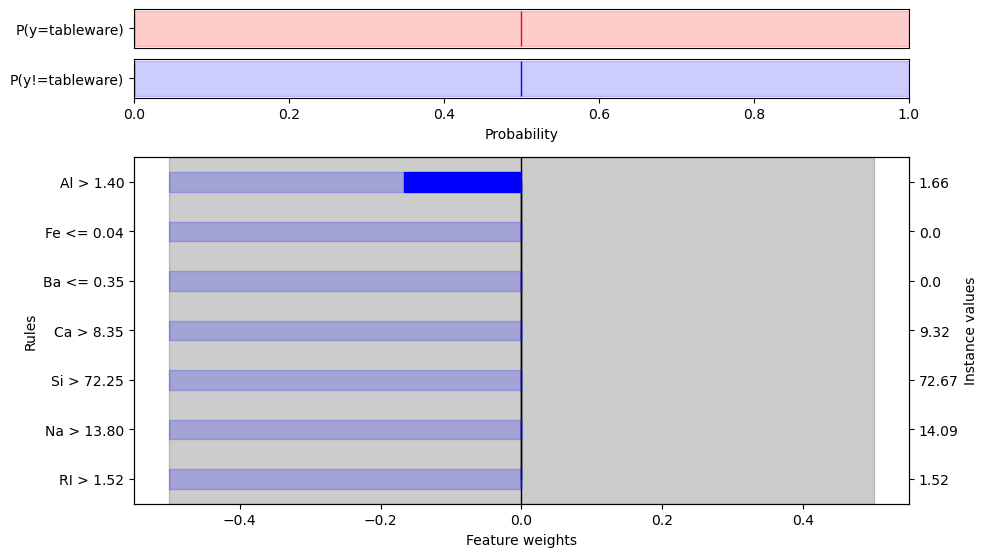

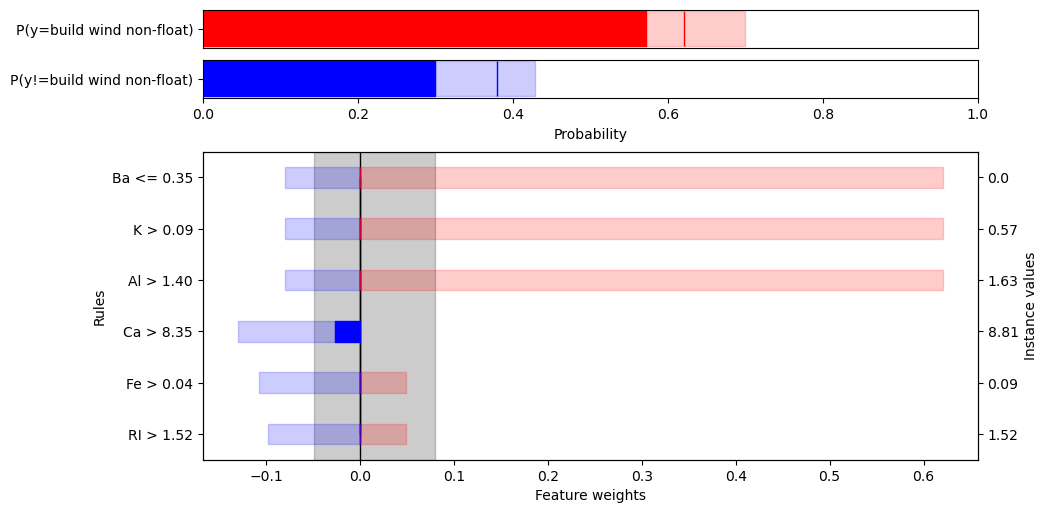

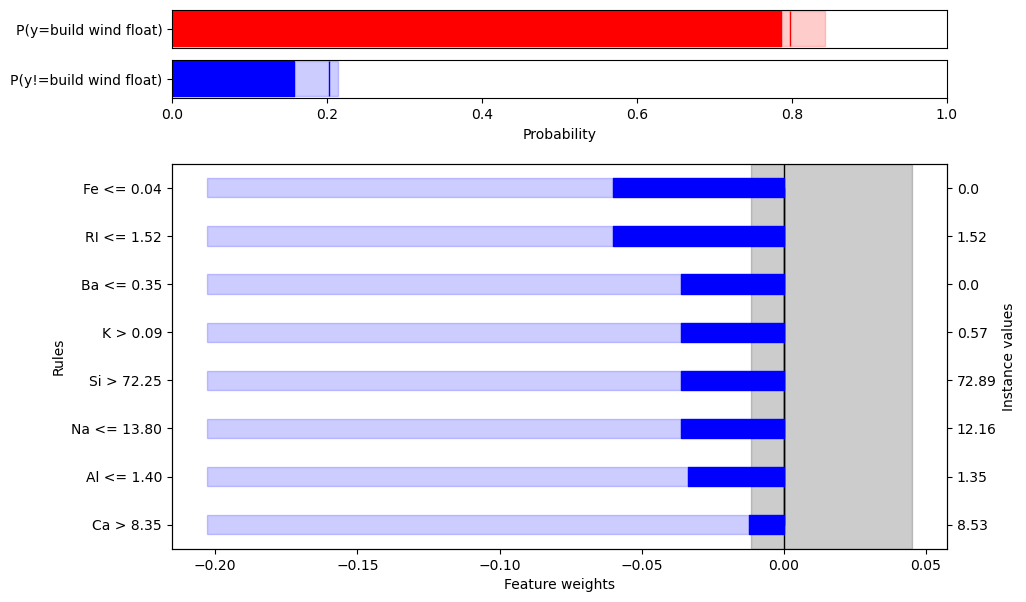

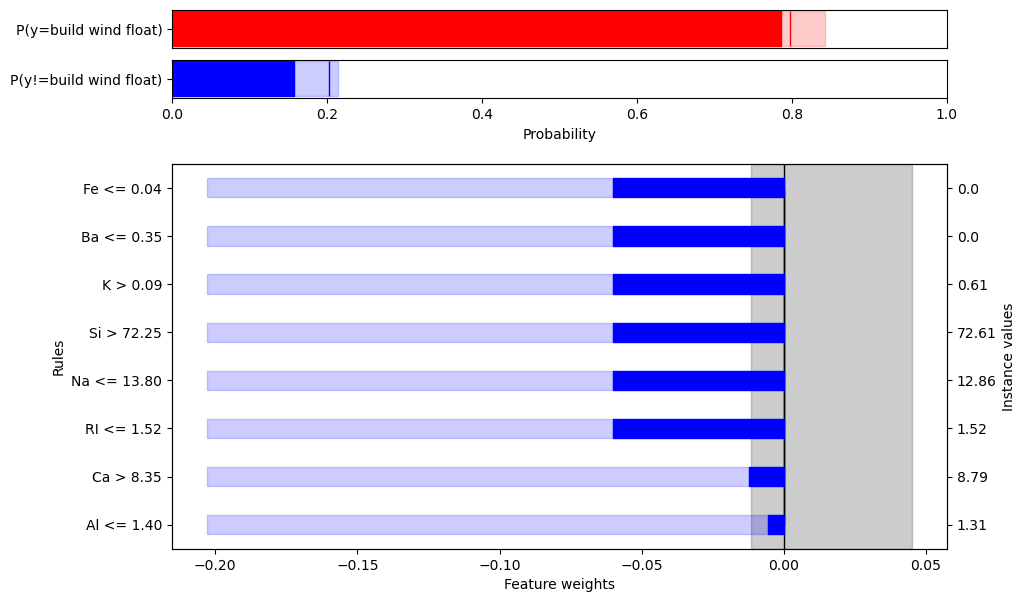

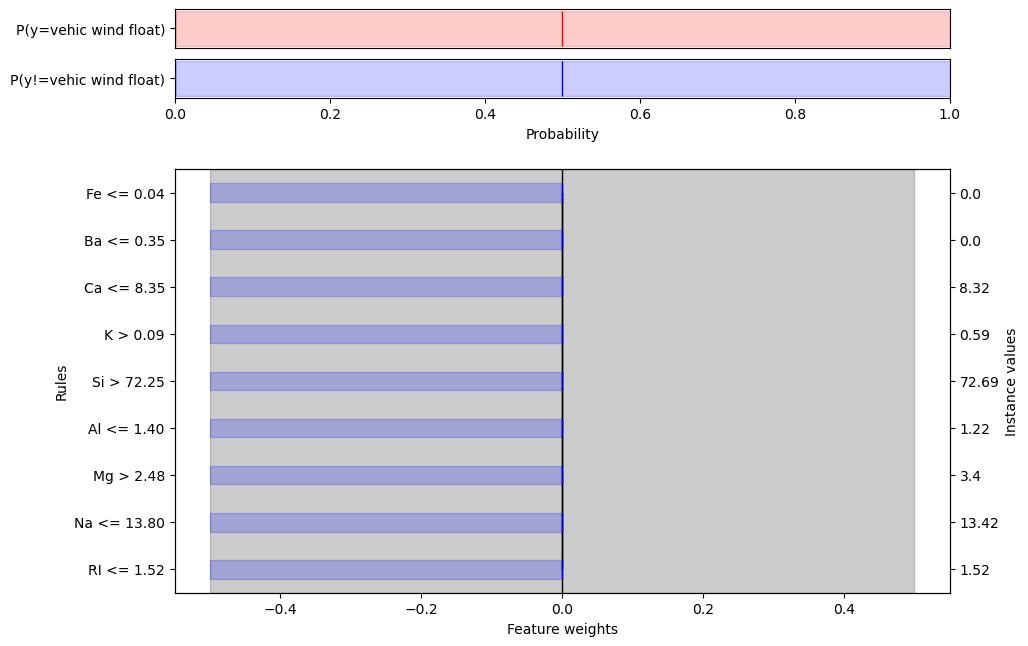

In [11]:
factual_explanation.plot_all(uncertainty=True)

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\_explanations.py:950: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,num_to_show*.5+2))


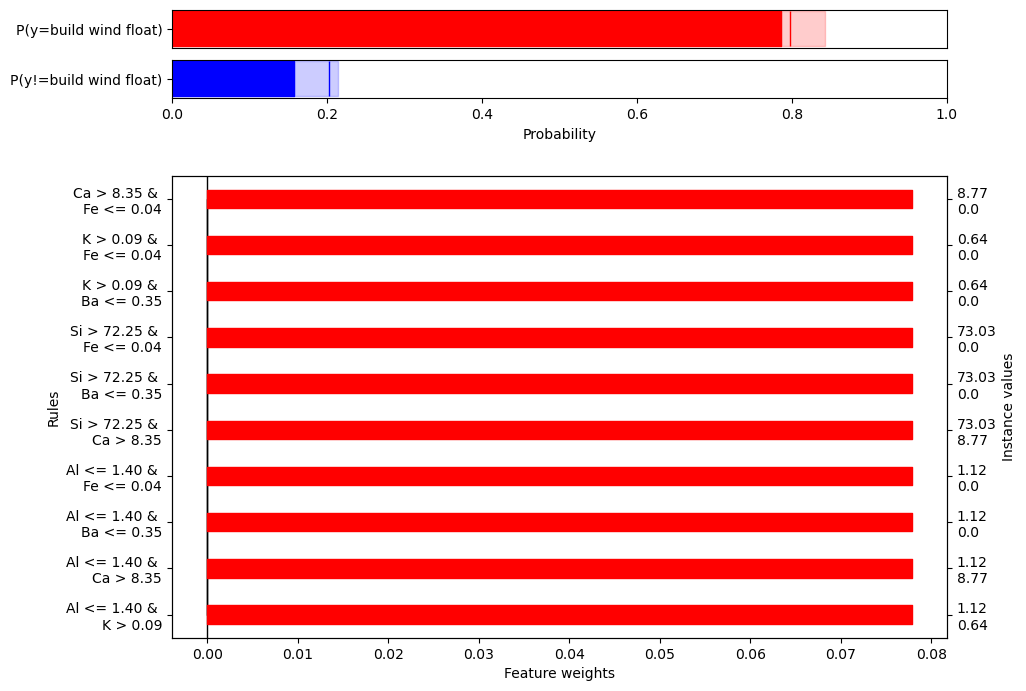

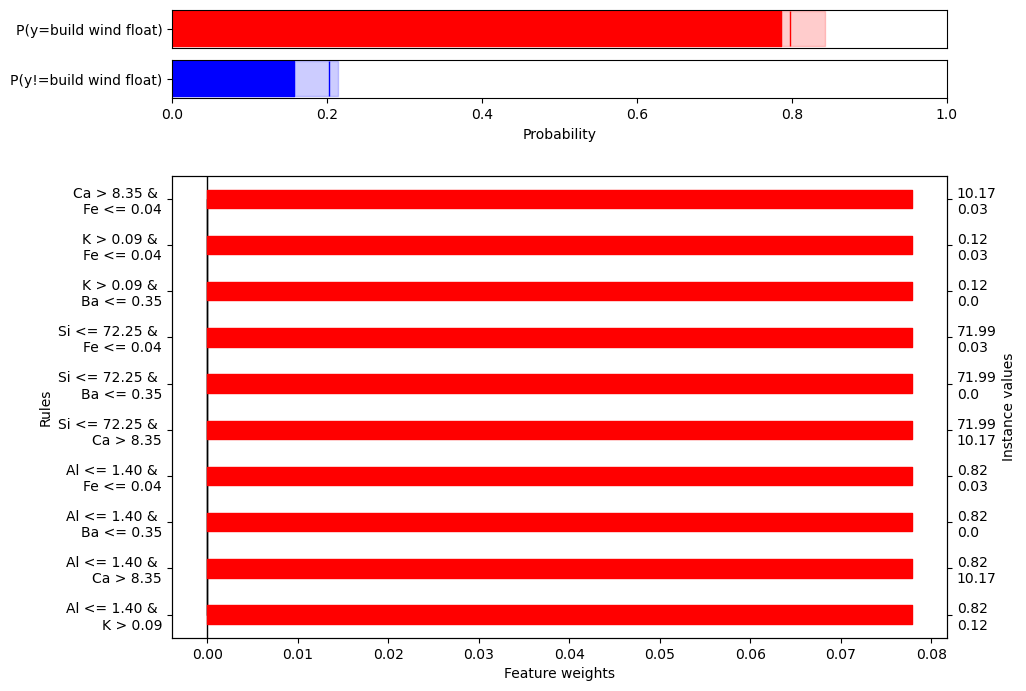

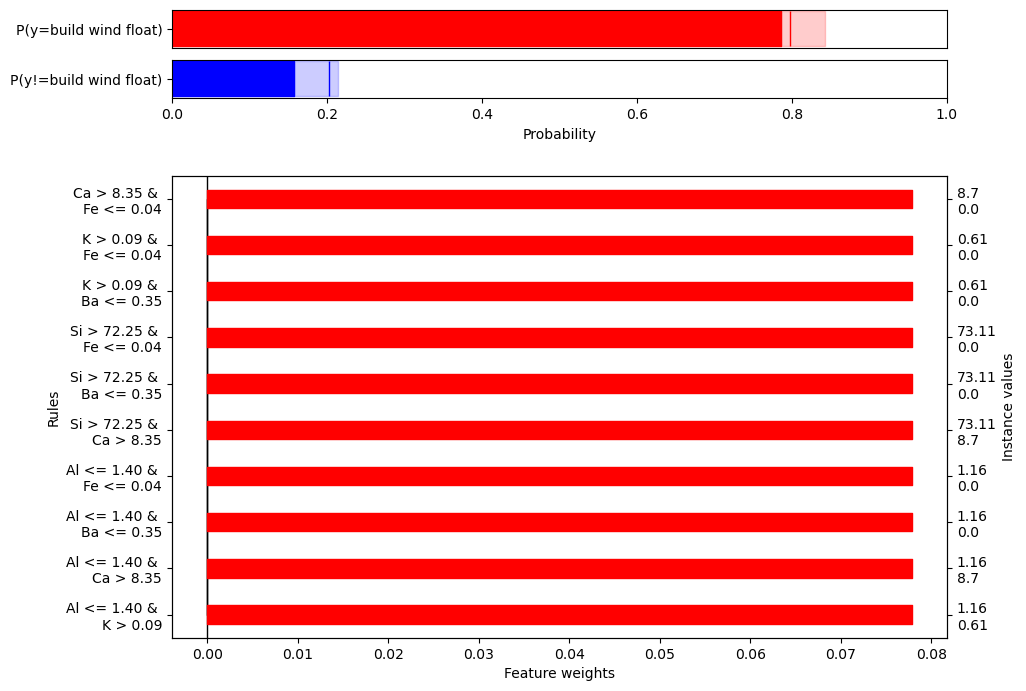

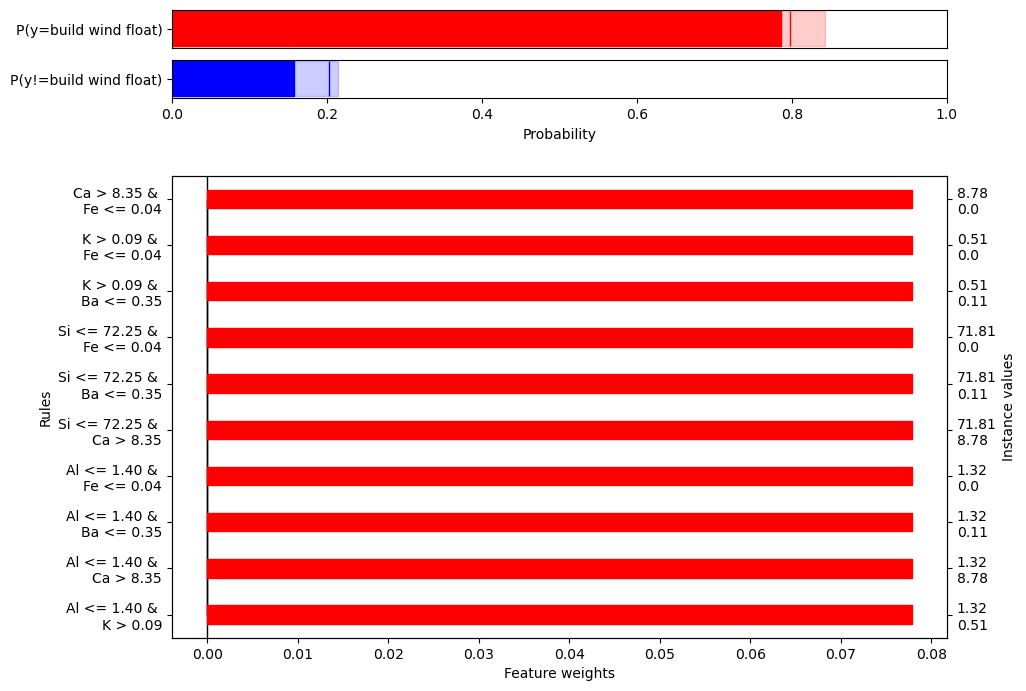

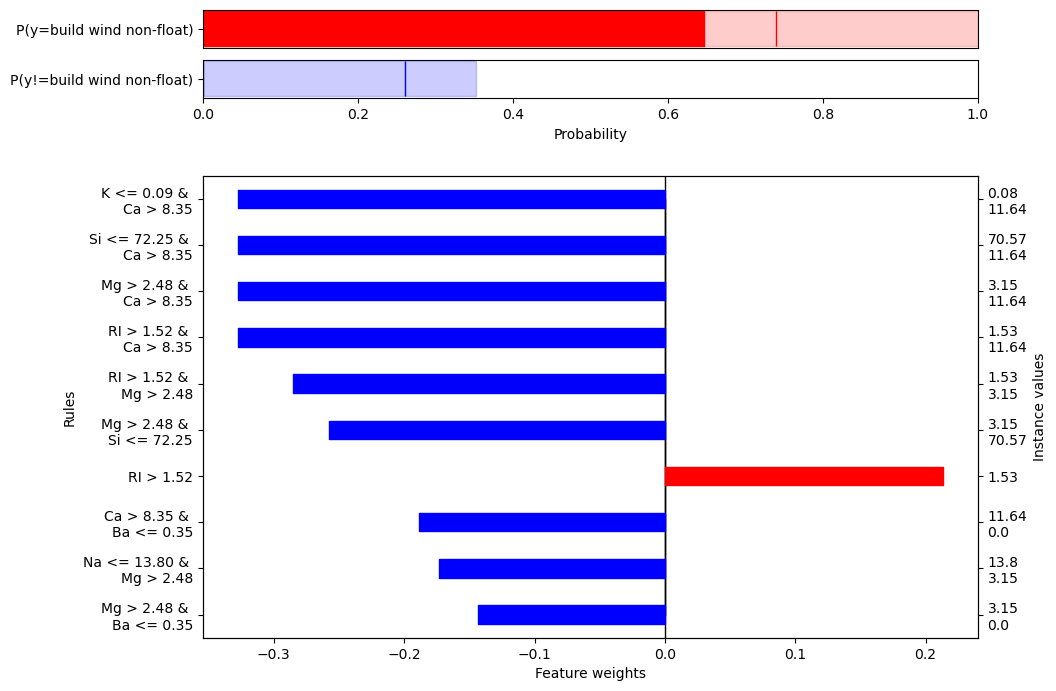

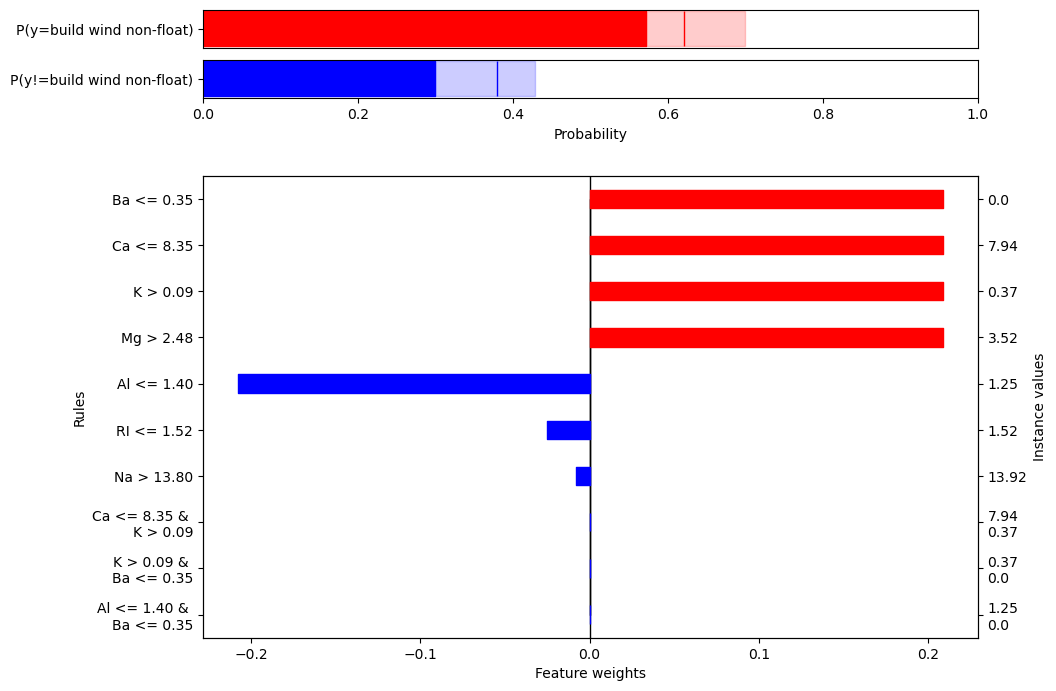

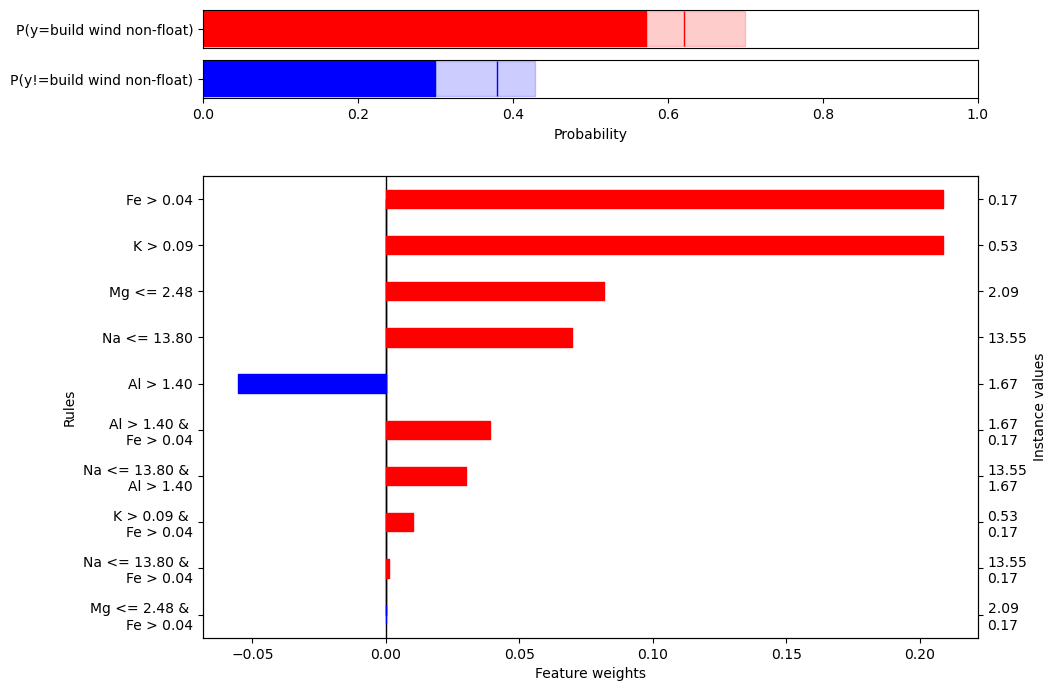

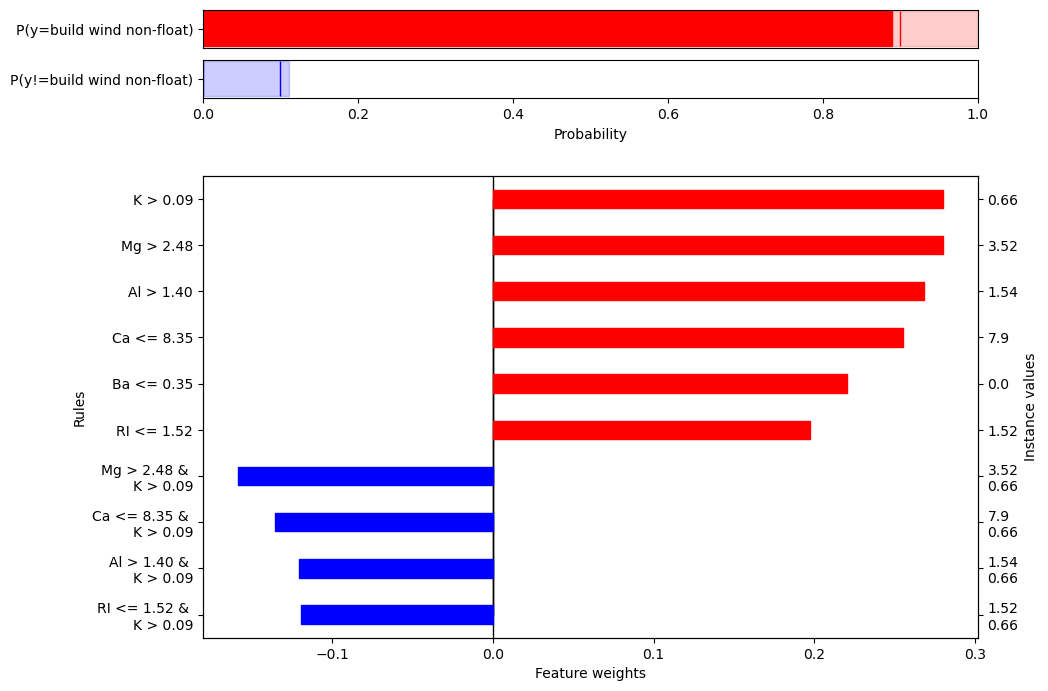

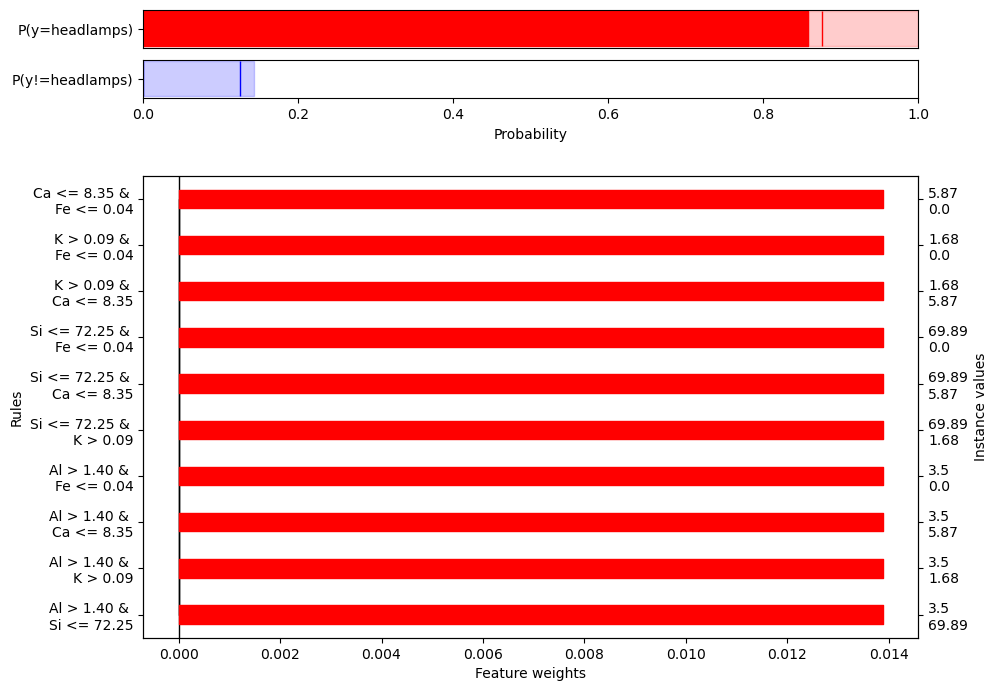

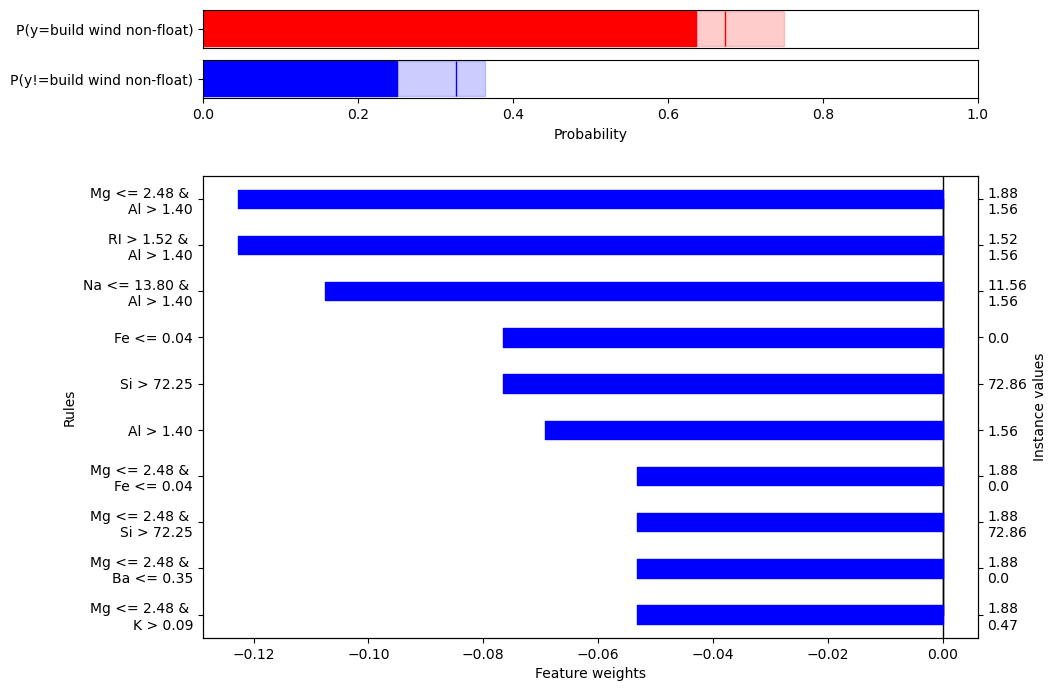

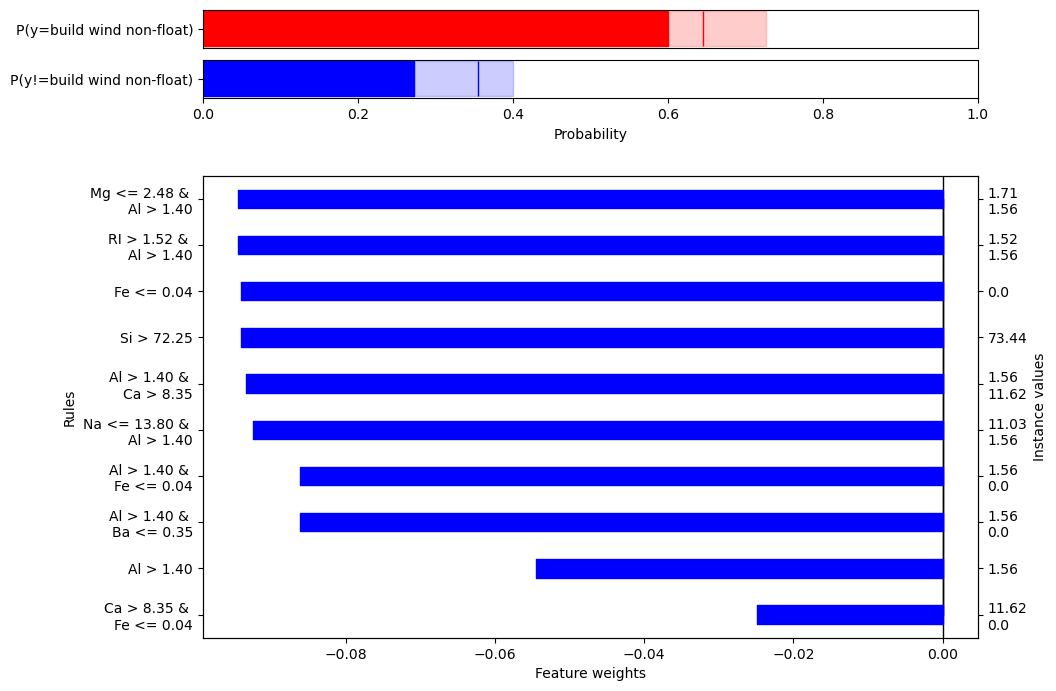

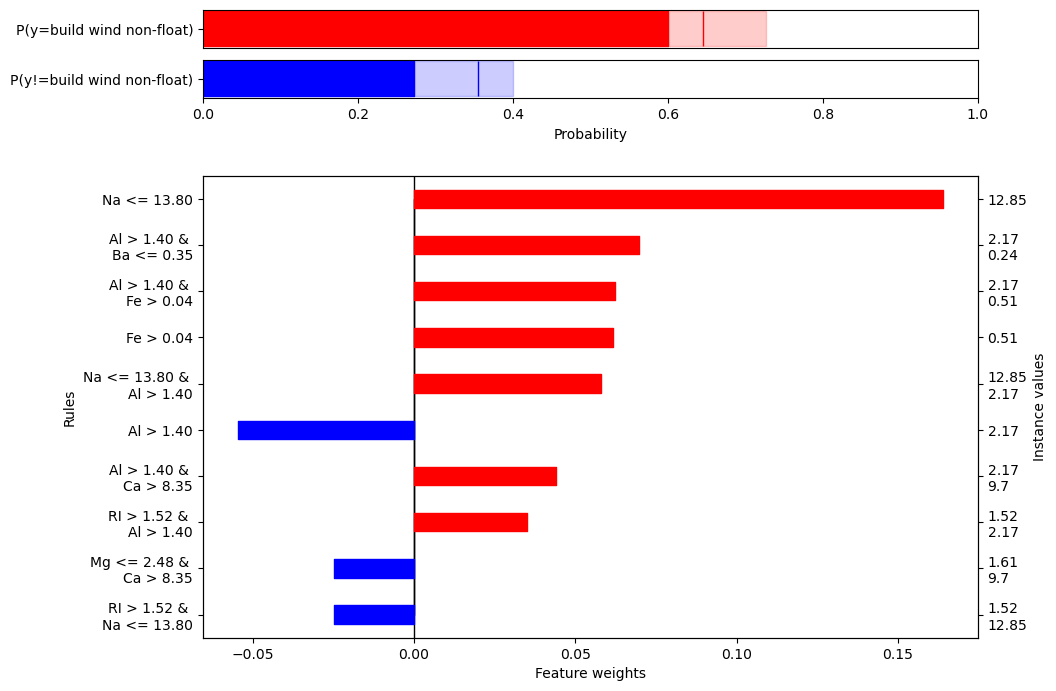

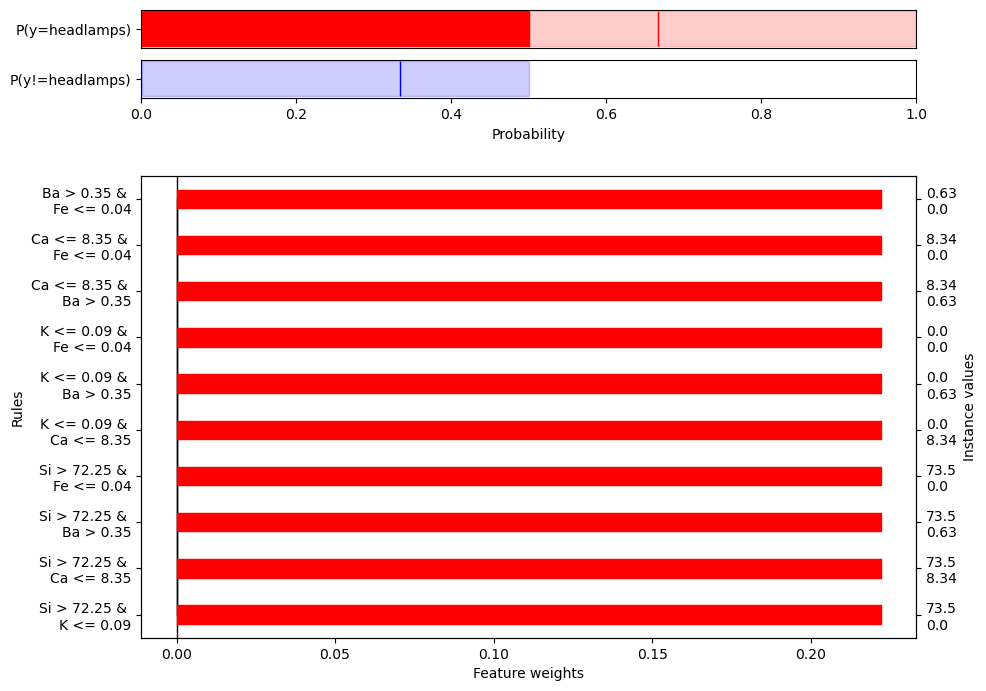

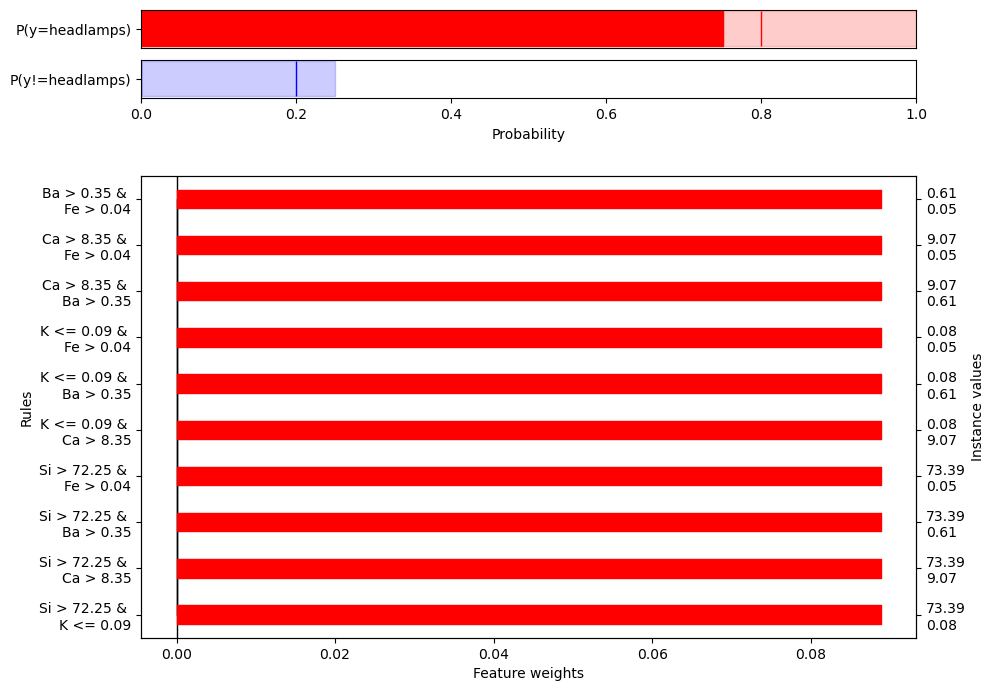

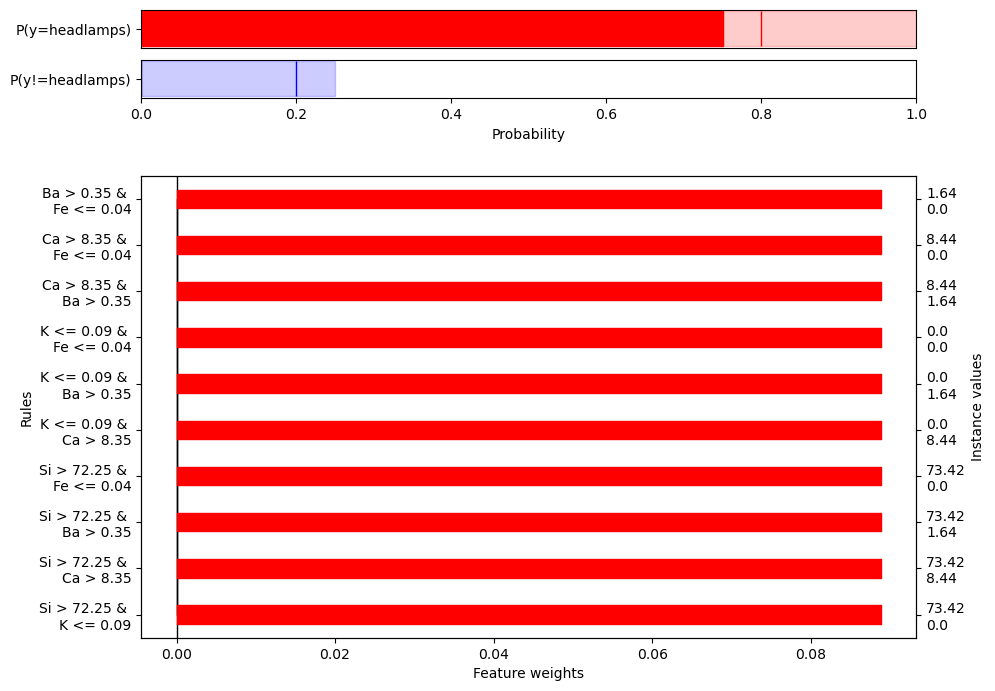

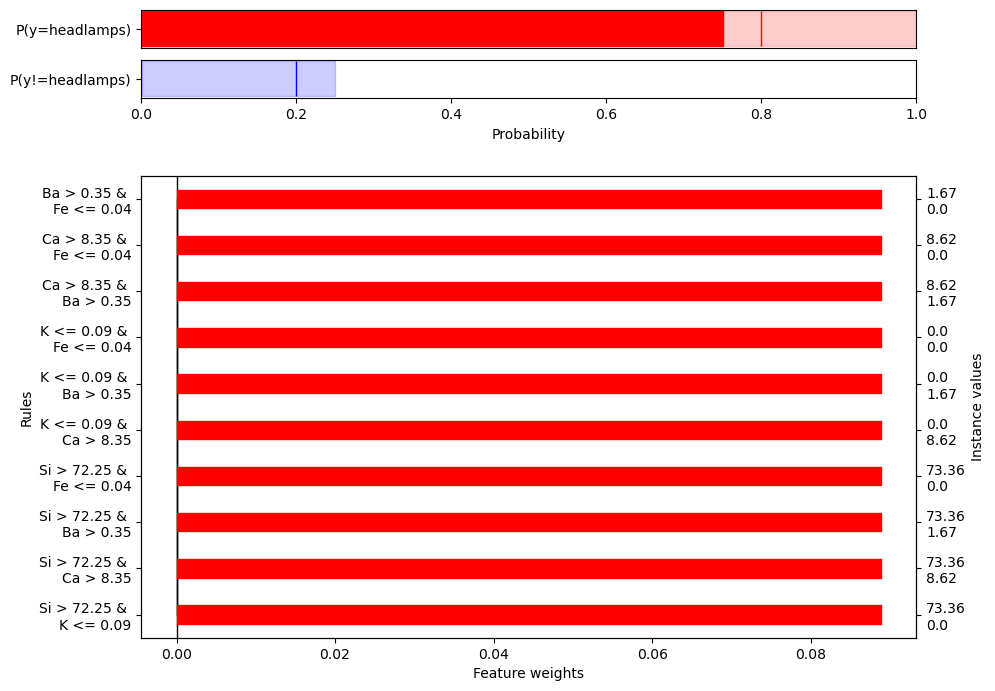

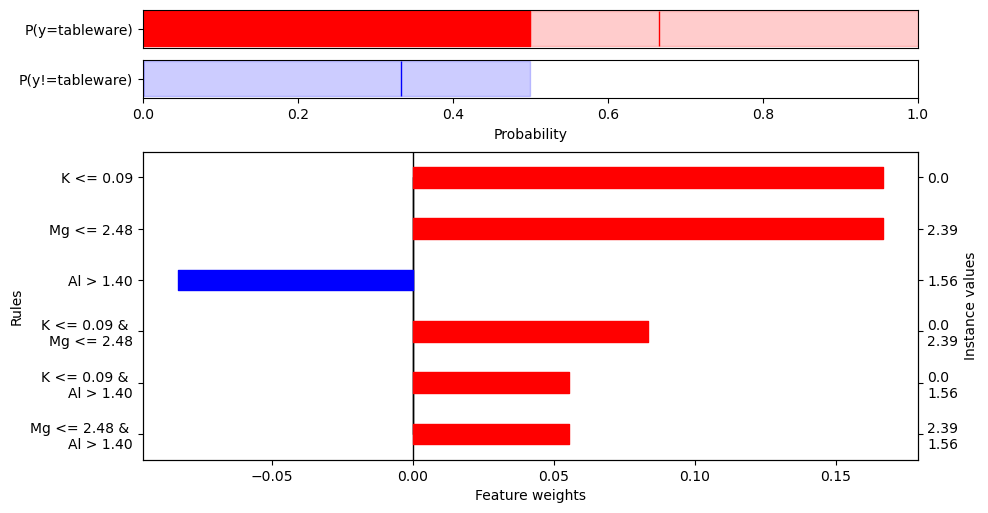

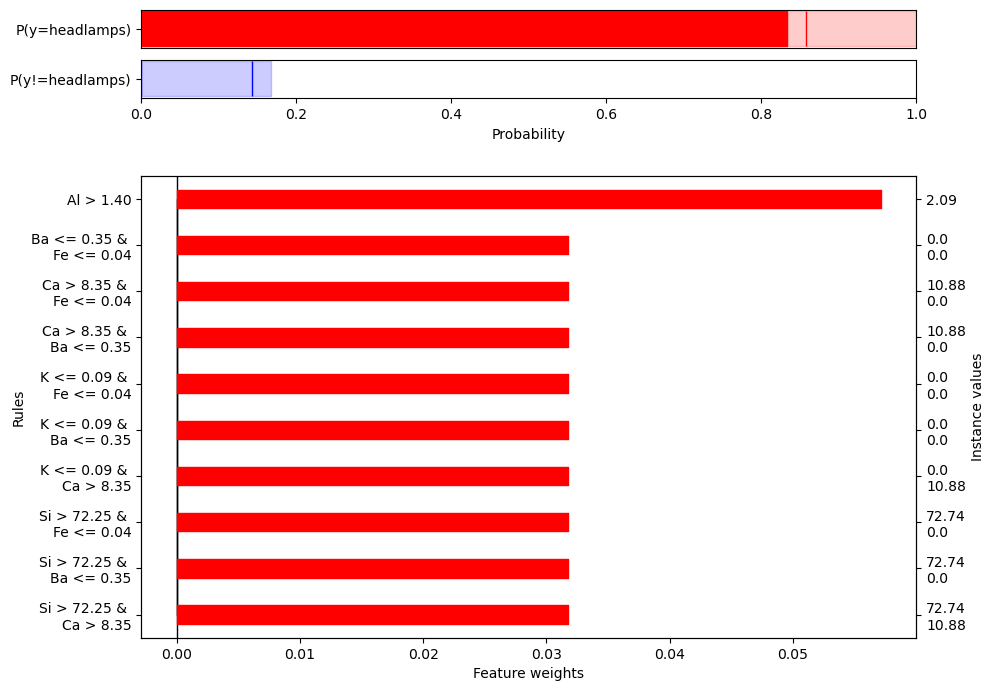

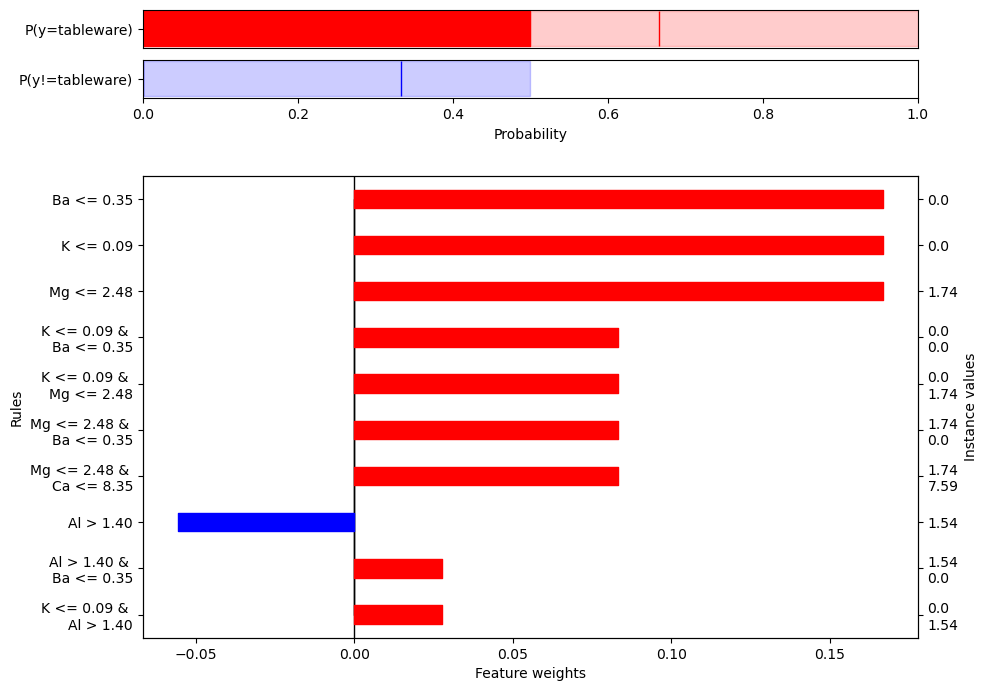

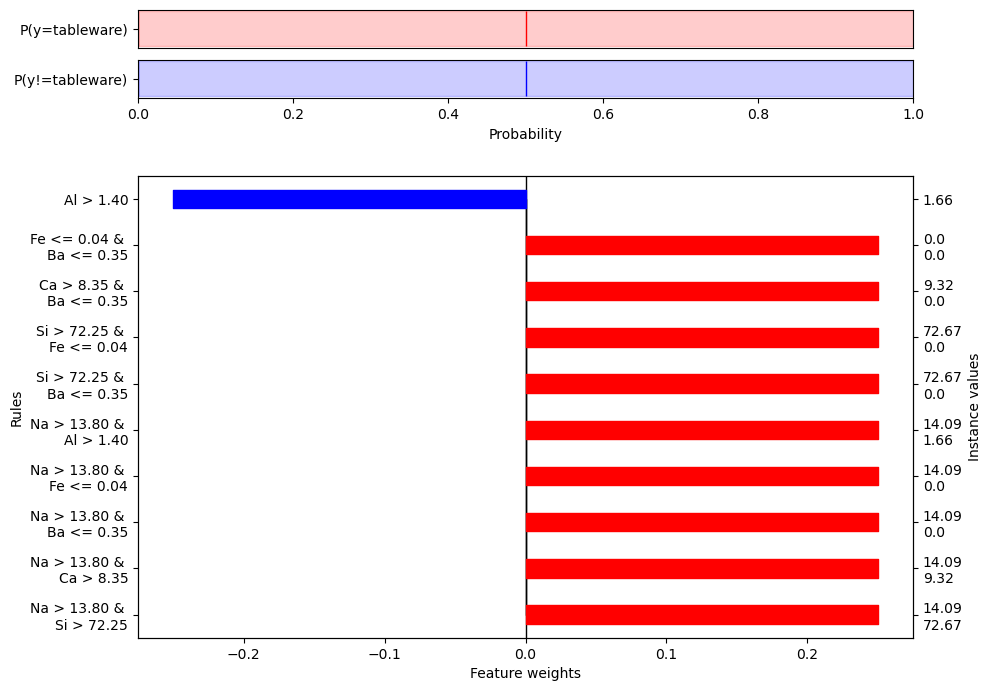

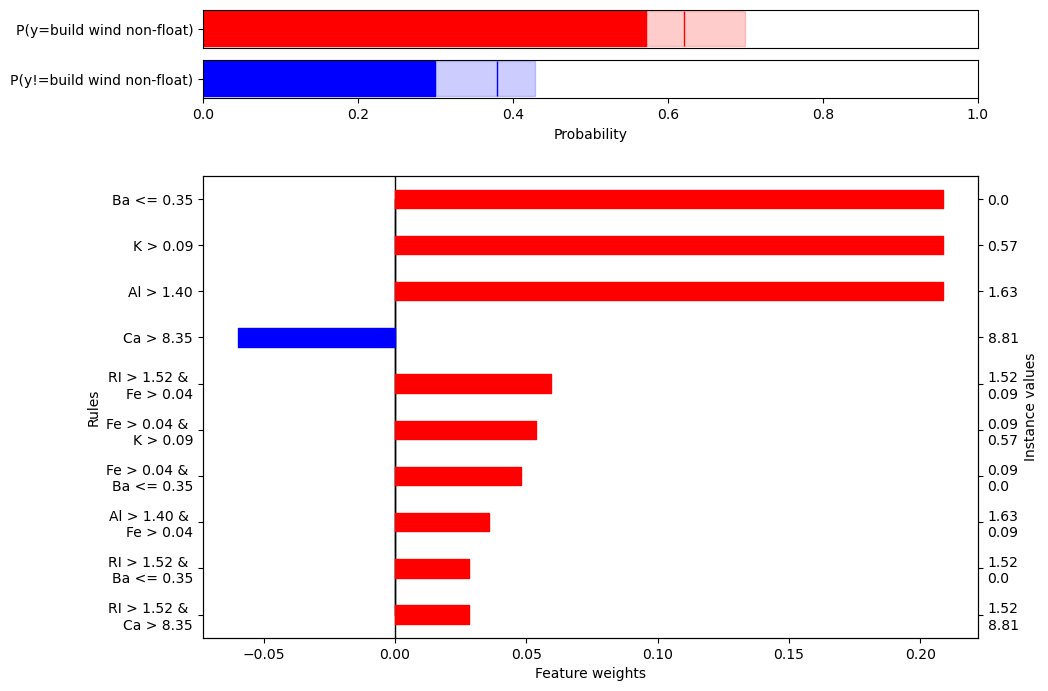

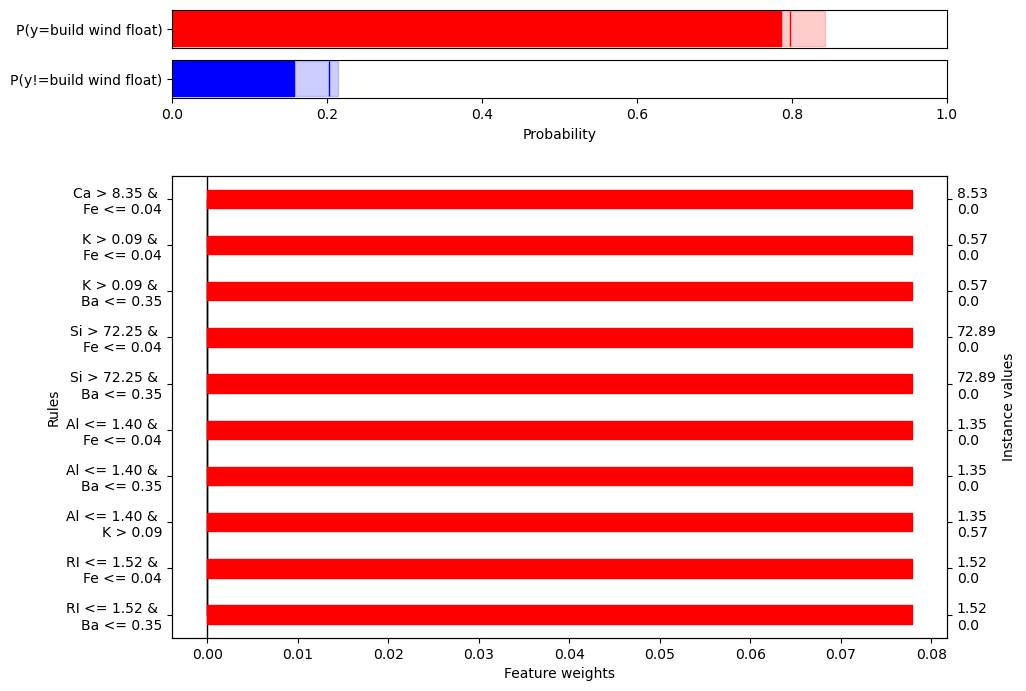

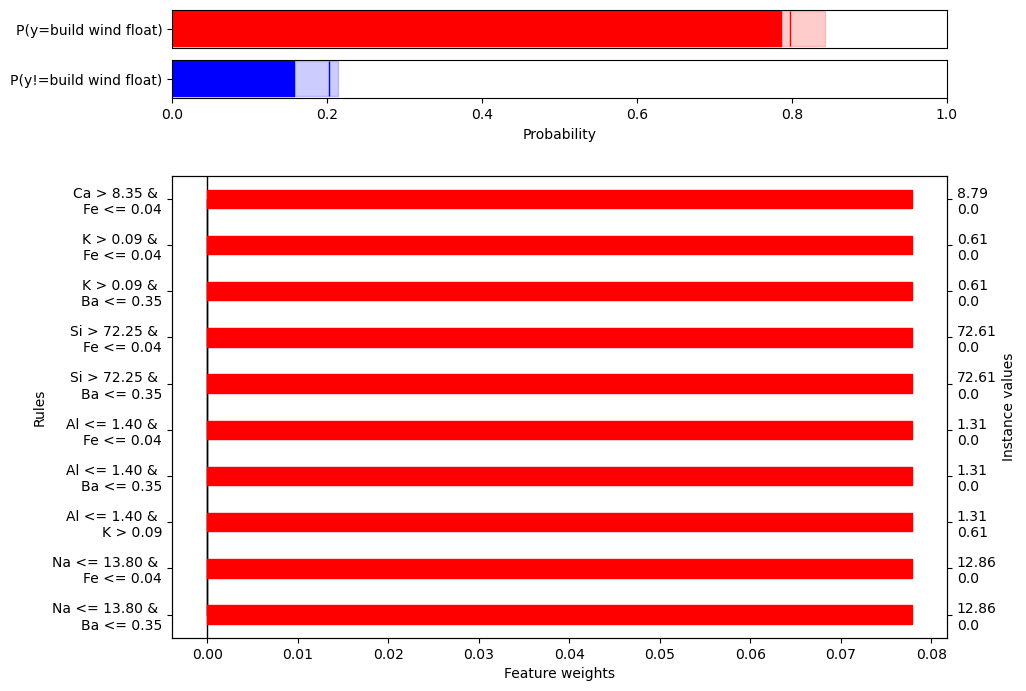

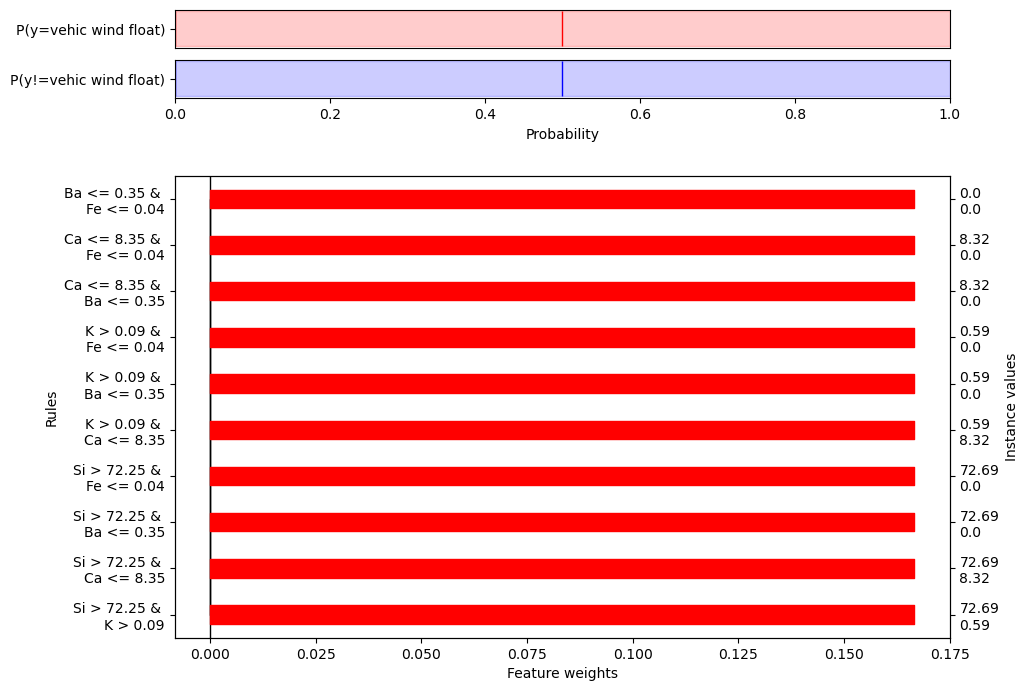

In [12]:
factual_explanation.add_conjunctions().plot_all()

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\_explanations.py:950: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,num_to_show*.5+2))


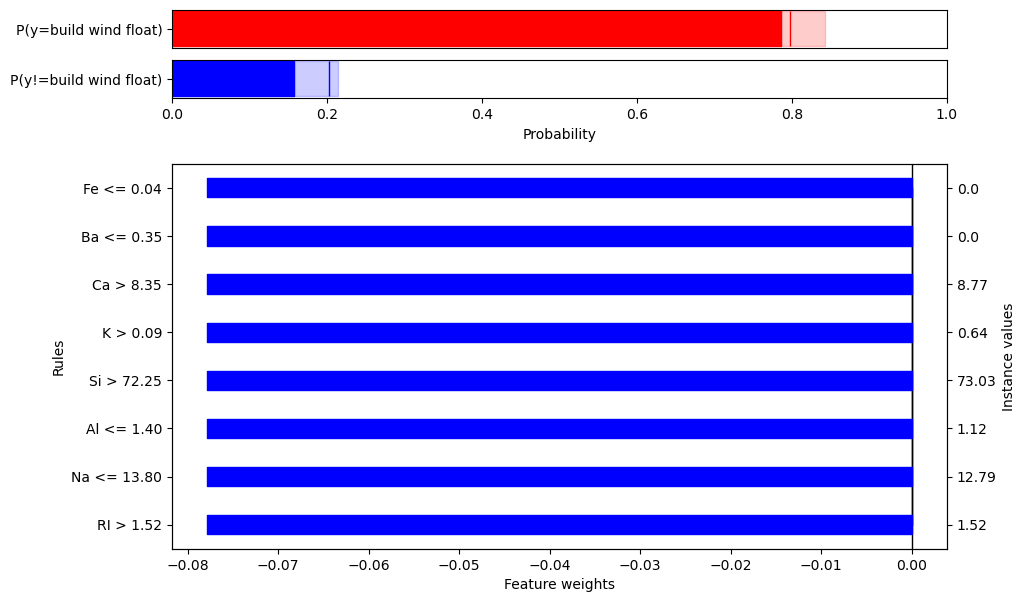

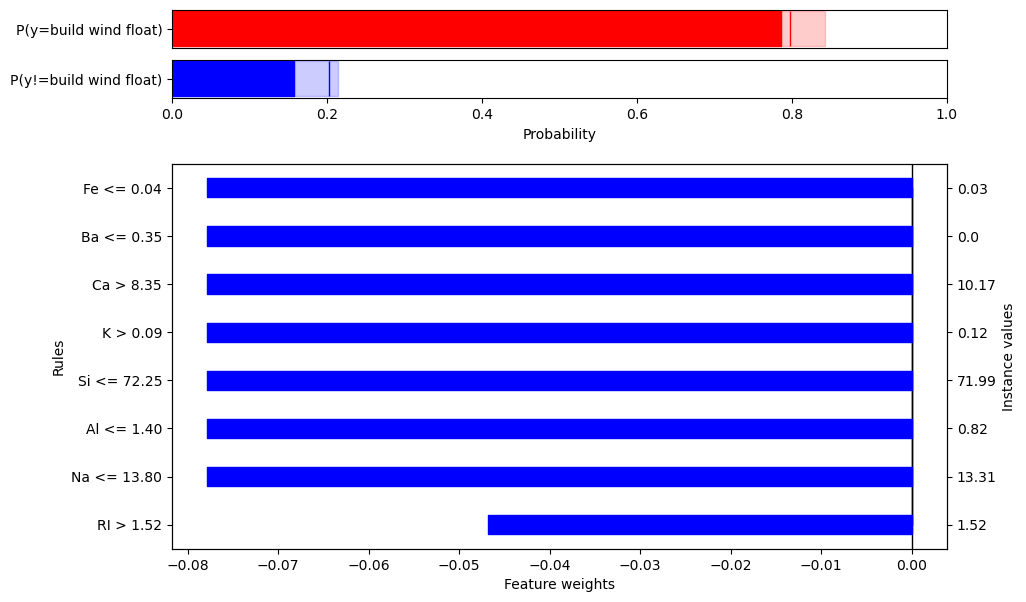

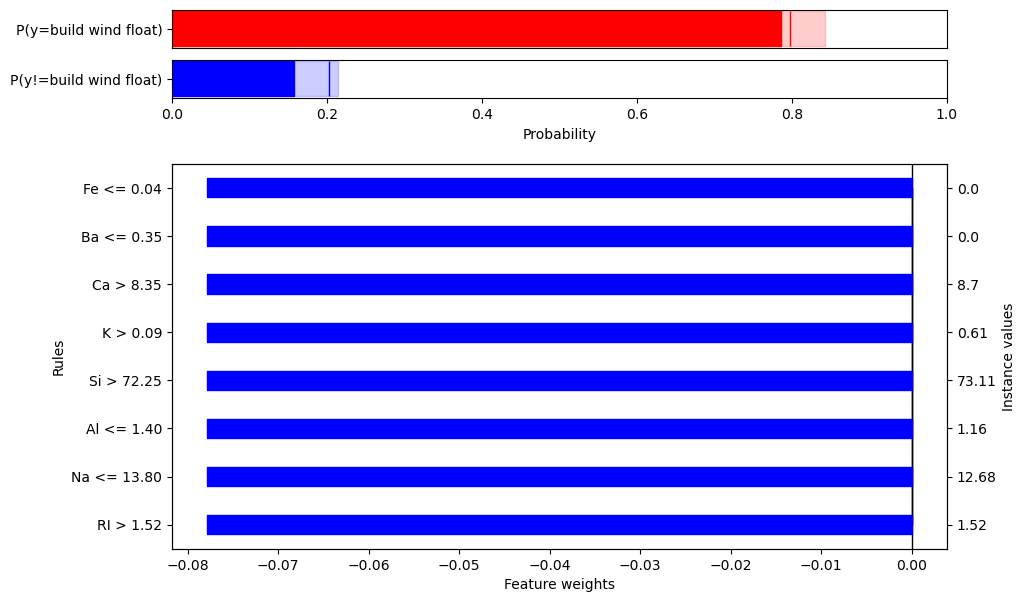

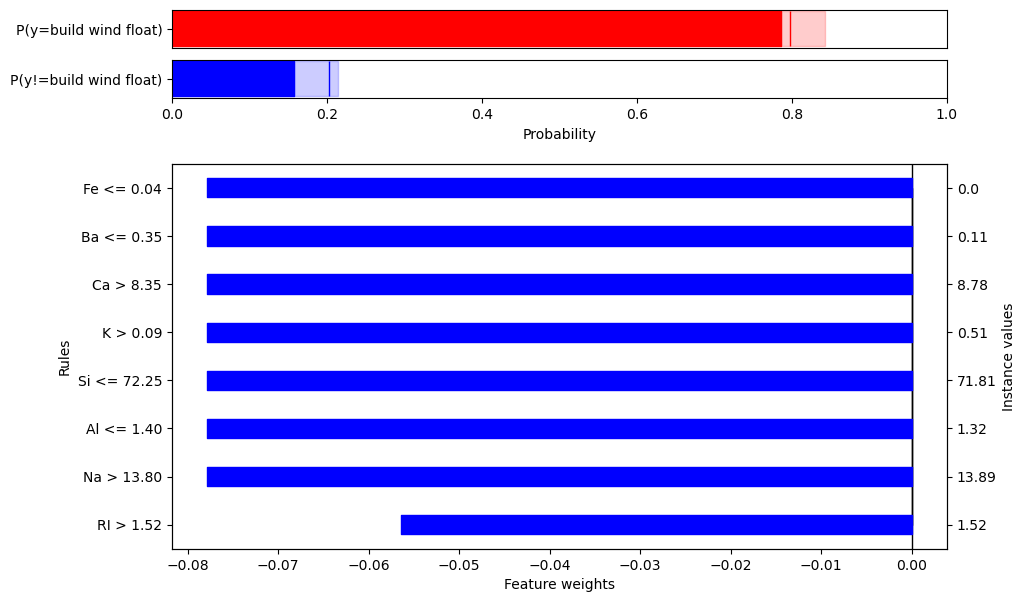

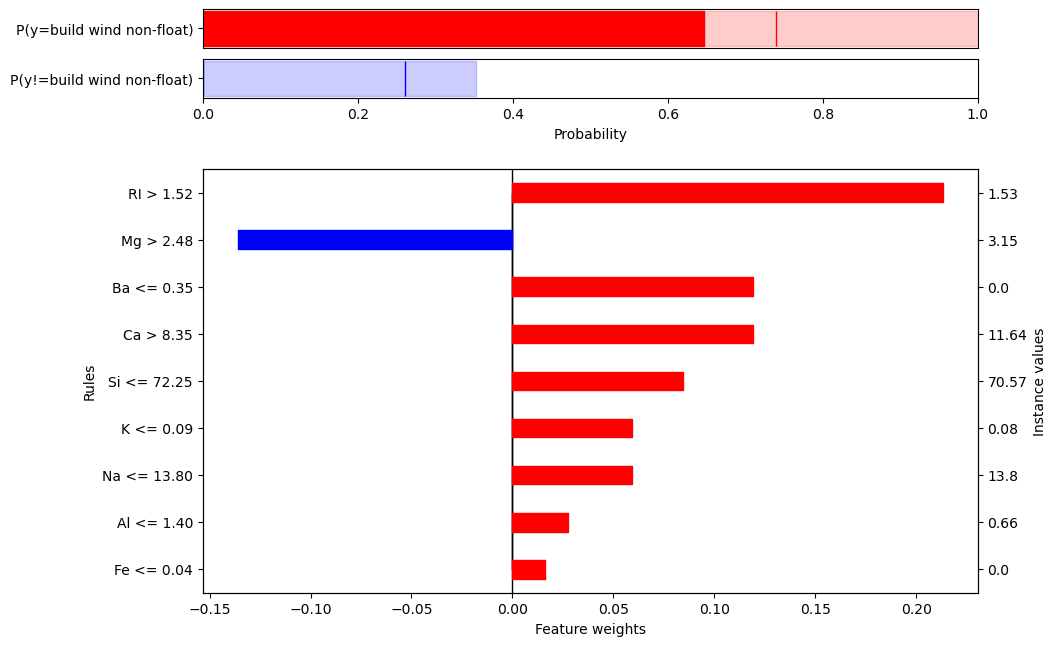

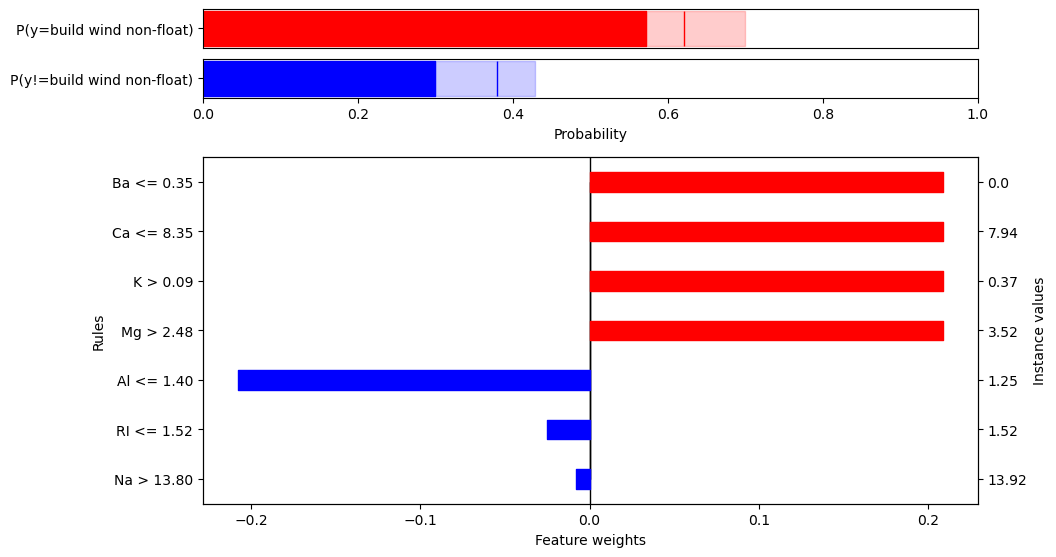

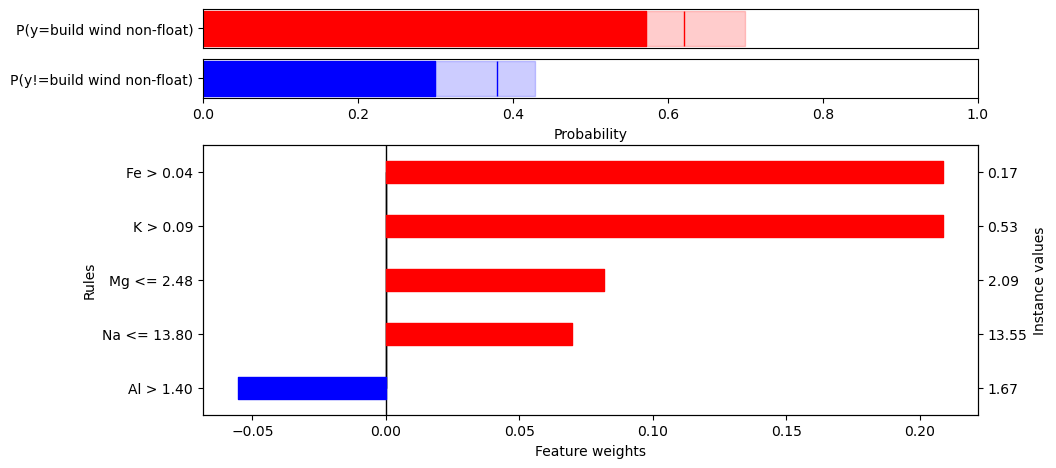

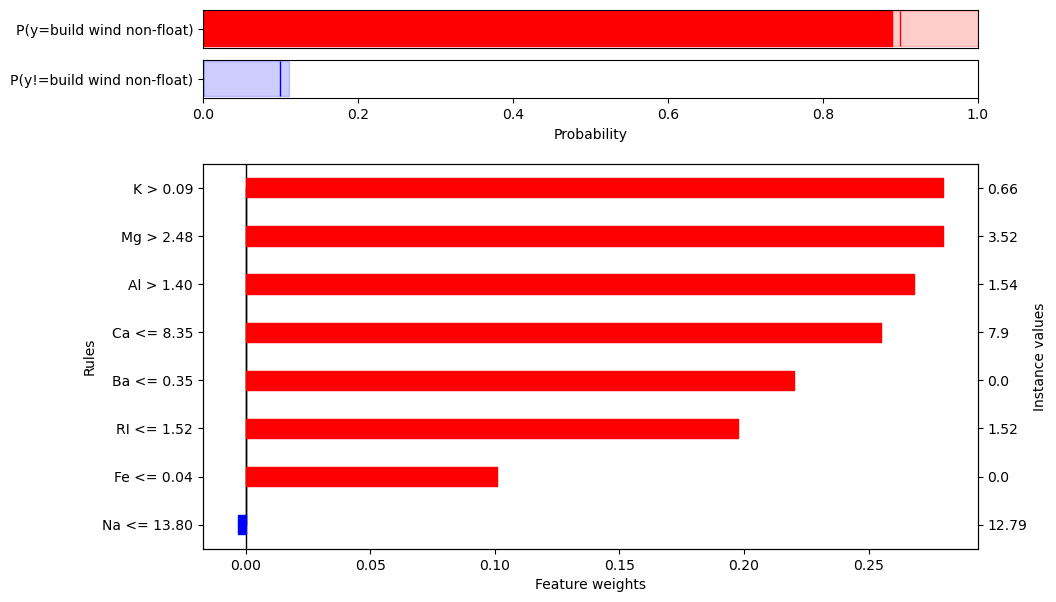

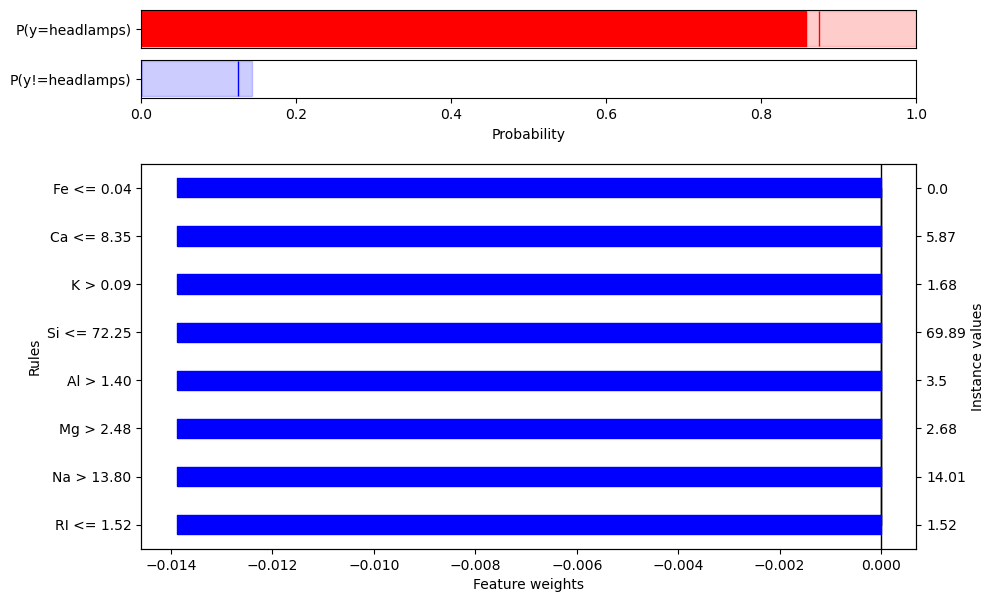

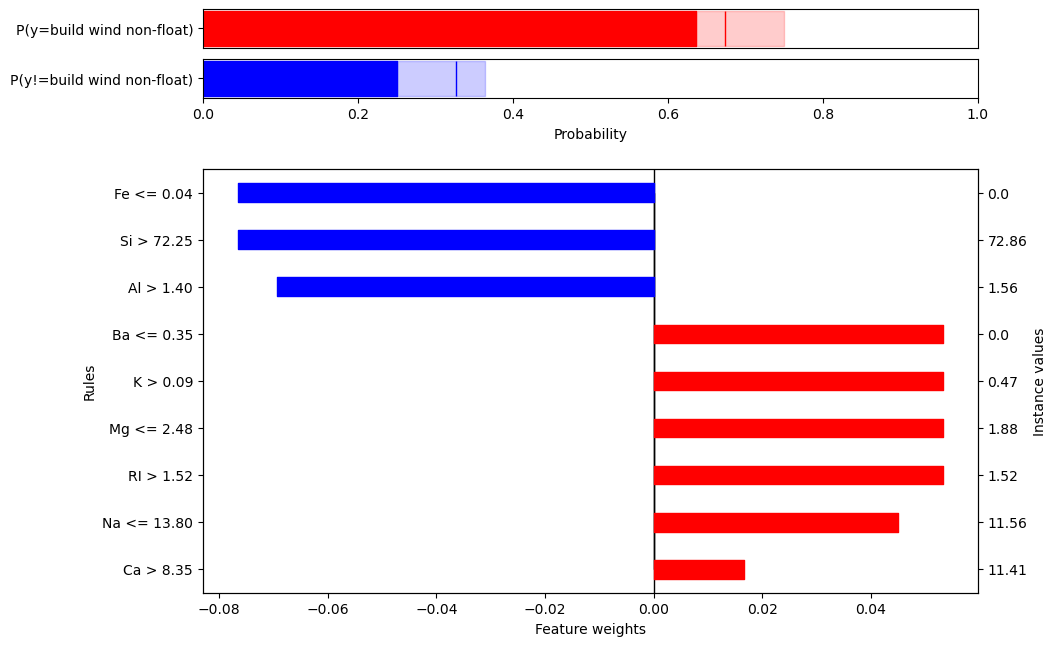

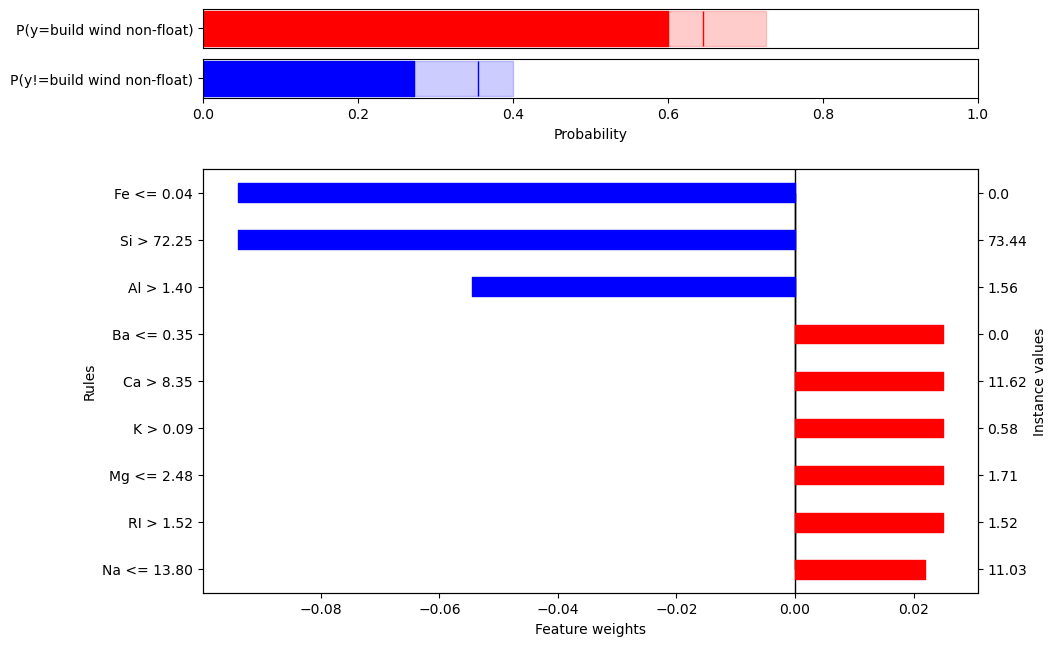

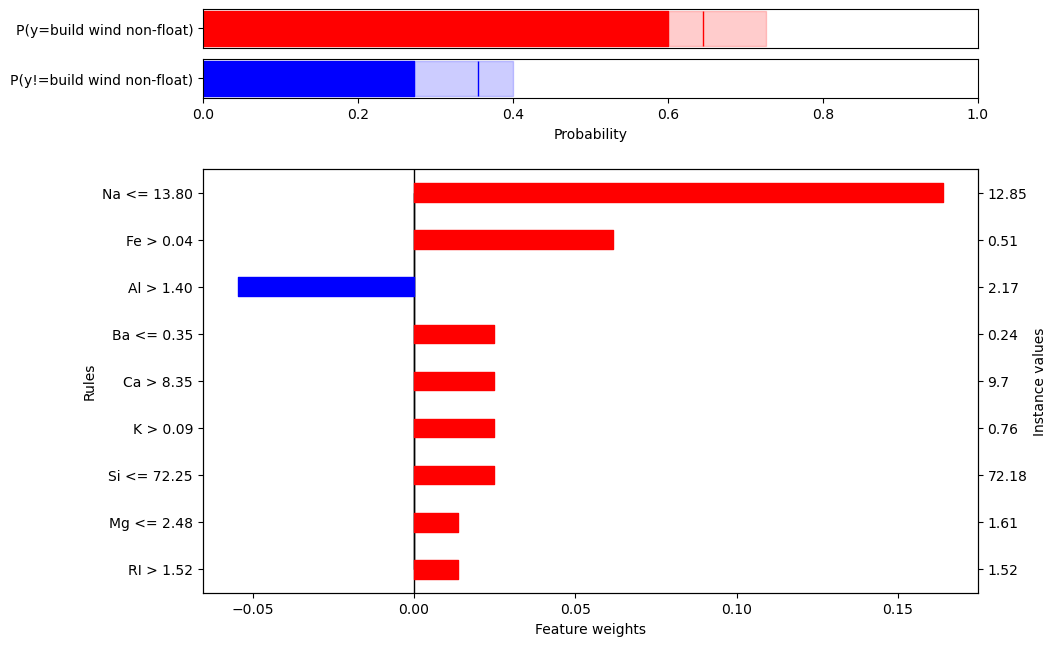

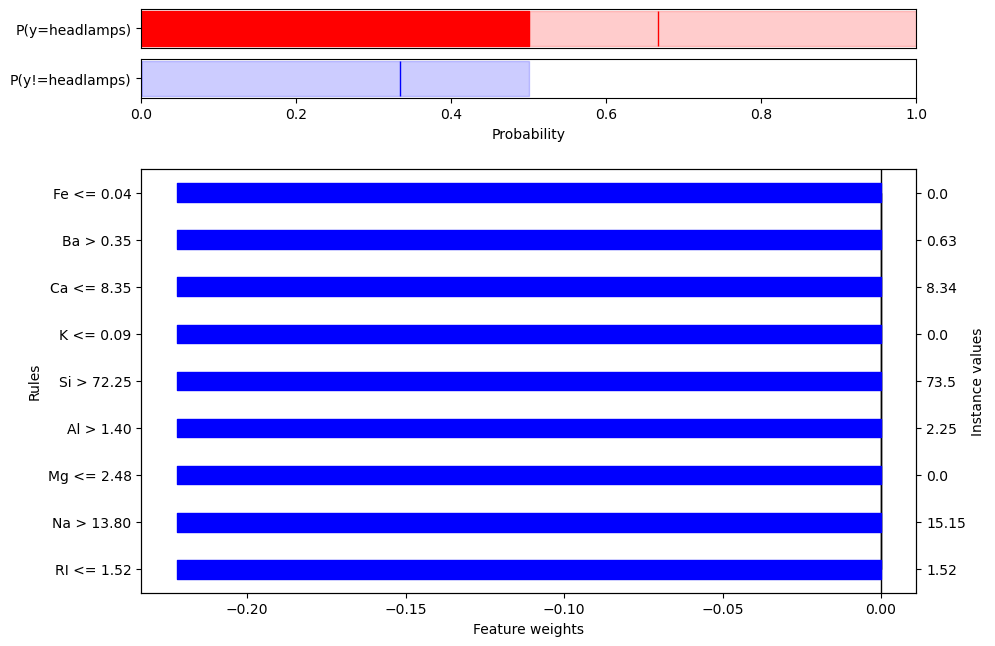

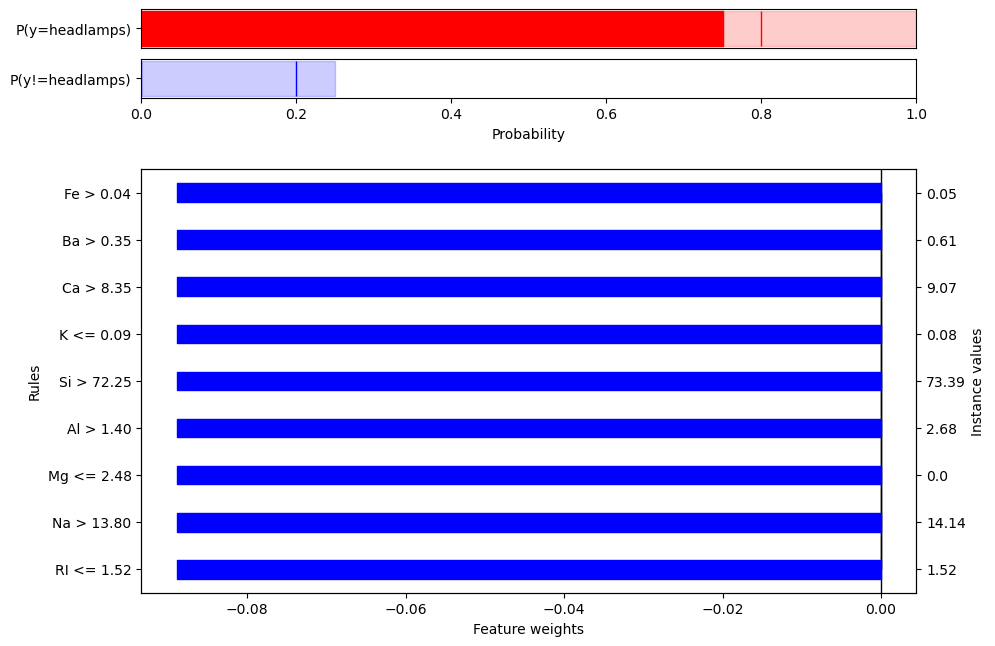

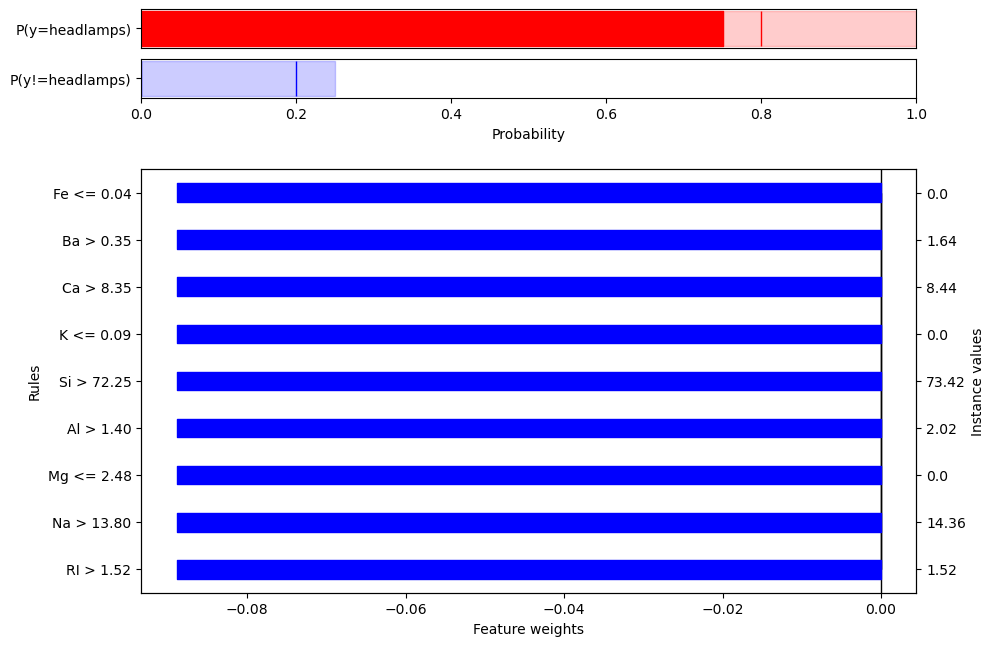

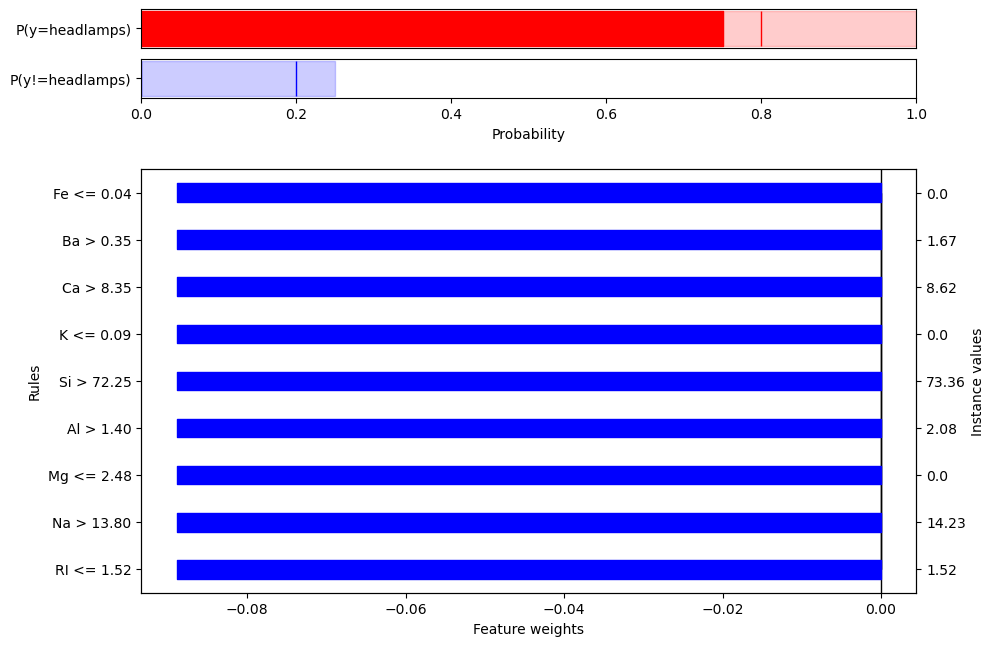

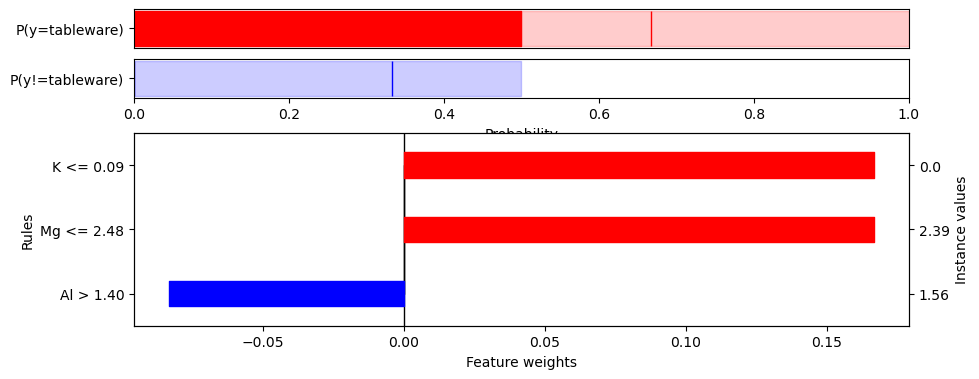

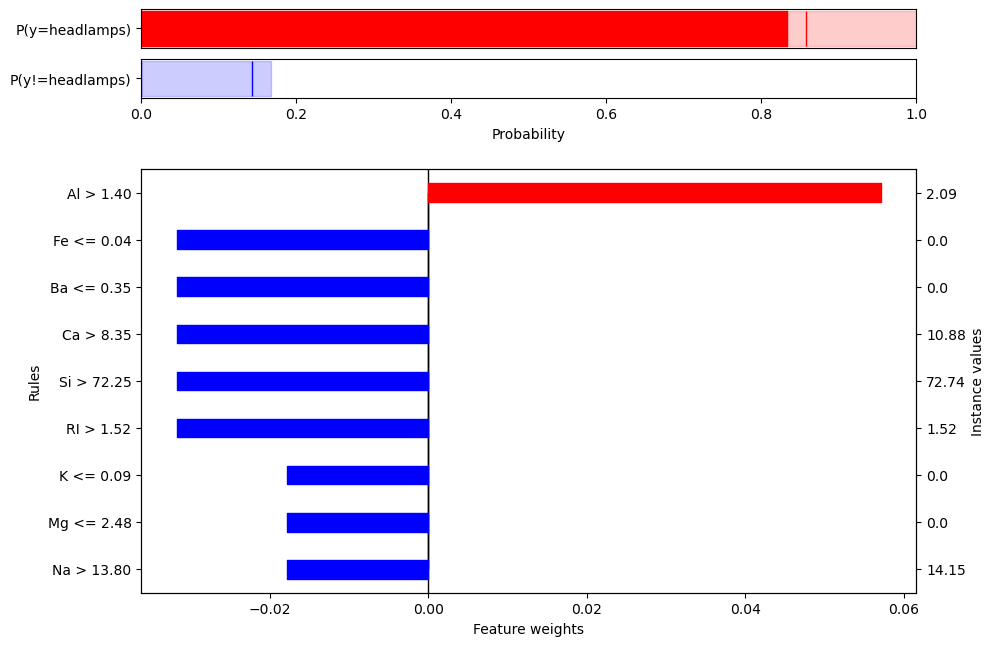

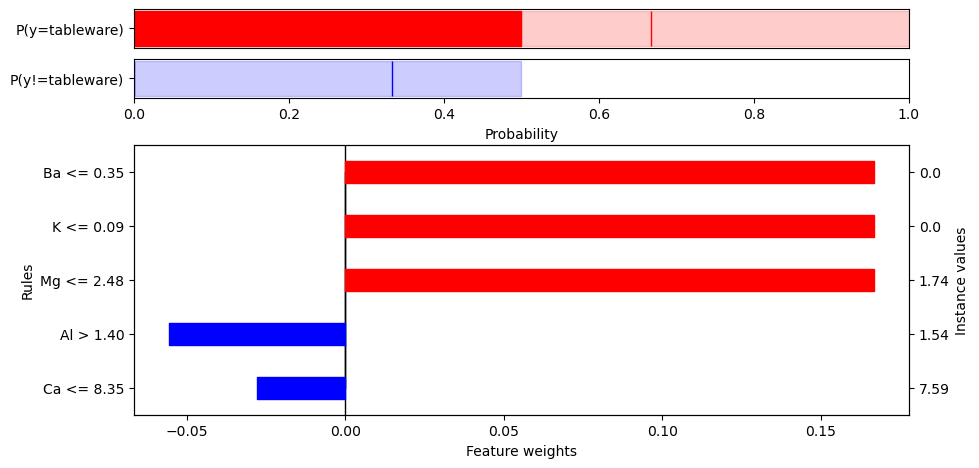

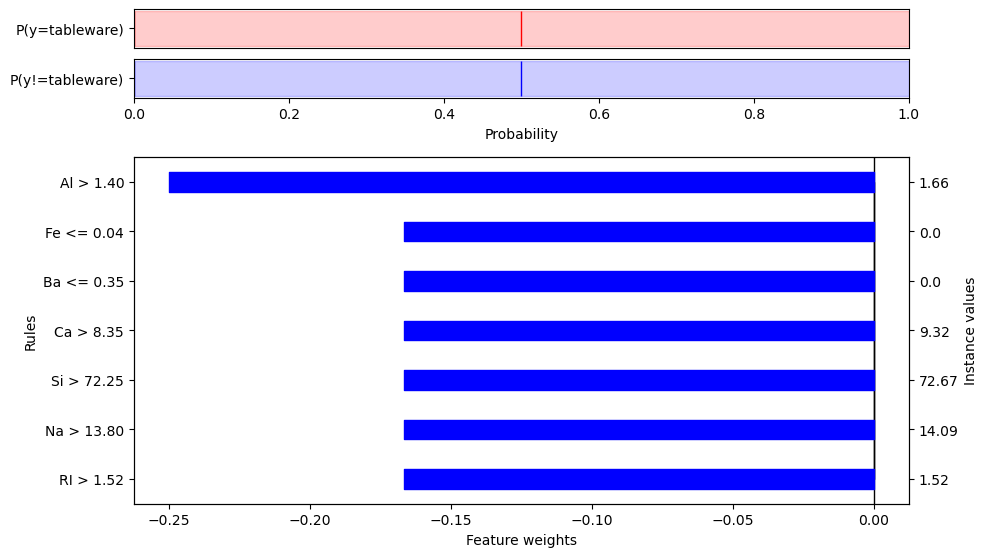

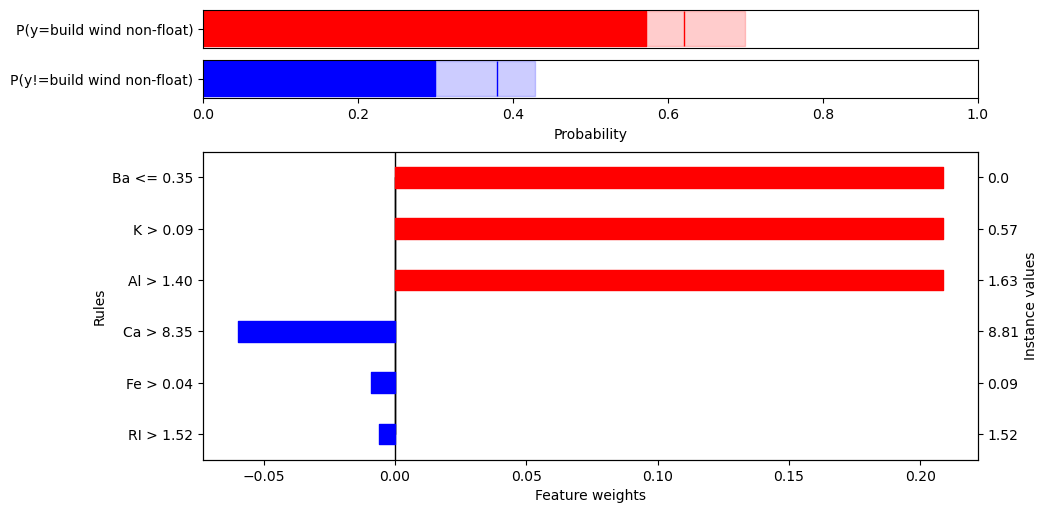

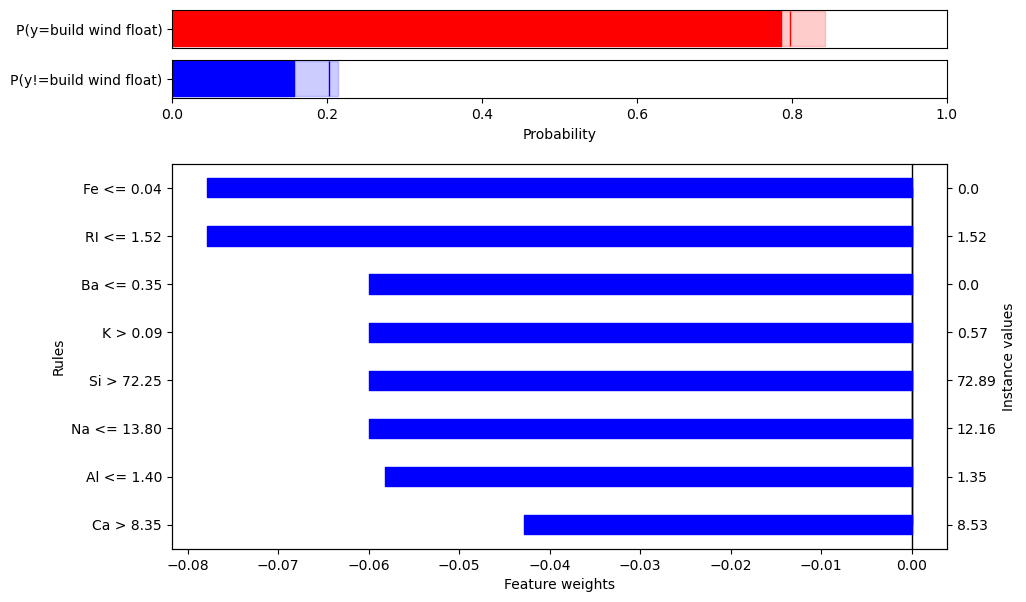

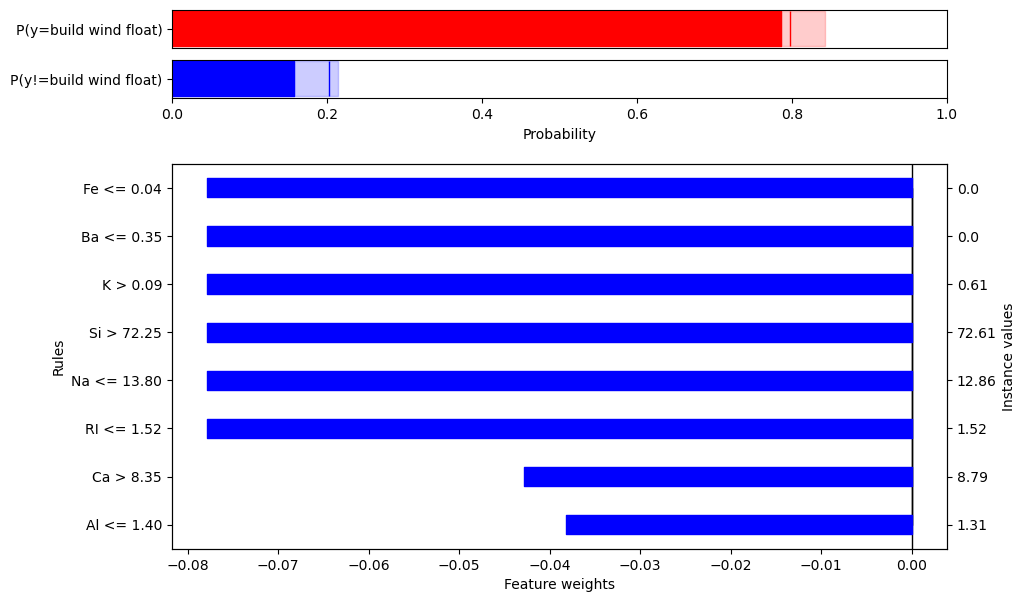

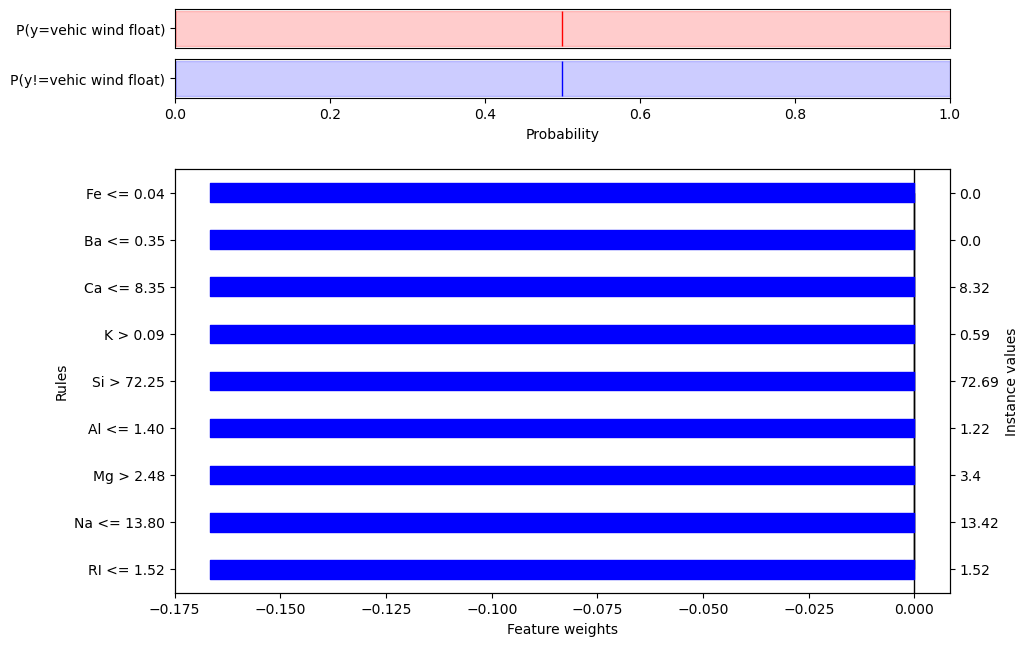

In [13]:
factual_explanation.remove_conjunctions().plot_all()

In [14]:
counterfactual_explanation = ce.explain_counterfactual(testX, bins=bins_test)

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\_explanations.py:1552: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,num_to_show*.5))


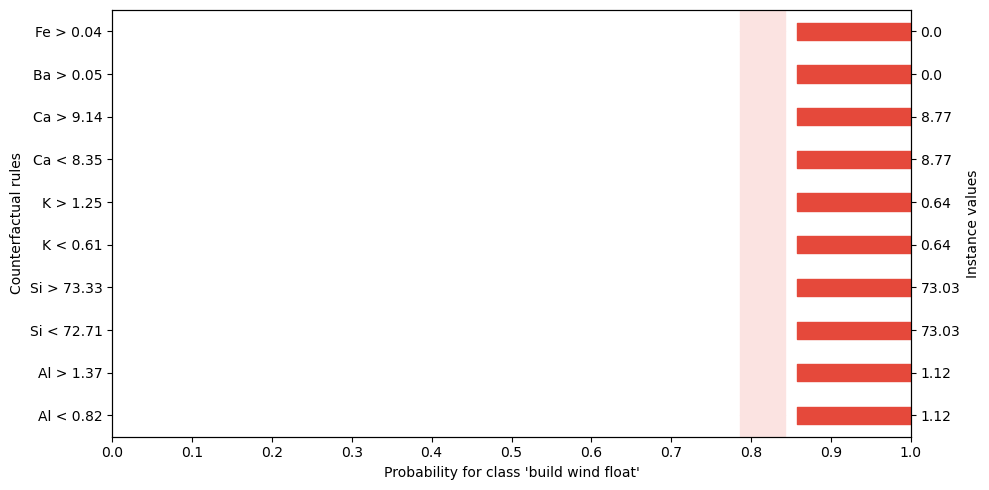

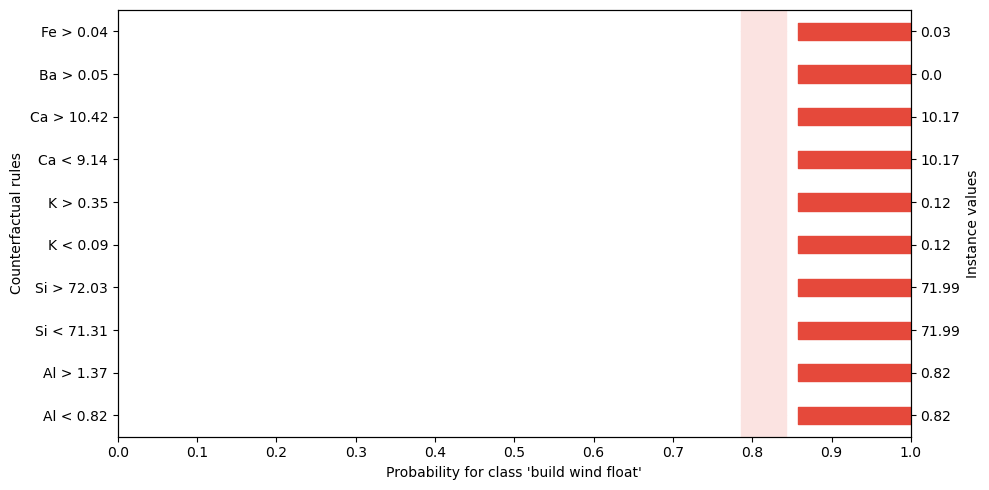

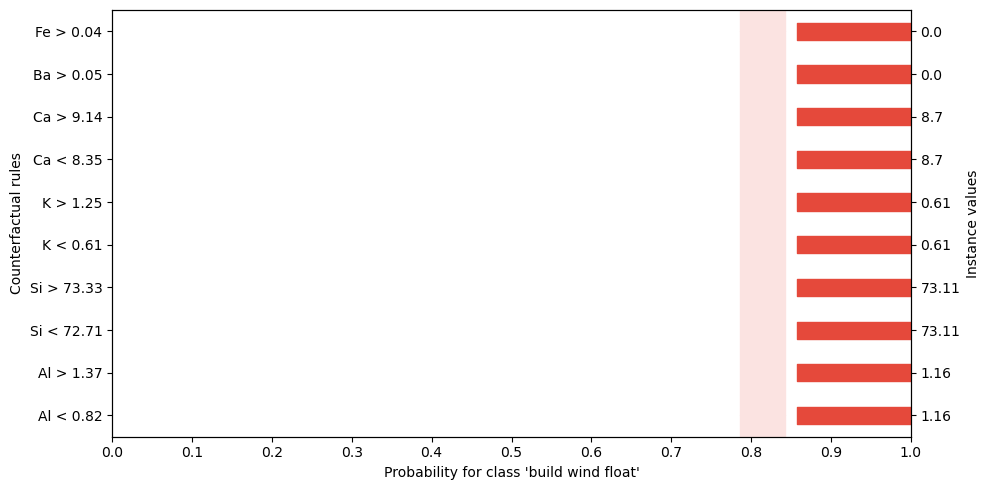

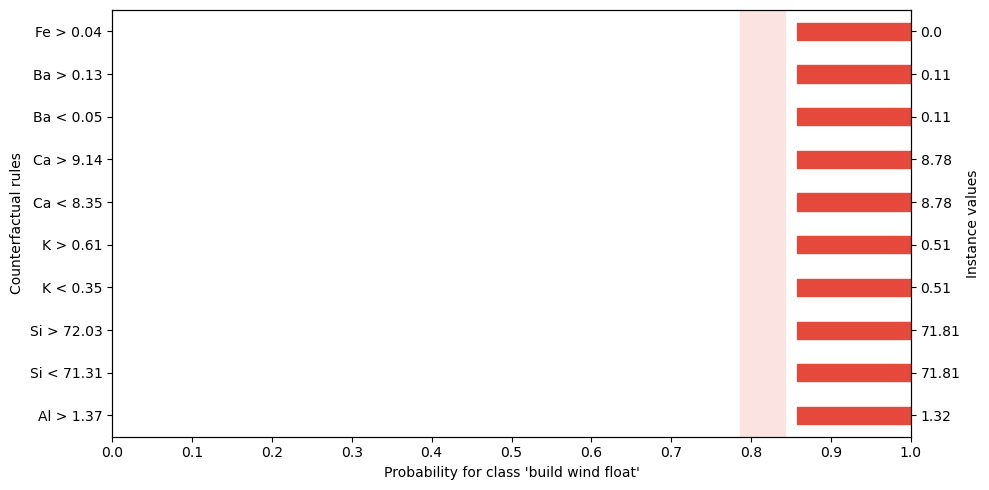

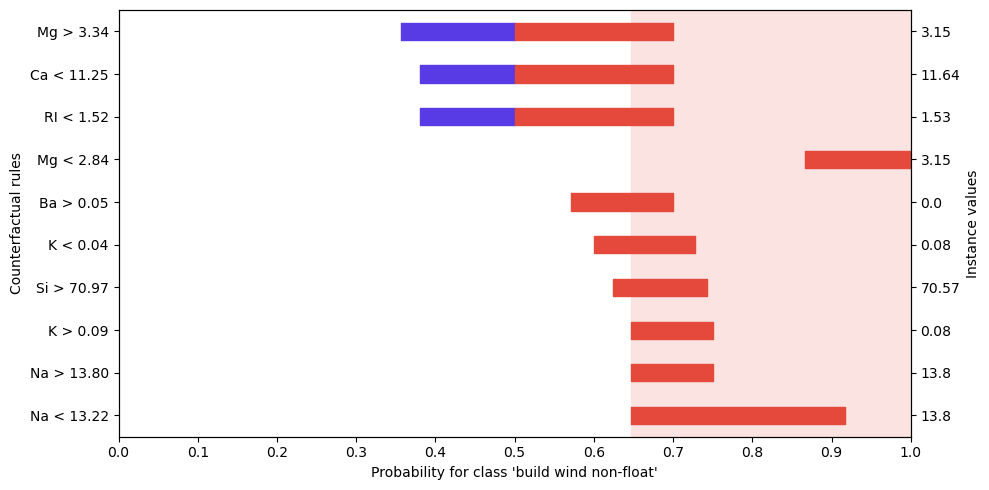

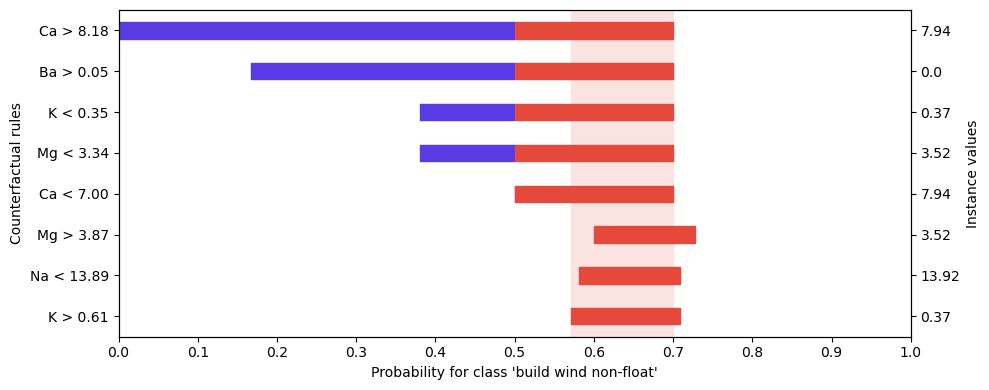

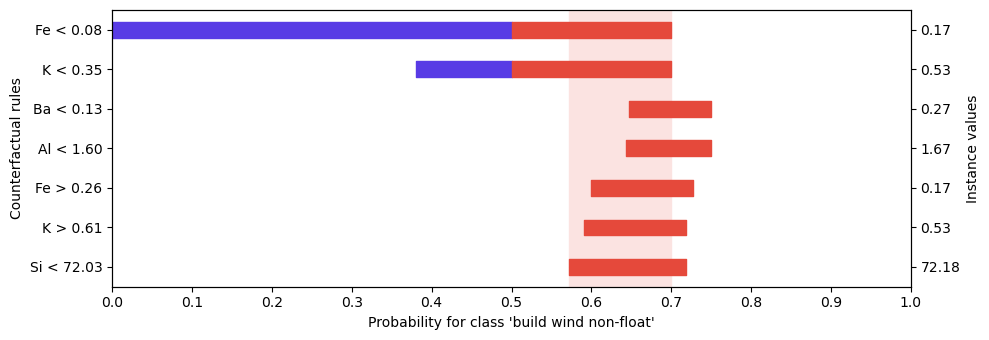

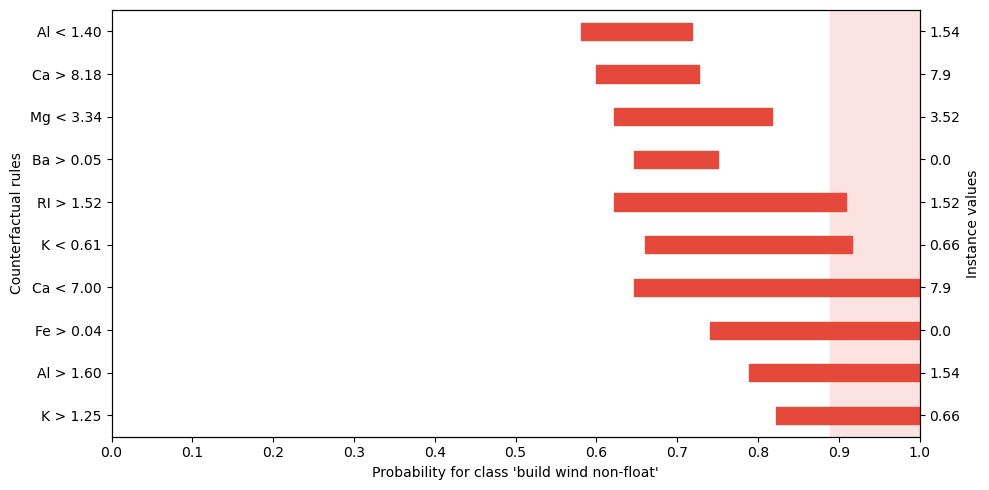

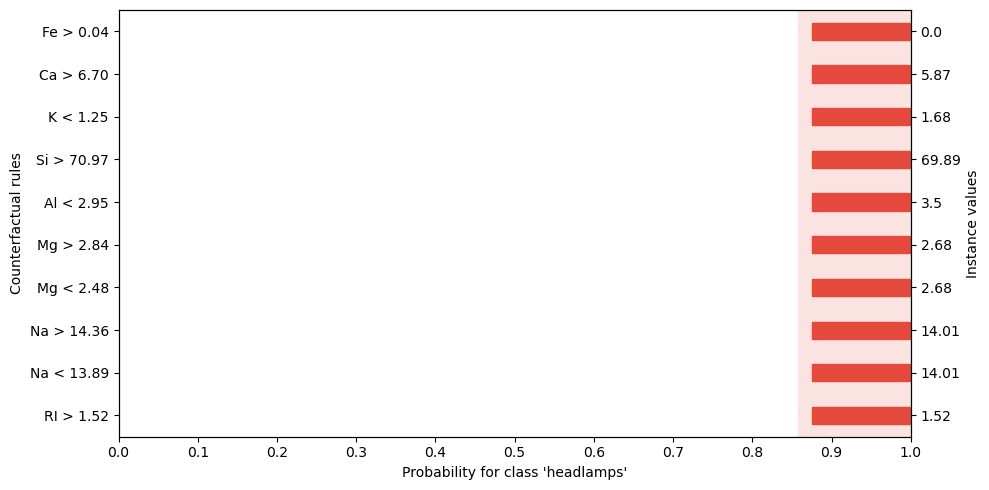

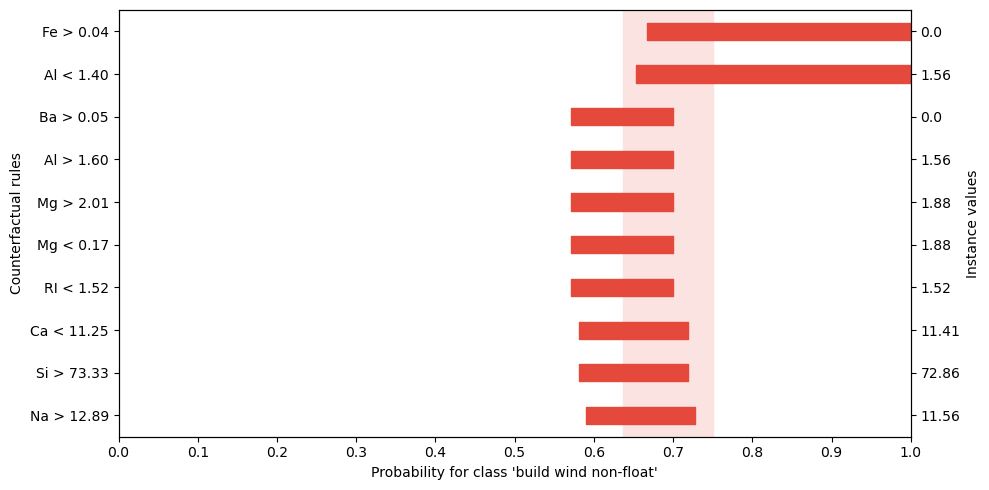

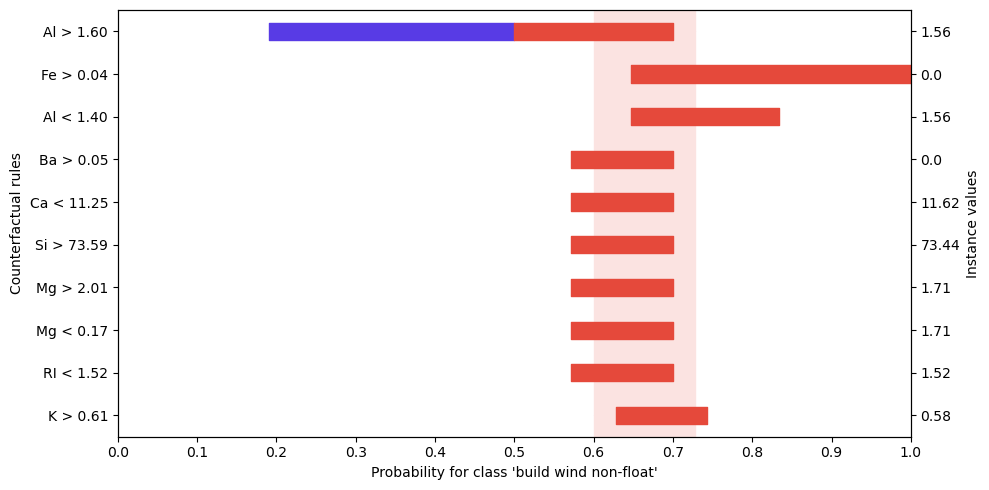

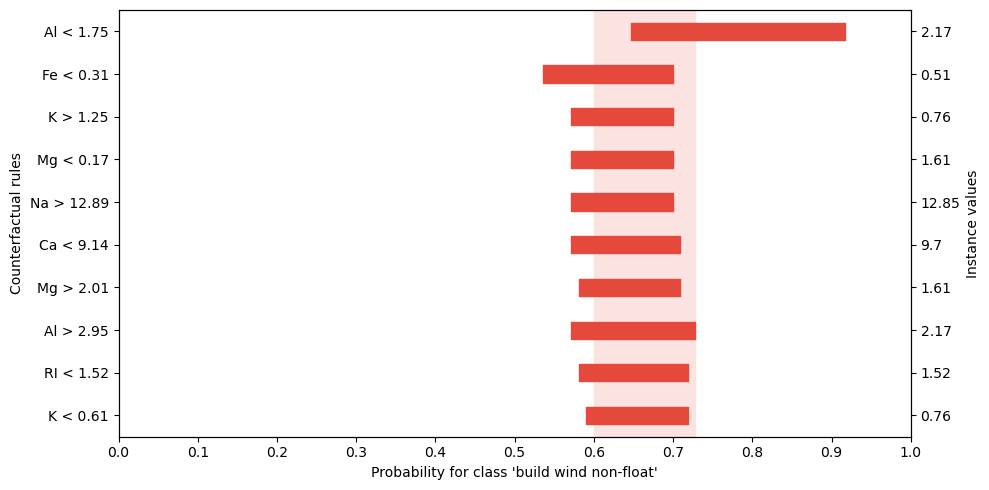

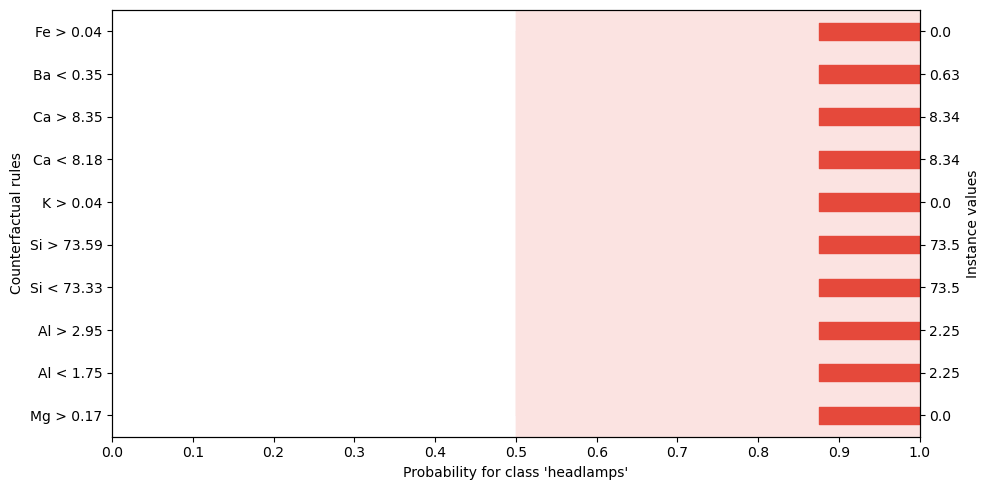

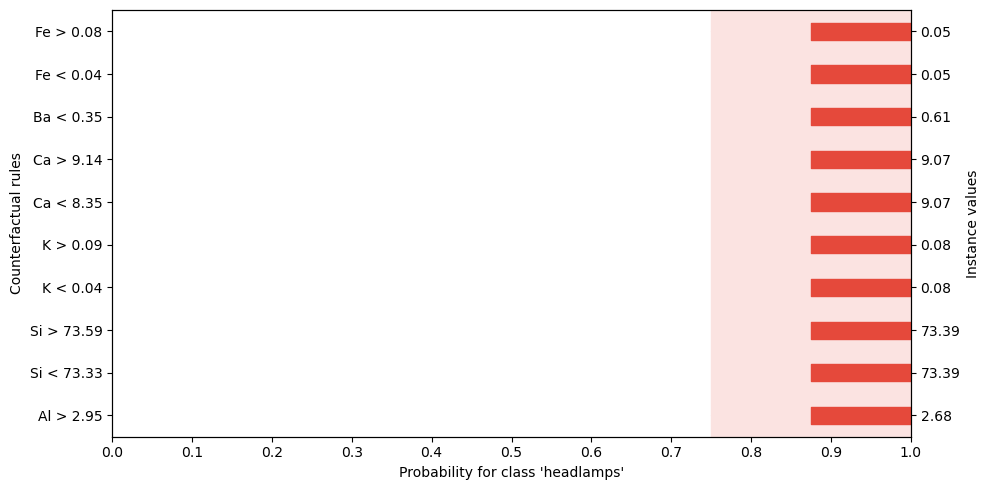

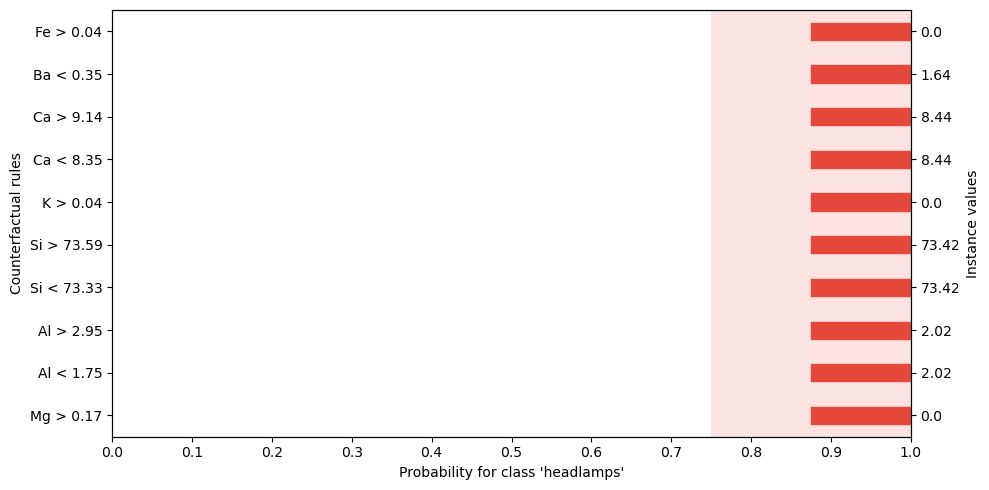

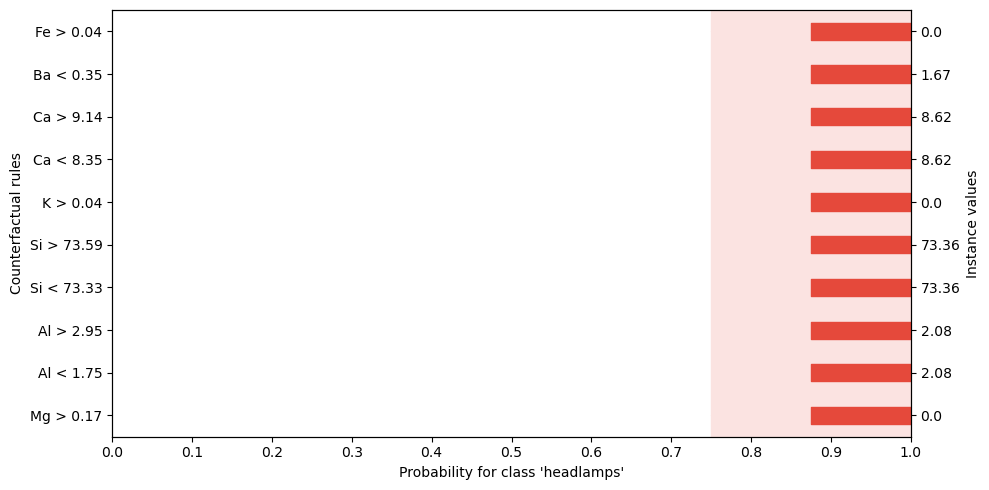

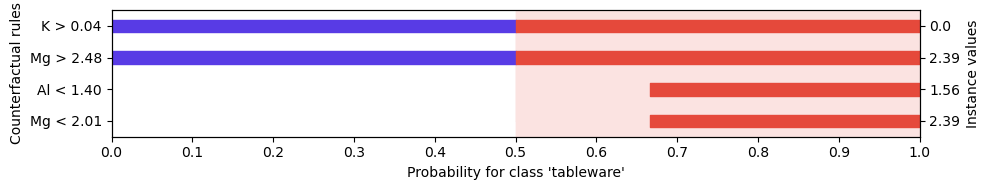

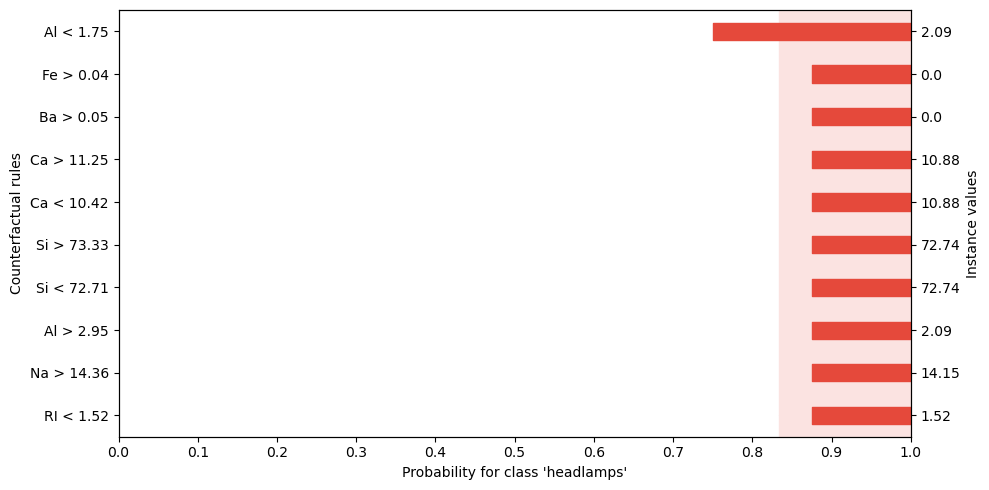

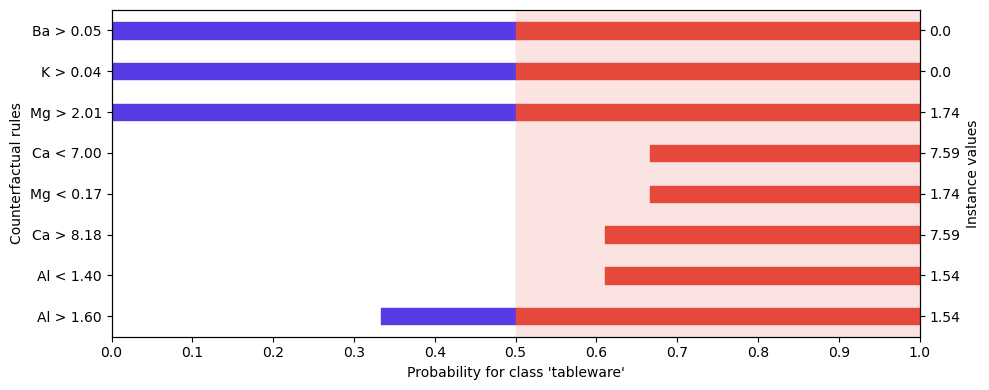

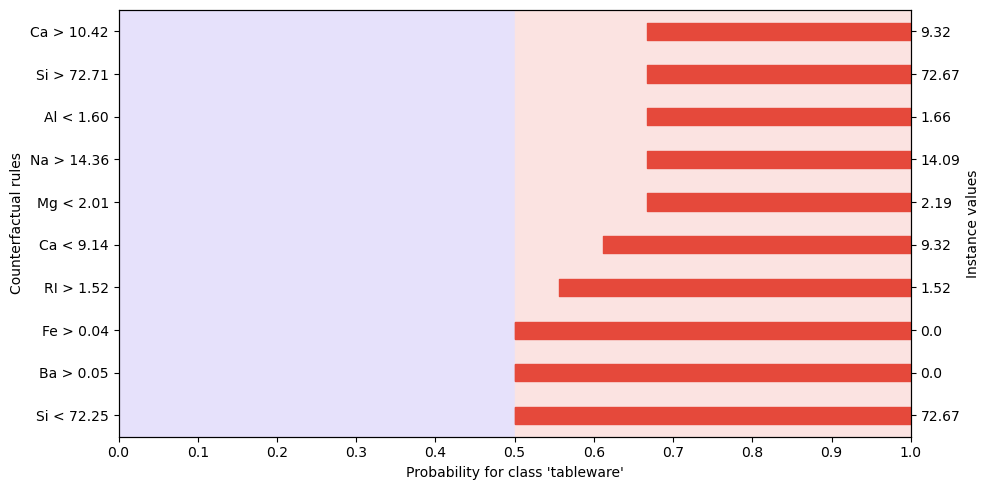

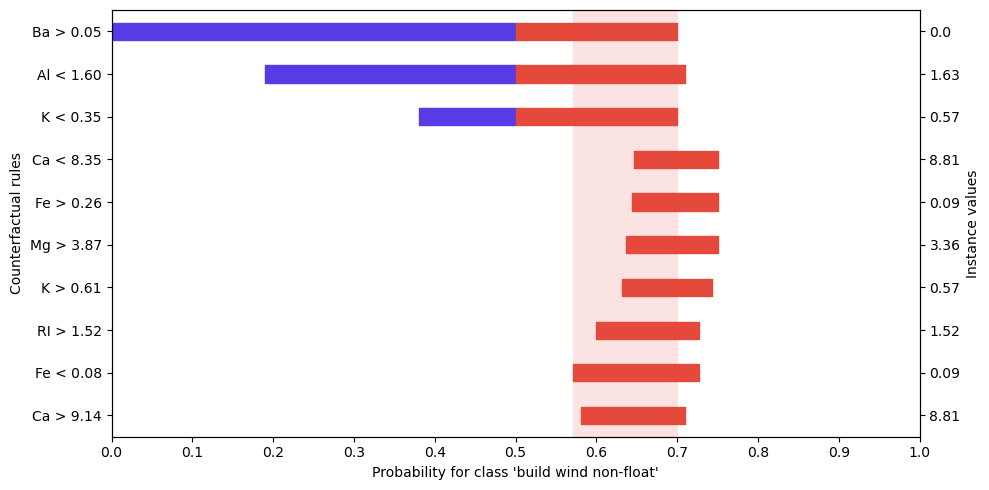

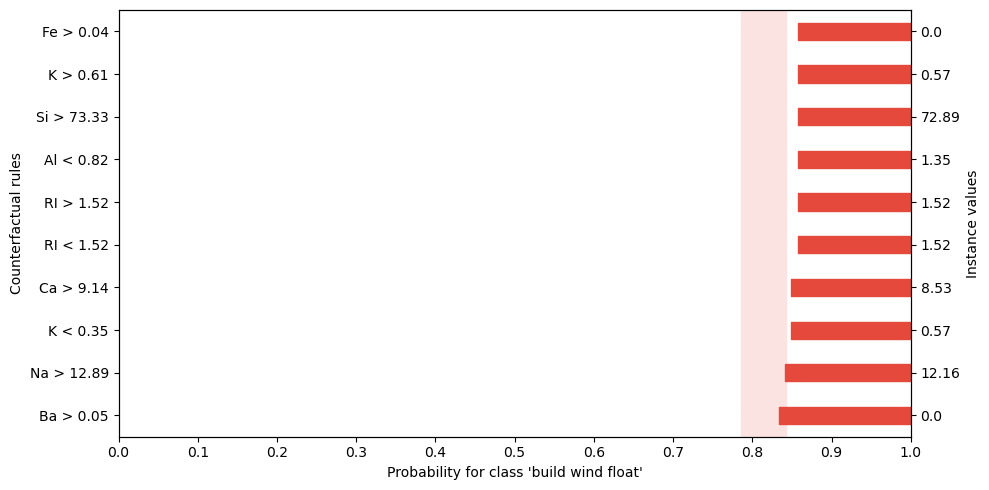

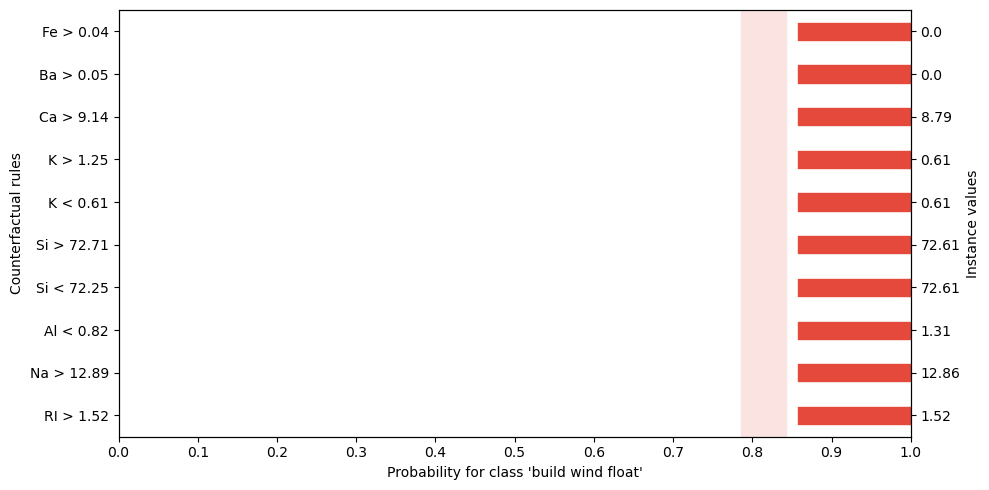

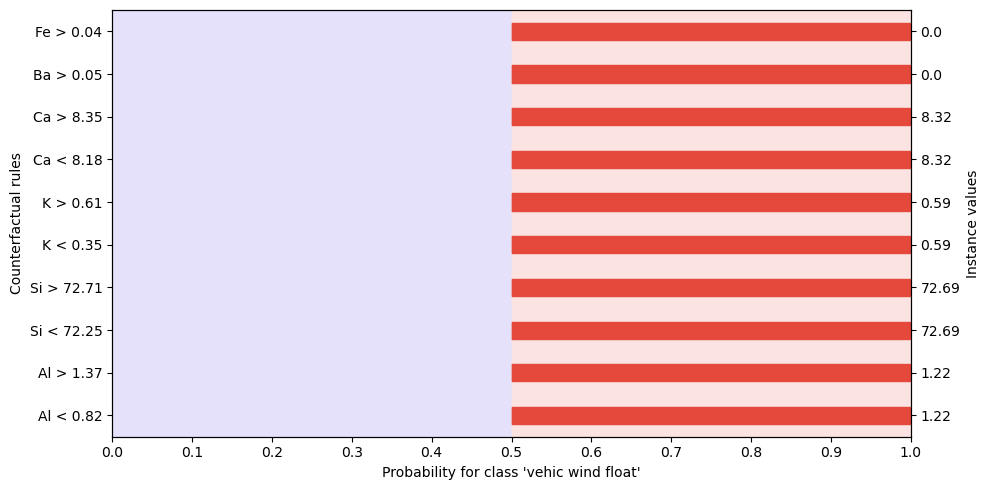

In [15]:
counterfactual_explanation.plot_all()

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\_explanations.py:1553: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  ax_main = fig.add_subplot(111)


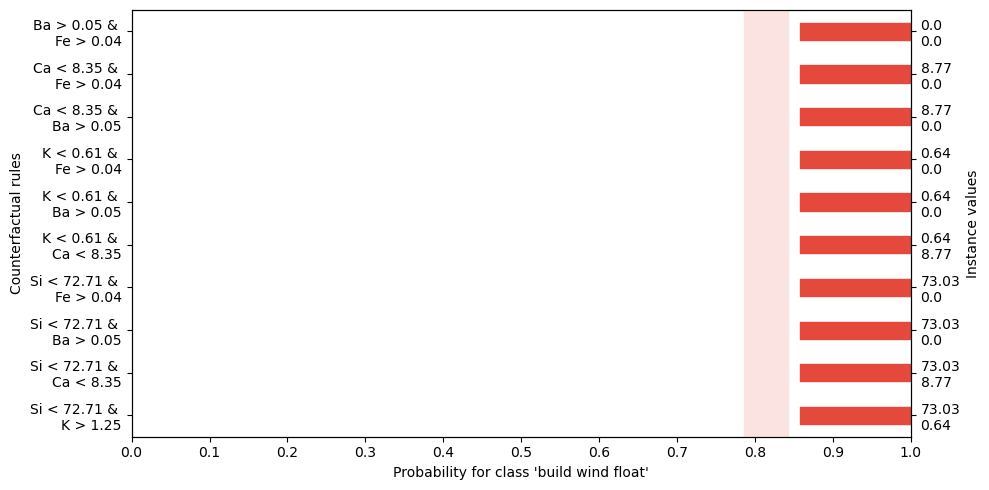

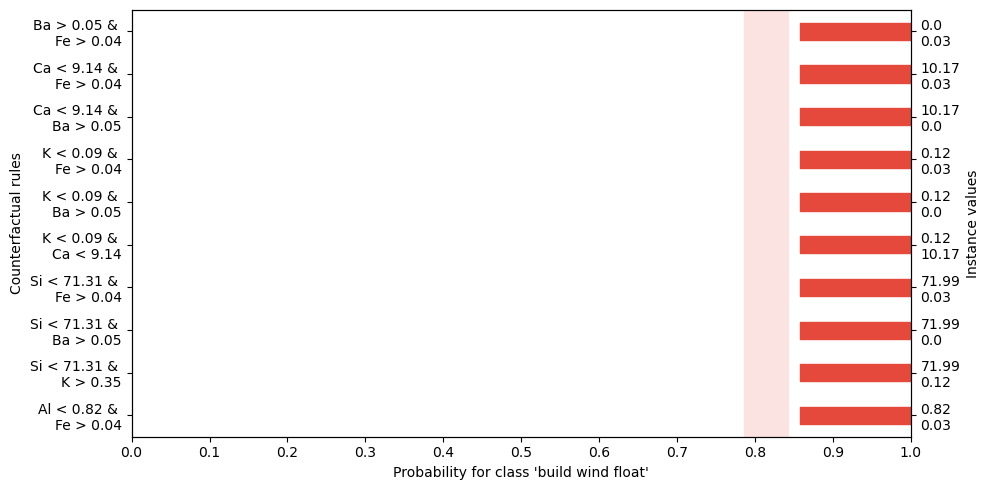

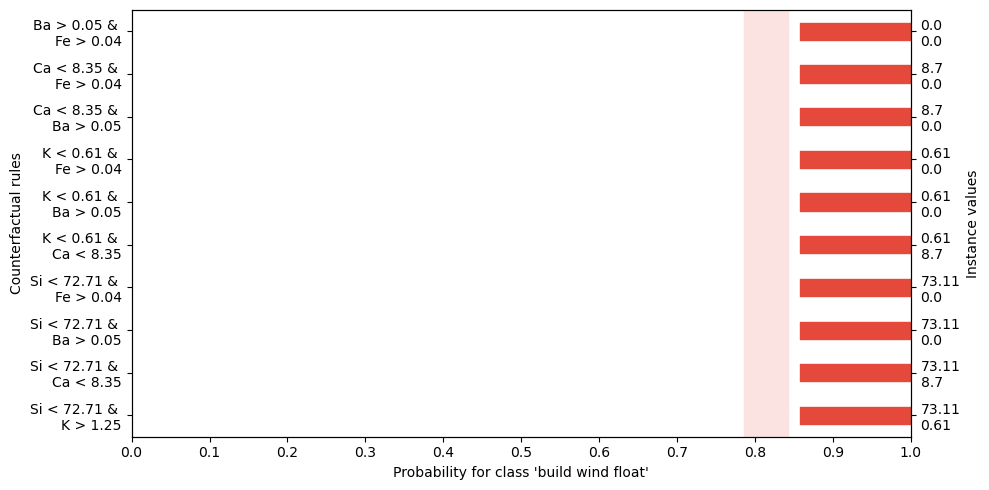

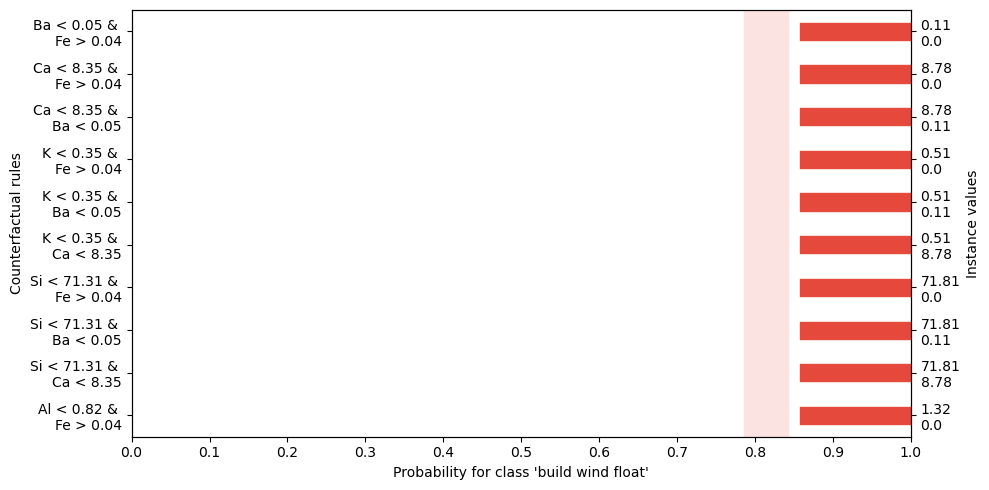

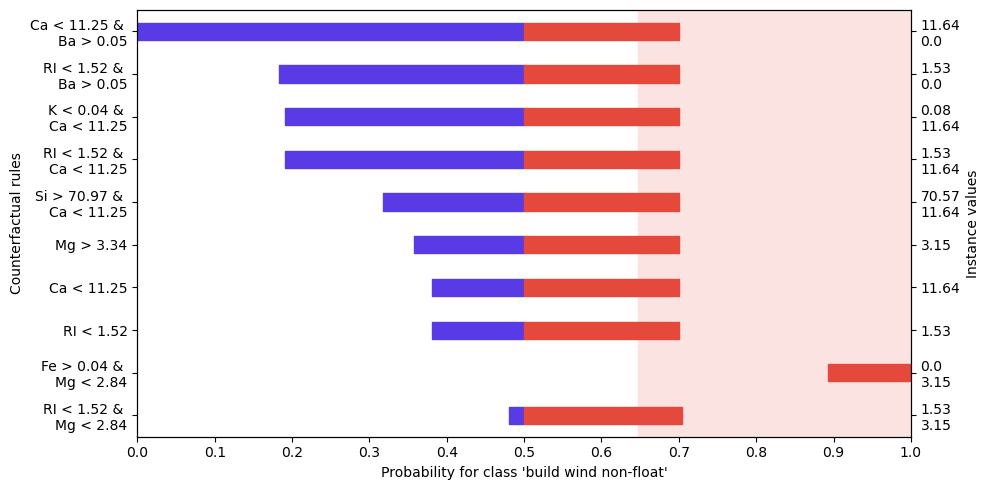

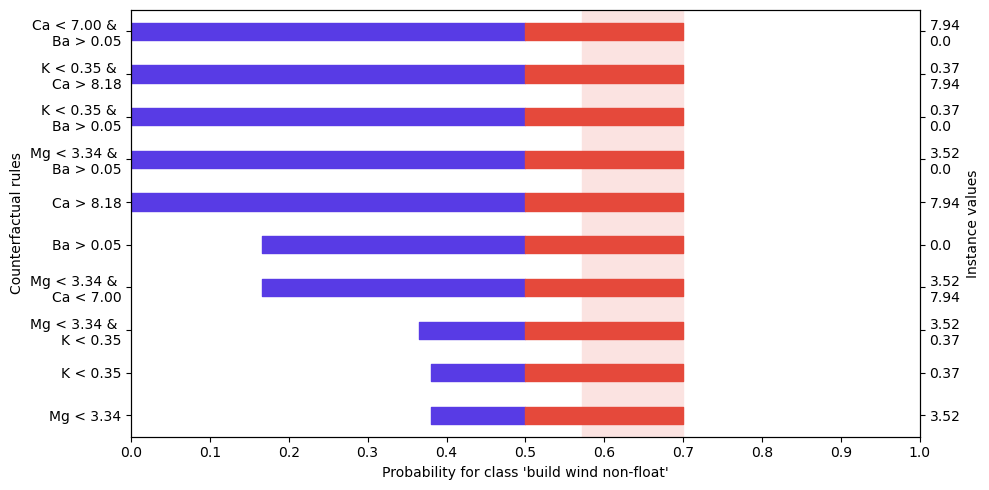

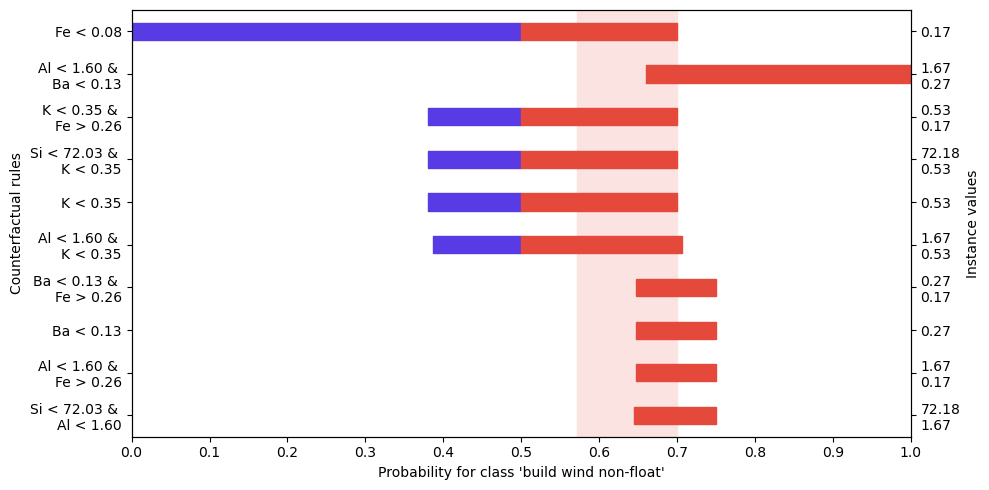

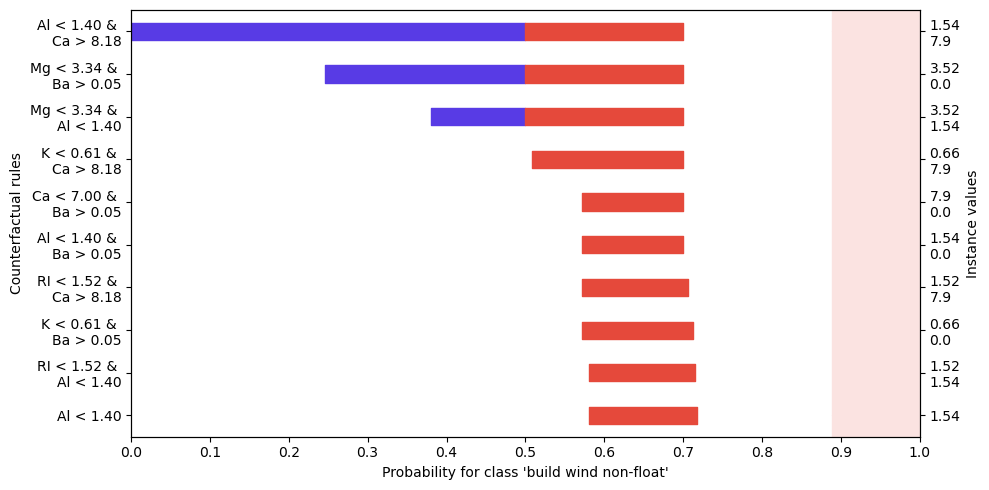

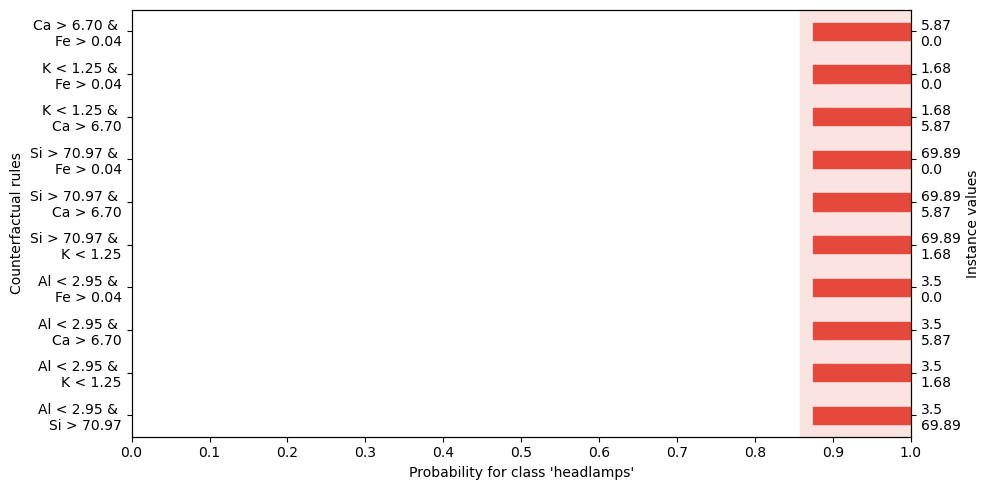

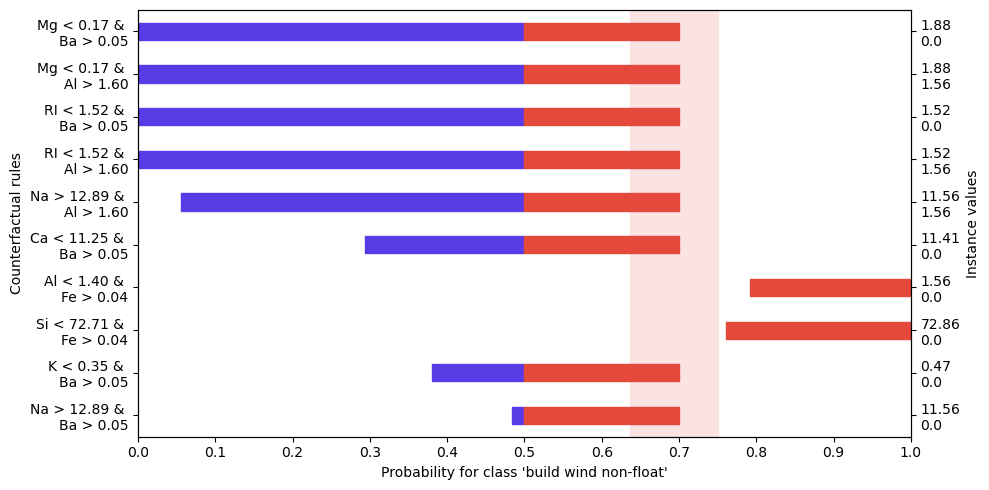

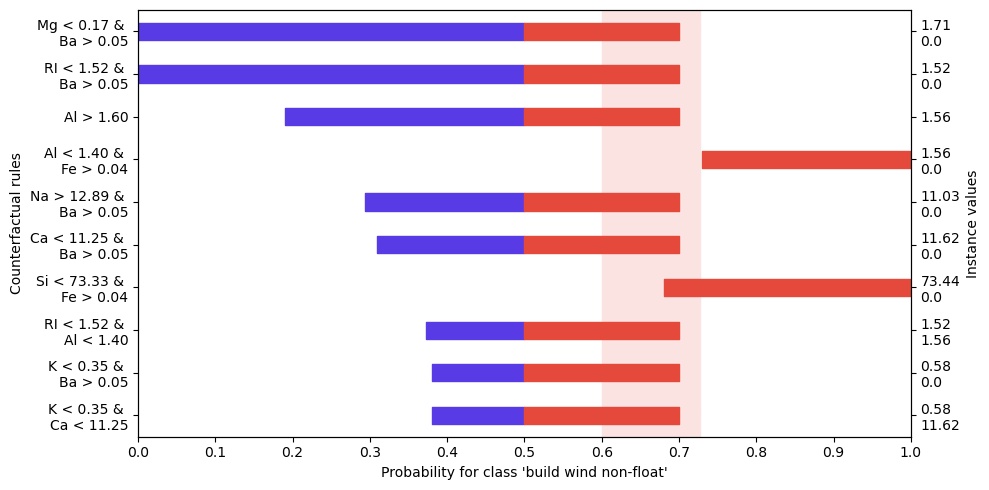

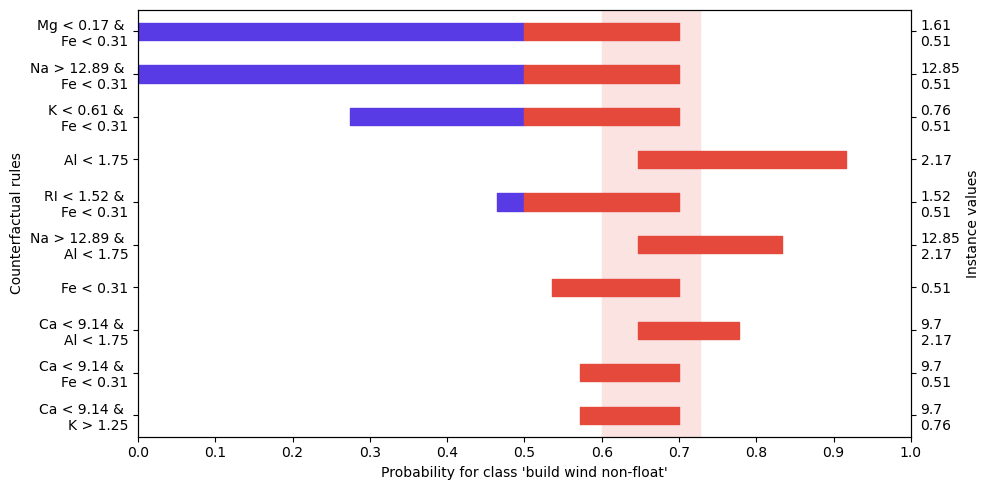

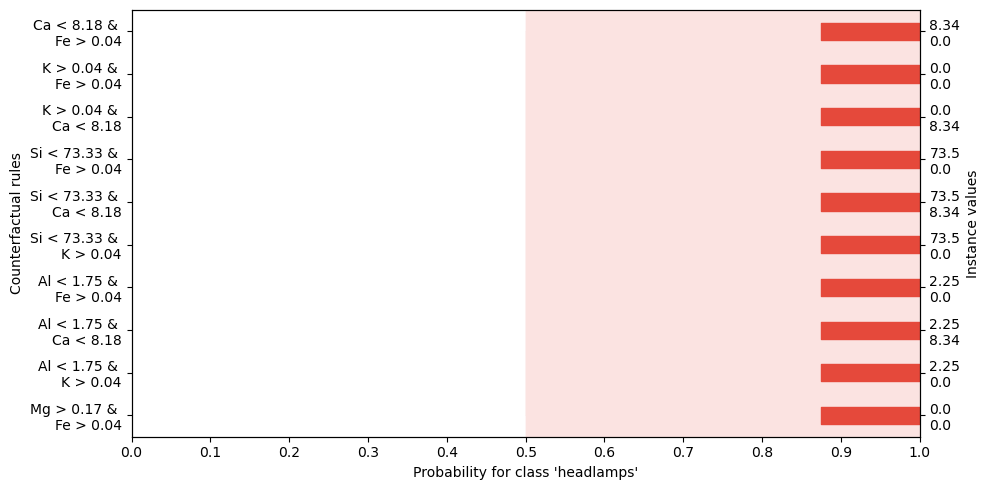

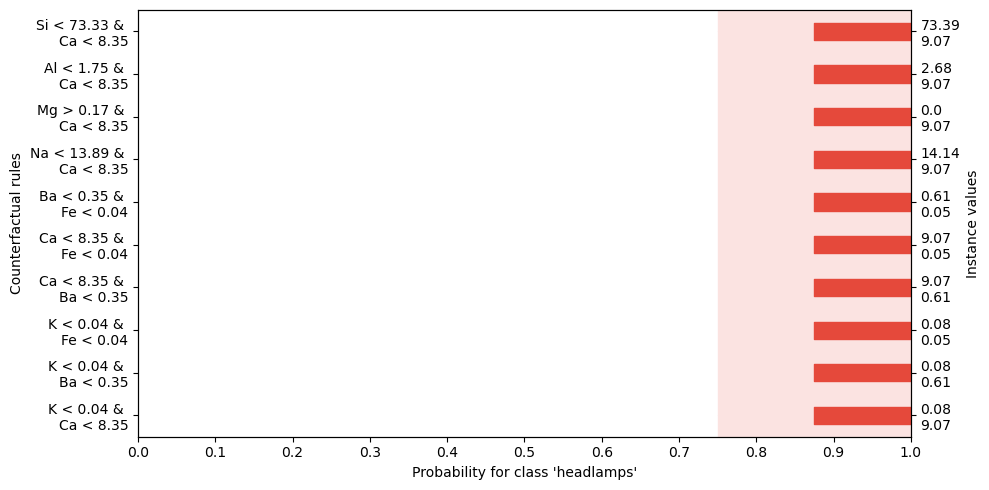

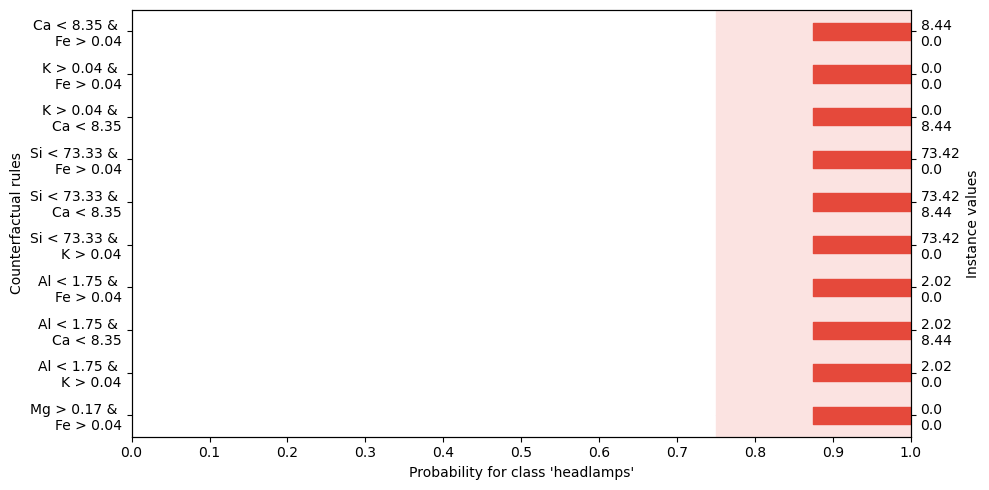

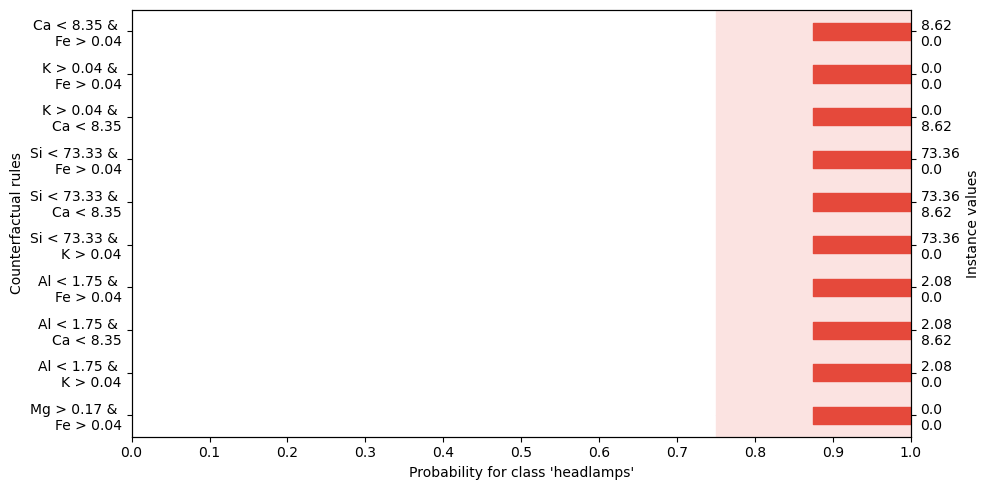

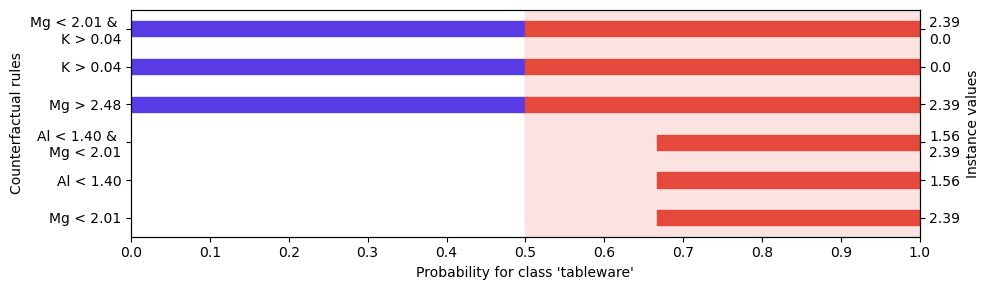

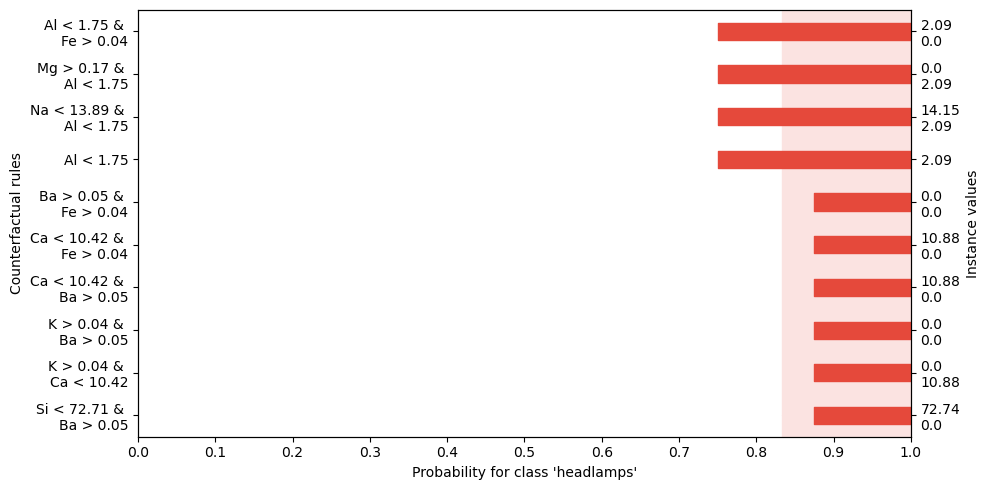

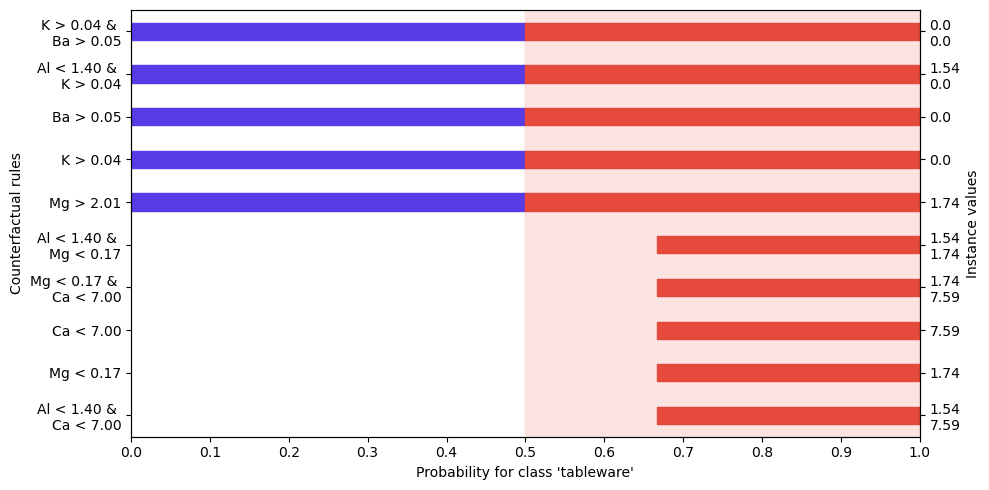

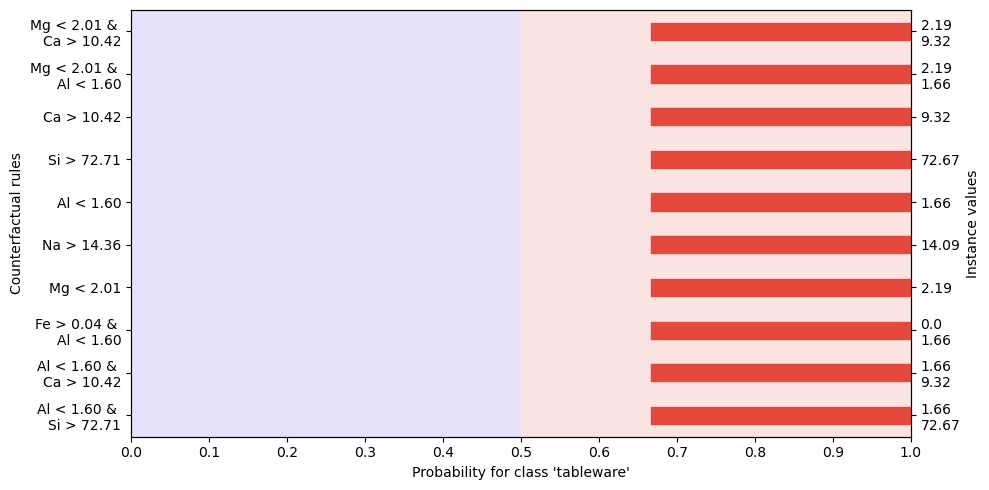

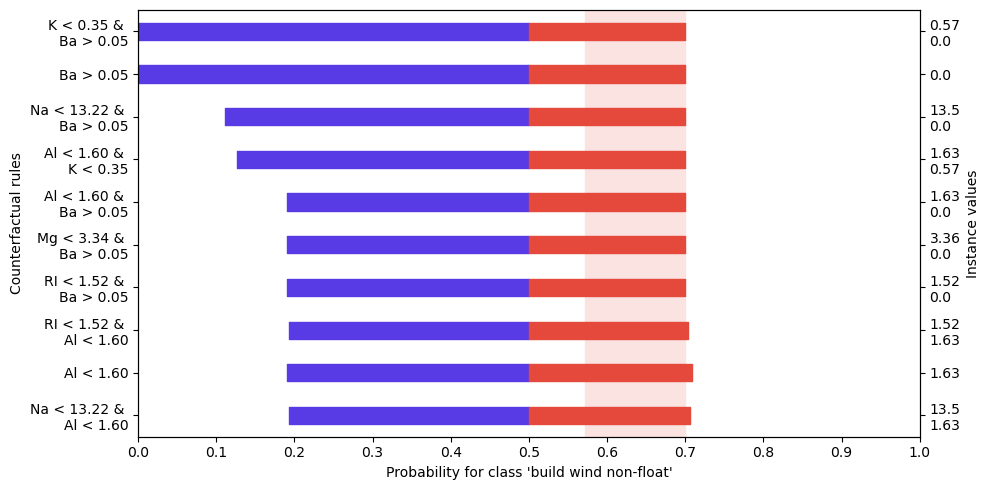

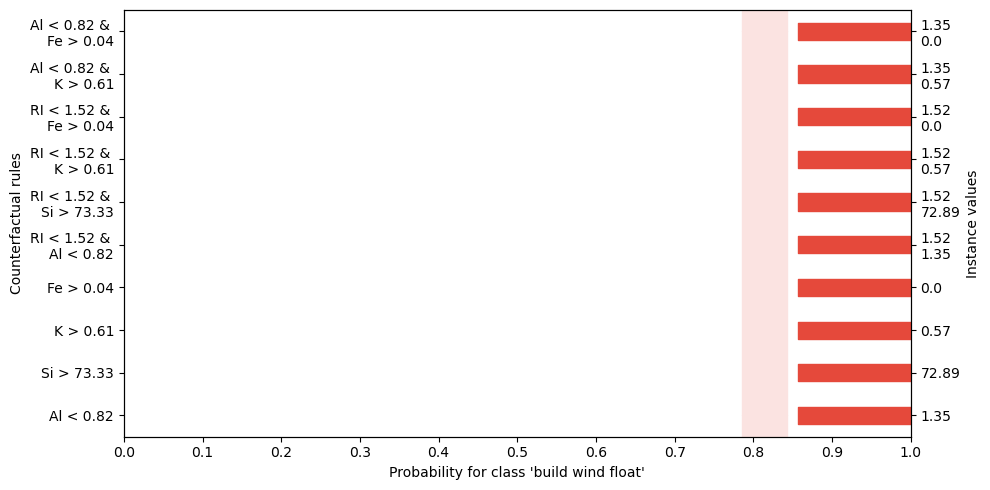

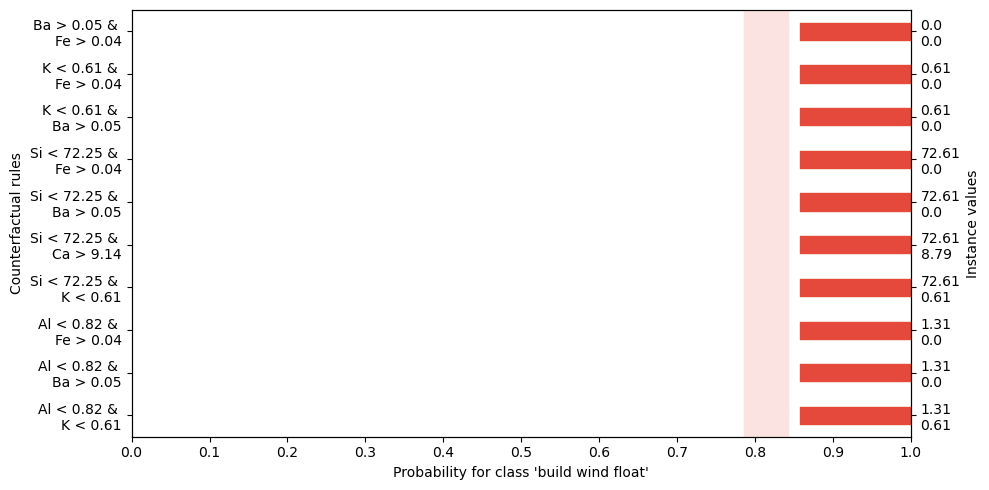

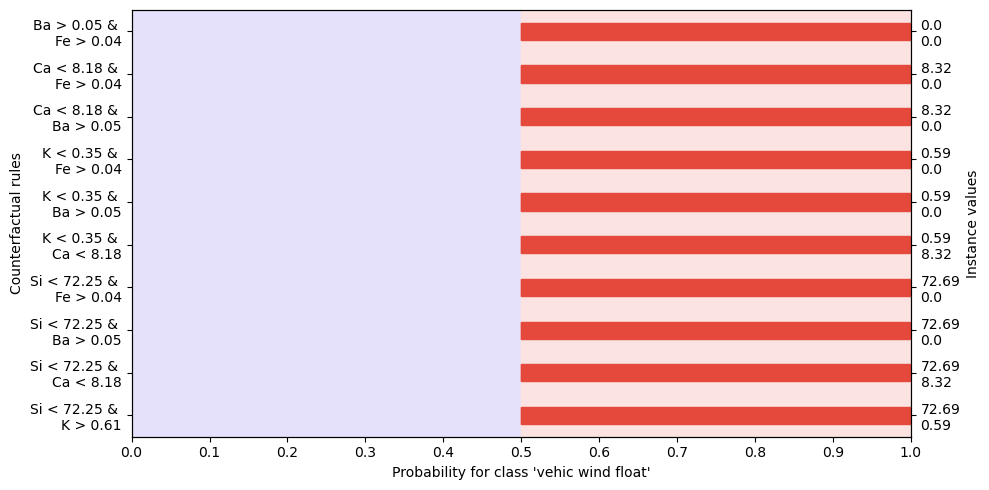

In [17]:
counterfactual_explanation.add_conjunctions().plot_all()

c:\Users\loftuw\AppData\Local\anaconda3\envs\ce\lib\site-packages\calibrated_explanations\_explanations.py:1553: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  ax_main = fig.add_subplot(111)


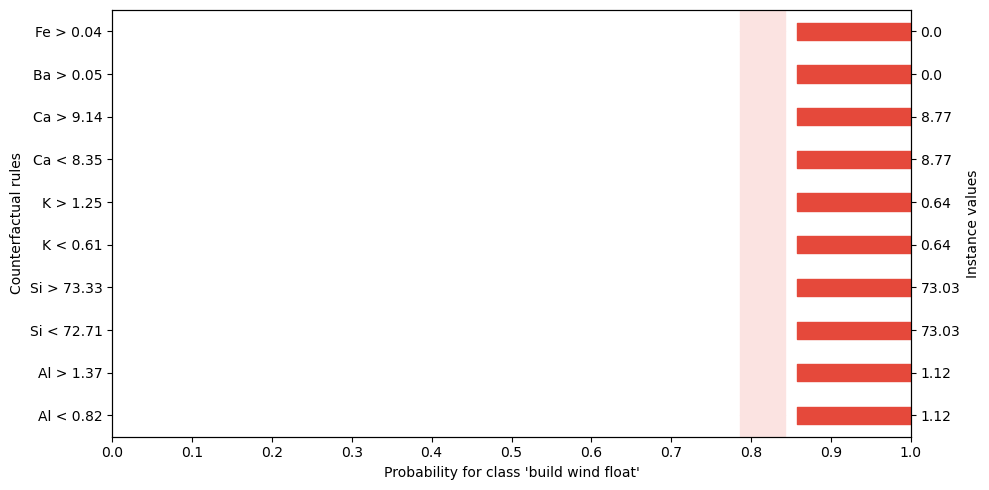

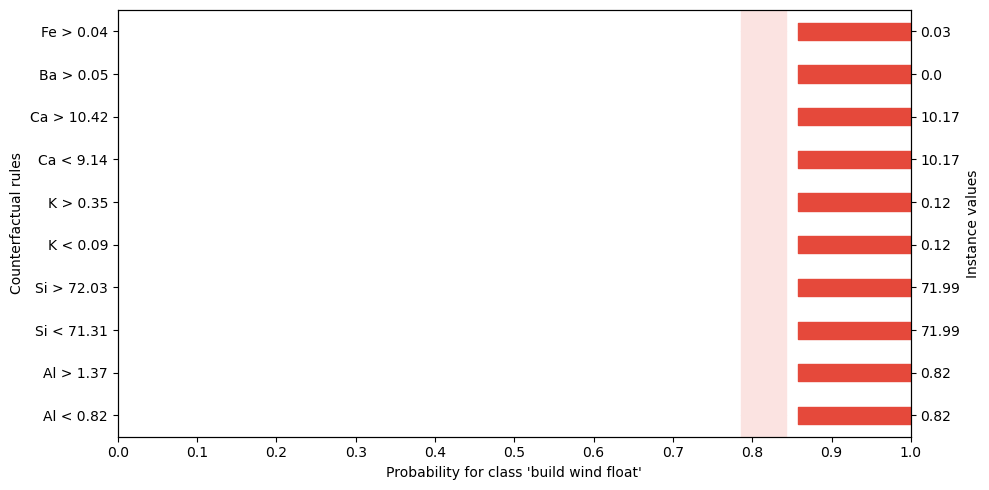

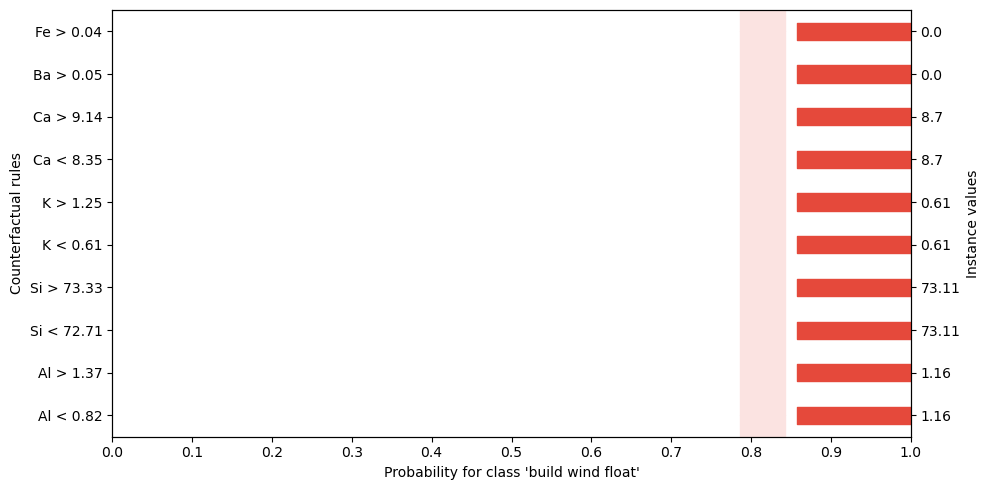

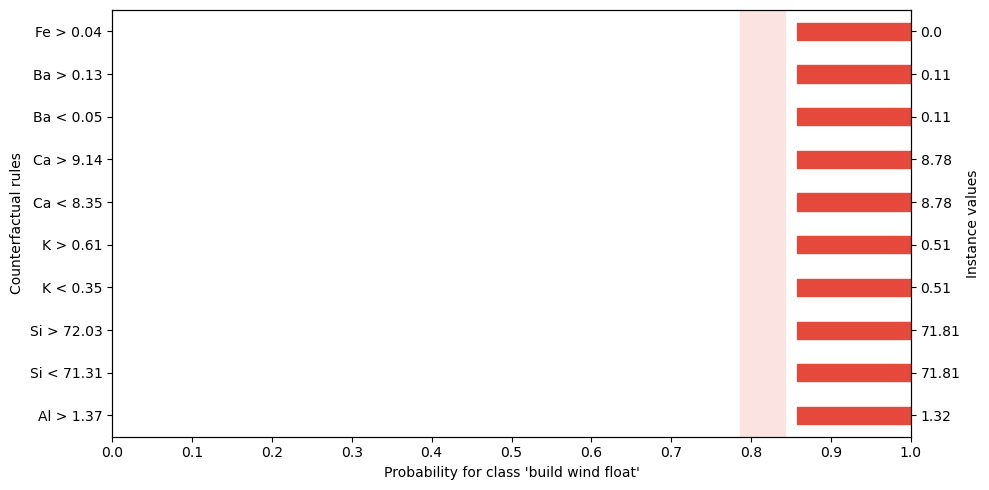

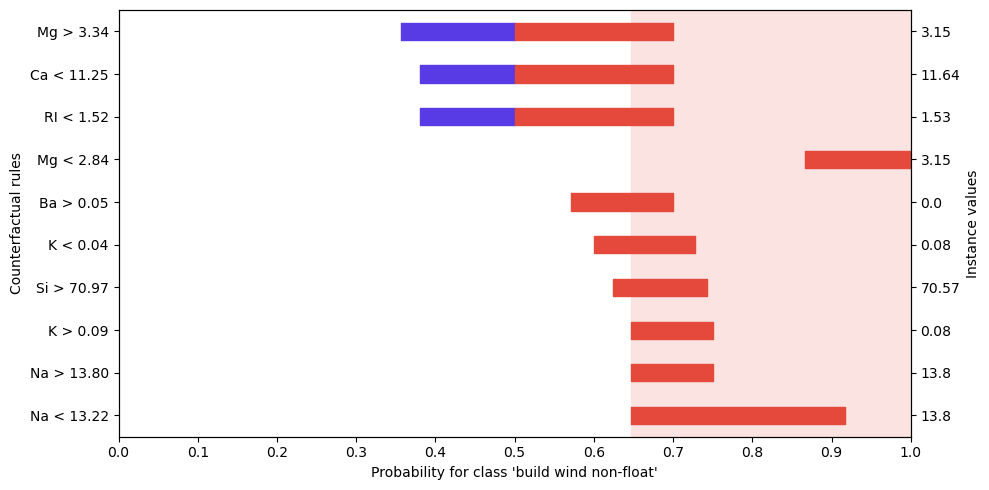

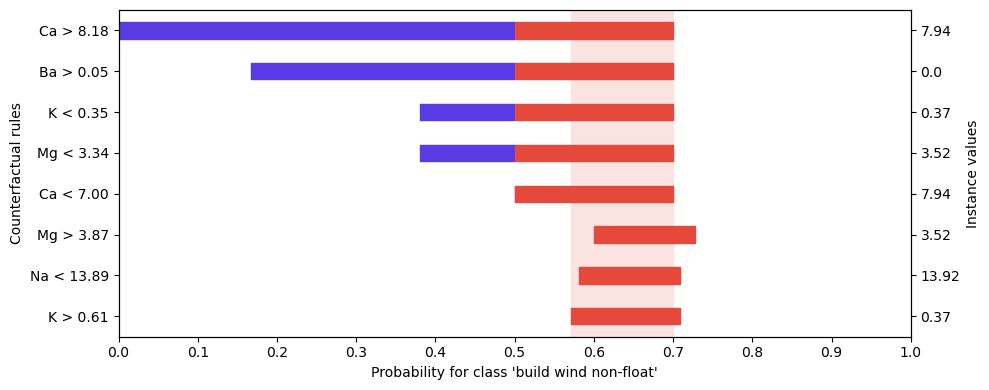

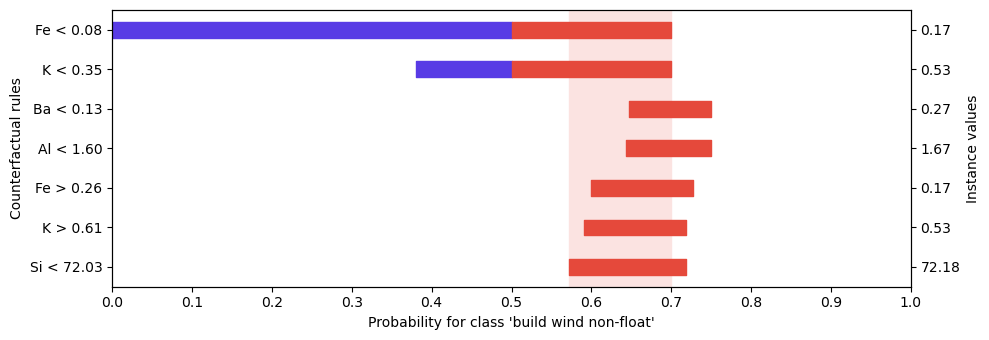

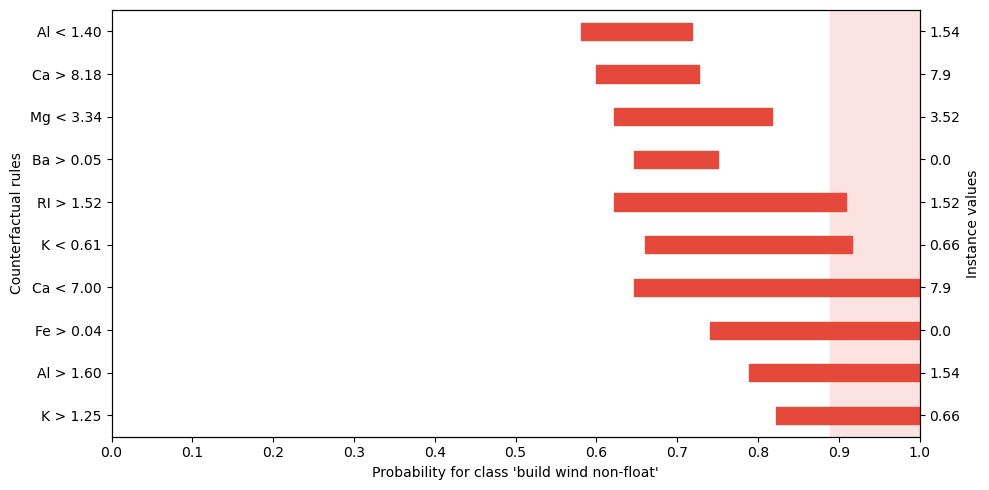

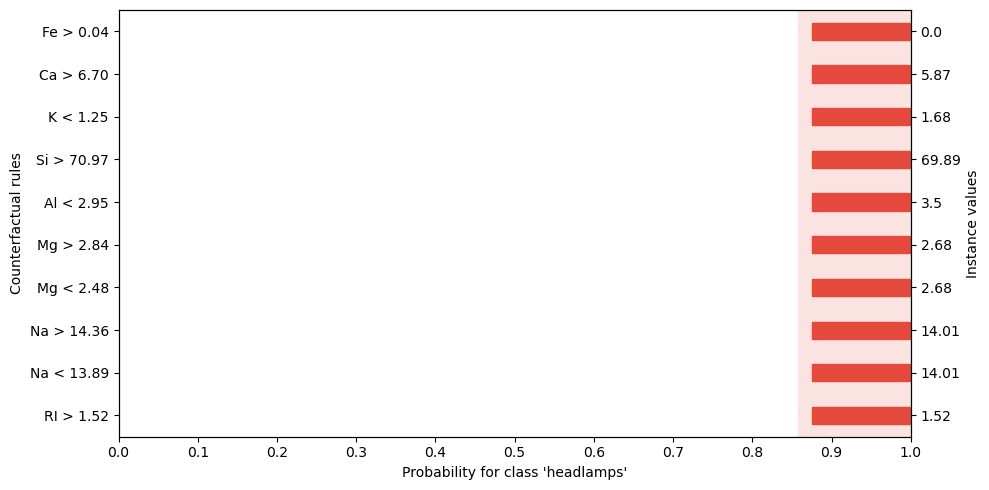

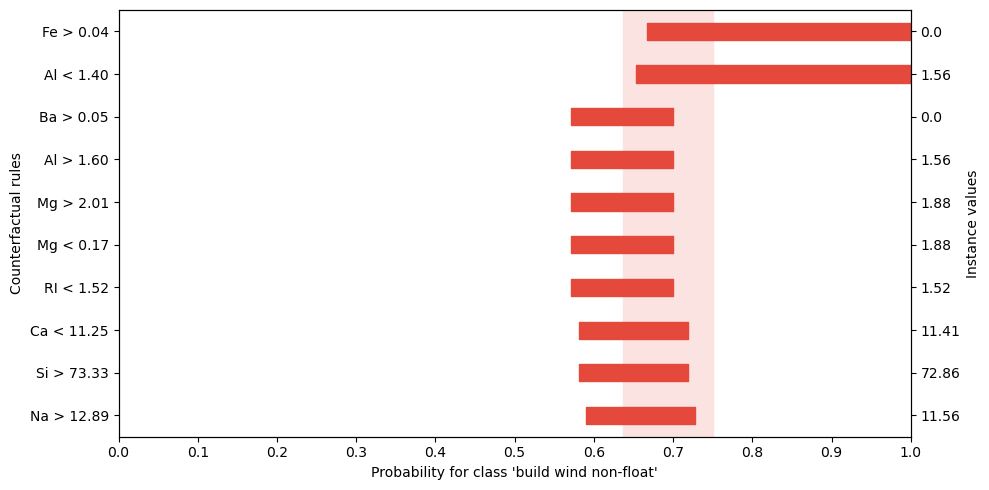

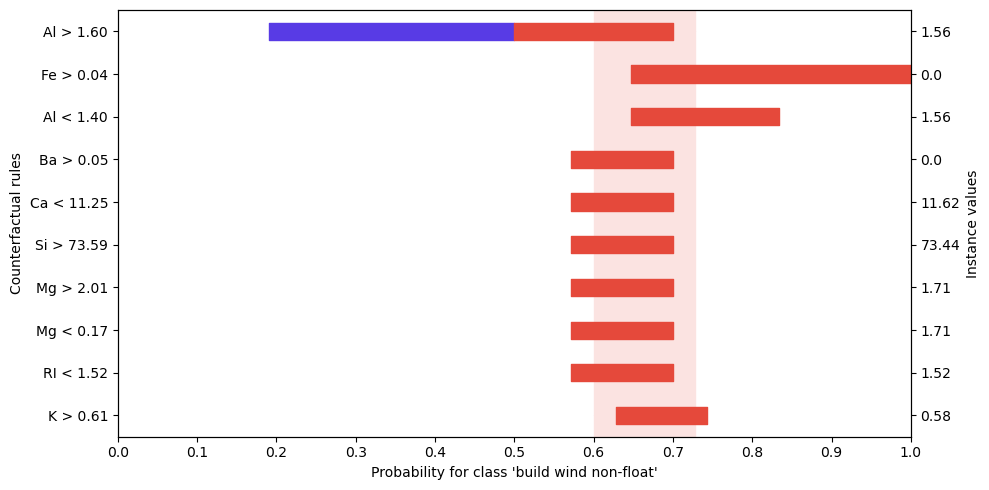

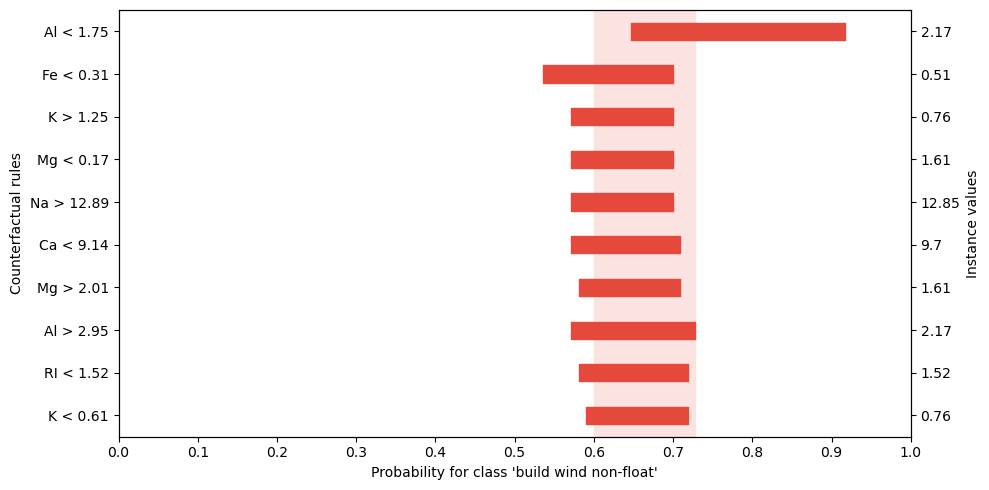

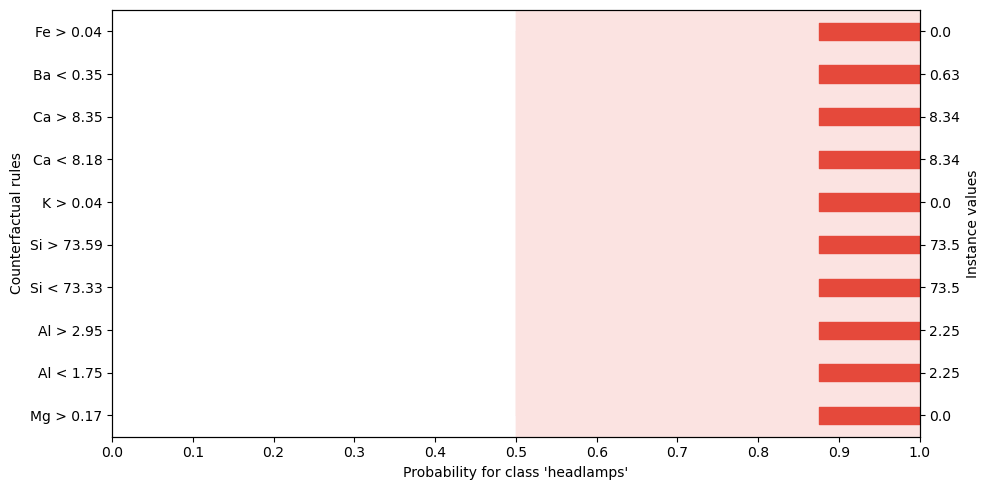

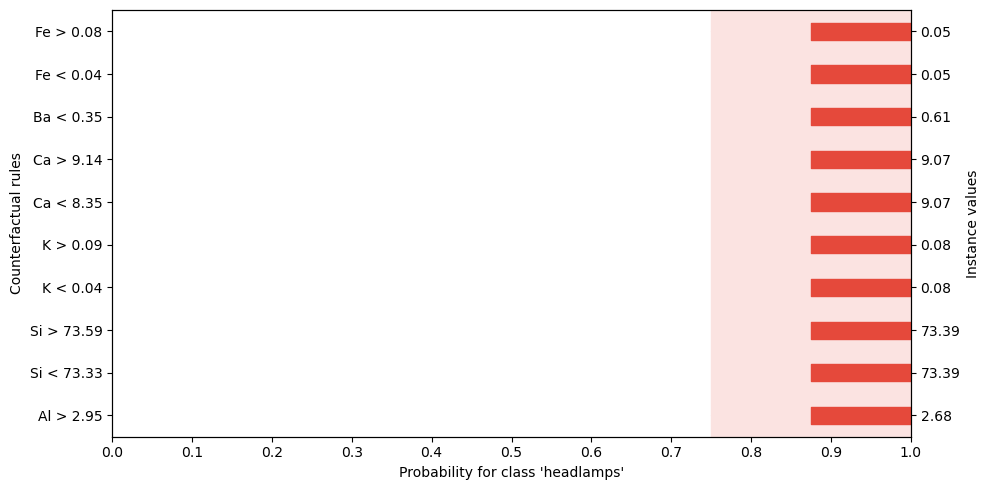

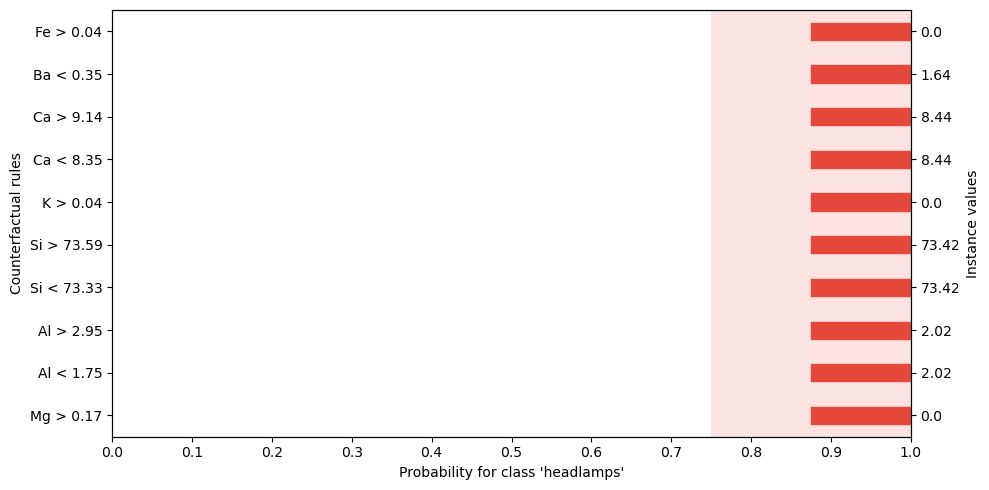

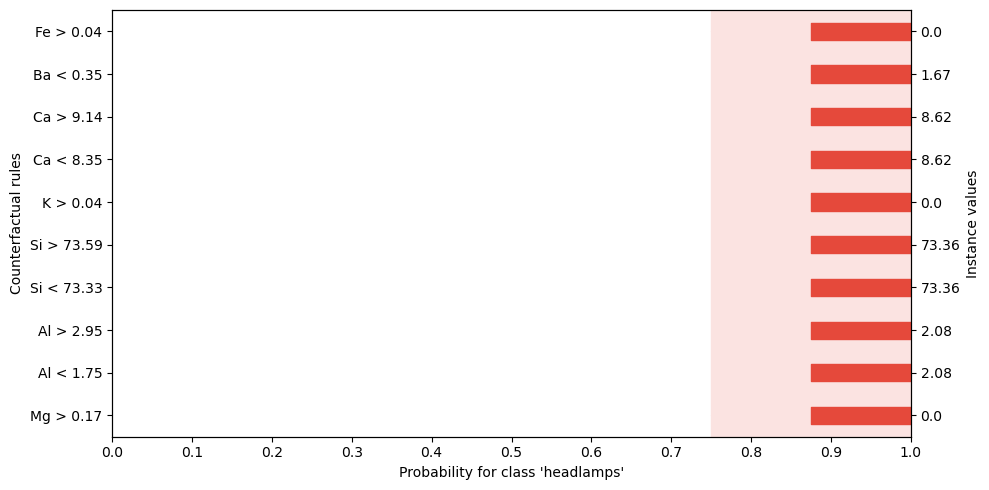

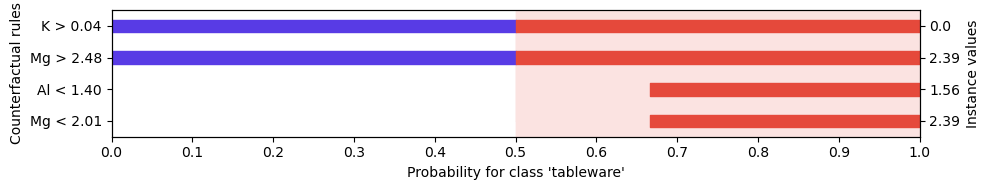

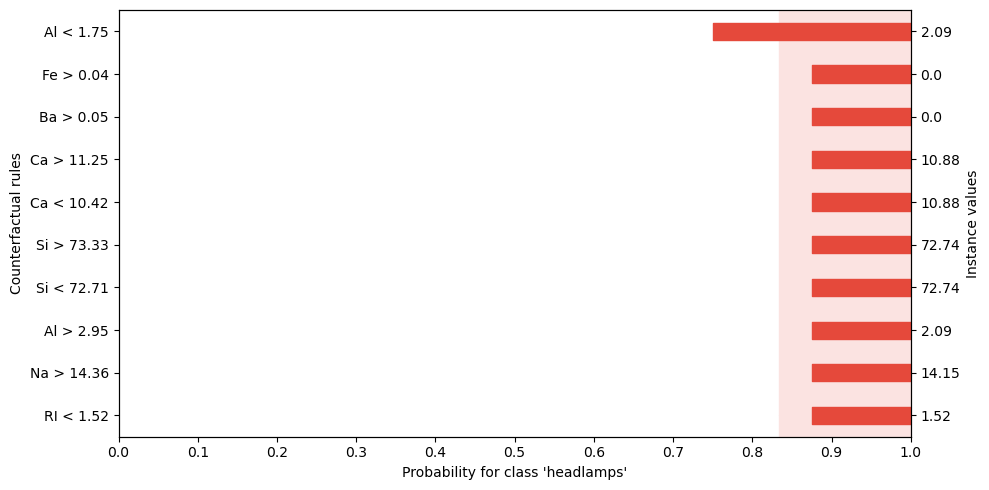

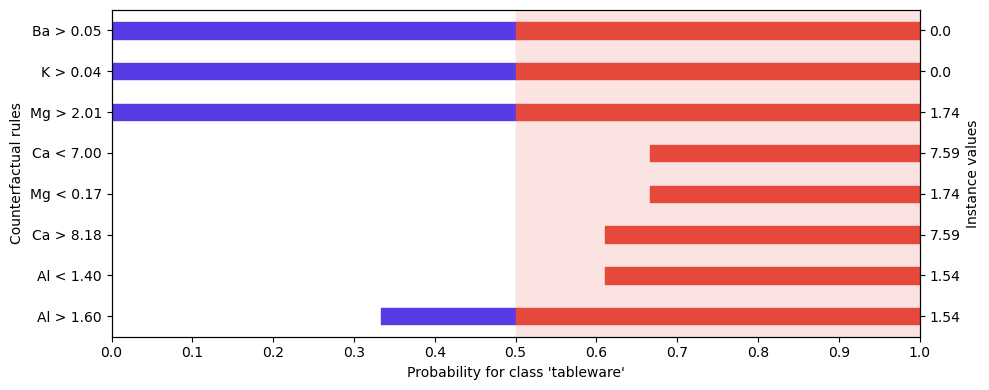

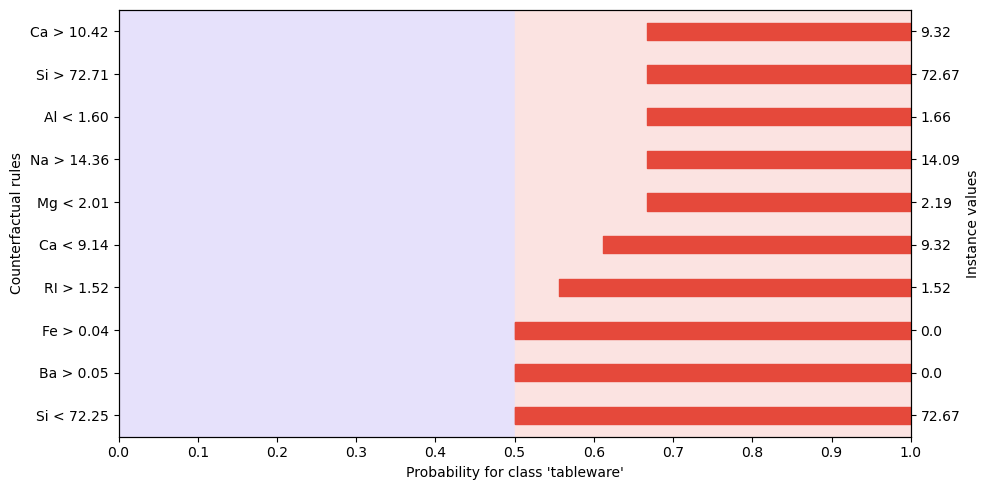

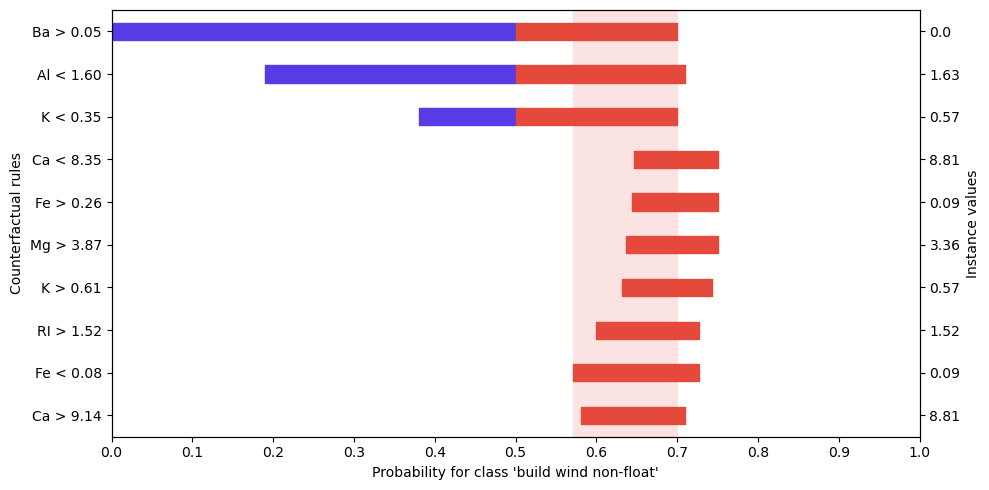

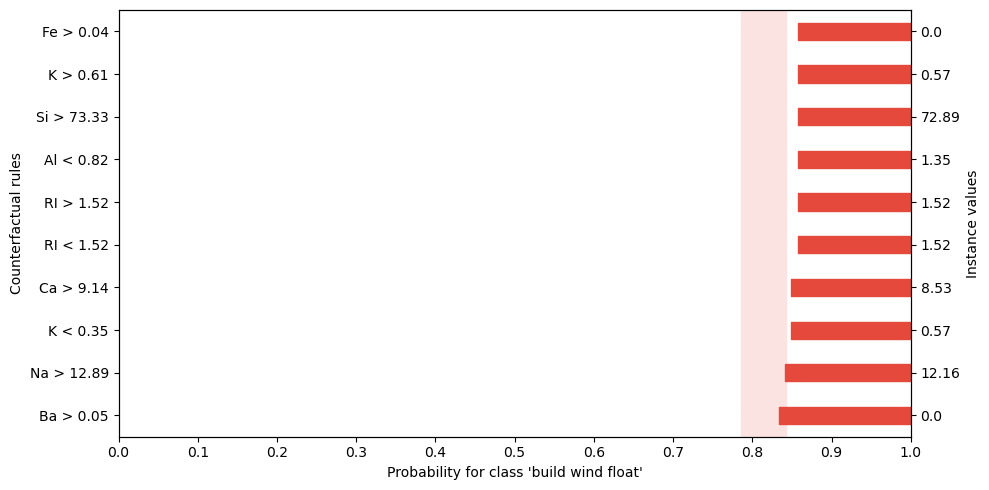

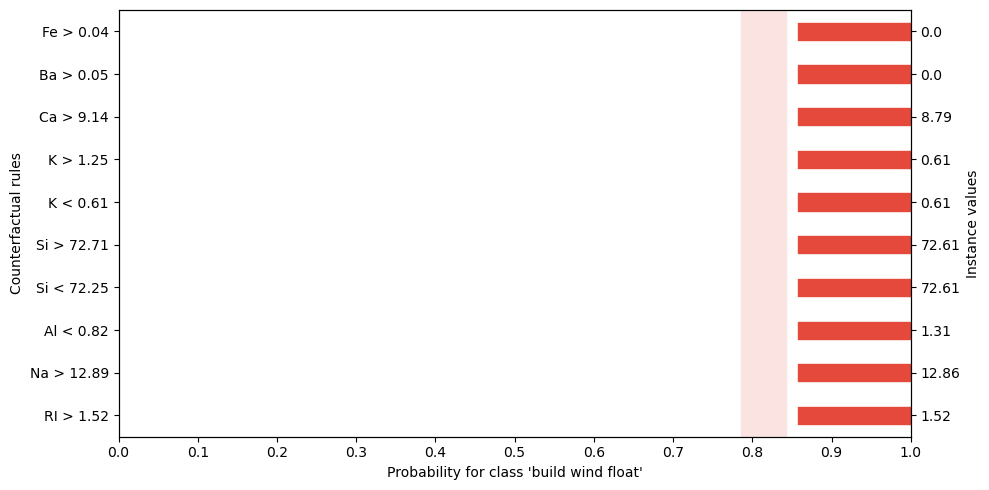

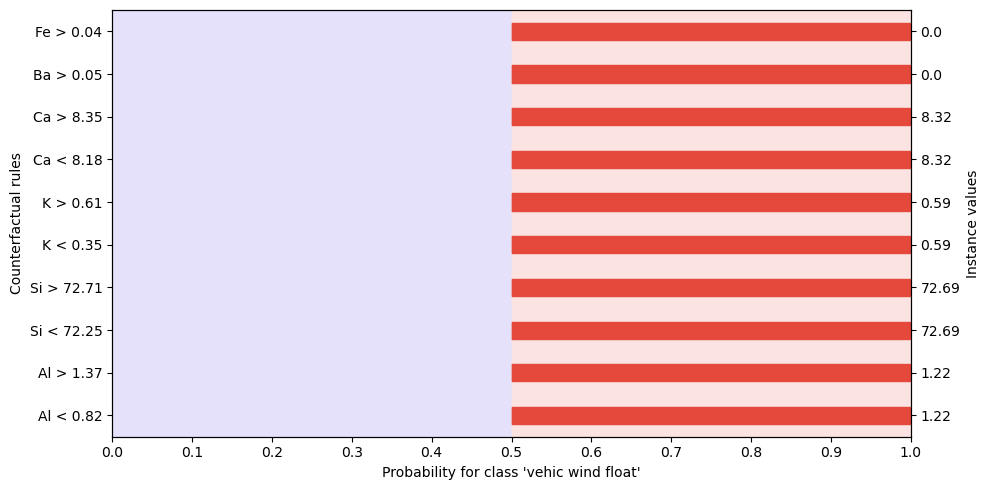

In [18]:
counterfactual_explanation.remove_conjunctions().plot_all()